# Generic Object Decoding: Feature prediction
---
- This is Python code for Generic Decoding Demo. 
- Codes and Data are from  [KamitaniLab][1].  
[1]:https://github.com/KamitaniLab/GenericObjectDecoding/tree/master/code/python  
- All scripts are tested with Python 3.8.8

Analysis summary
----------------

- Learning method:   Sparse linear regression
- Preprocessing:     Normalization and voxel selection
- Data:              GenericDecoding_demo
- Results format:    Pandas dataframe
---
### Data
- All data should be placed in python/data. 
- Data can be obrained from [figshare][2].
[2]:https://figshare.com/articles/dataset/Generic_Object_Decoding/7387130
- The data directory should have the following files:


      data/ --+-- Subject1.h5 (fMRI data, subject 1)
              |
              +-- Subject2.h5 (fMRI data, subject 2)
              |
              +-- Subject3.h5 (fMRI data, subject 3)
              |
              +-- Subject4.h5 (fMRI data, subject 4)
              |
              +-- Subject5.h5 (fMRI data, subject 5)
              |
              +-- ImageFeatures.h5 (image features extracted with Matconvnet)

In [3]:
! pip3 install bdpy

  Using cached bdpy-0.16-py2.py3-none-any.whl (74 kB)
  Using cached hdf5storage-0.1.18-py2.py3-none-any.whl (53 kB)


In [1]:
from __future__ import print_function

import os
import sys
import pickle
from itertools import product
from time import time

import numpy as np
import pandas as pd
from scipy import stats

from slir import SparseLinearRegression # download slir
from sklearn.linear_model import LinearRegression  # For quick demo

import bdpy features # download bdpy
from bdpy.bdata import concat_dataset
from bdpy.ml import add_bias
from bdpy.preproc import select_top
from bdpy.stats import corrcoef
from bdpy.util import makedir_ifnot, get_refdata
from bdpy.dataform import append_dataframe
from bdpy.distcomp import DistComp

import god_config as config

##  Step 1) Analysis - Feature Prediction
   #### Run image feature prediction for each subject, ROI, and layer (feature).
   #### analysis_FeaturePrediction.py
   - feature_prediction()
   - get_averaged_feature()
   - main()
   ---
##### * feature_prediction()
   Run feature prediction

In [2]:
def feature_prediction(x_train, y_train, x_test, y_test, n_voxel=500, n_iter=200):

    n_unit = y_train.shape[1] # 100 units 

    # Normalize brian data (x)
    norm_mean_x = np.mean(x_train, axis=0)
    norm_scale_x = np.std(x_train, axis=0, ddof=1)

    x_train = (x_train - norm_mean_x) / norm_scale_x
    x_test = (x_test - norm_mean_x) / norm_scale_x

    # Feature prediction for each unit
    print('Running feature prediction')

    y_true_list = []
    y_pred_list = []

    for i in range(n_unit):

        print('Unit %03d' % (i + 1))
        start_time = time()

        # Get unit features
        y_train_unit = y_train[:, i]
        y_test_unit =  y_test[:, i]

        # Normalize image features for training (y_train_unit)
        norm_mean_y = np.mean(y_train_unit, axis=0)
        std_y = np.std(y_train_unit, axis=0, ddof=1)
        norm_scale_y = 1 if std_y == 0 else std_y

        y_train_unit = (y_train_unit - norm_mean_y) / norm_scale_y

        # Voxel selection
        corr = corrcoef(y_train_unit, x_train, var='col')

        x_train_unit, voxel_index = select_top(x_train, np.abs(corr), n_voxel, axis=1, verbose=False)
        x_test_unit = x_test[:, voxel_index]

        # Add bias terms
        x_train_unit = add_bias(x_train_unit, axis=1)
        x_test_unit = add_bias(x_test_unit, axis=1)

        # Setup regression
        # For quick demo, use linaer regression
        model = LinearRegression()
        #model = SparseLinearRegression(n_iter=n_iter, prune_mode=1)  # ........ optional

        # Training and test
        try:
            model.fit(x_train_unit, y_train_unit)  # Training
            y_pred = model.predict(x_test_unit)    # Test
        except:
            # When SLiR failed, returns zero-filled array as predicted features
            y_pred = np.zeros(y_test_unit.shape)

        # Denormalize predicted features
        y_pred = y_pred * norm_scale_y + norm_mean_y

        y_true_list.append(y_test_unit)
        y_pred_list.append(y_pred)

        print('Time: %.3f sec' % (time() - start_time))

    # Create numpy arrays for return values
    y_predicted = np.vstack(y_pred_list).T
    y_true = np.vstack(y_true_list).T

    return y_predicted, y_true

##### * get_averaged_feature()
  Return category-averaged features

In [3]:
def get_averaged_feature(pred_y, true_y, labels):

    labels_set = np.unique(labels)

    pred_y_av = np.array([np.mean(pred_y[labels == c, :], axis=0) for c in labels_set])
    true_y_av = np.array([np.mean(true_y[labels == c, :], axis=0) for c in labels_set])

    return pred_y_av, true_y_av, labels_set

##### * main()

In [4]:
# Data settings
subjects = config.subjects
rois = config.rois
num_voxel = config.num_voxel

image_feature = config.image_feature_file
features = config.features

n_iter = 200

results_dir = config.results_dir

# Misc settings
# analysis_basename = os.path.basename(__file__)
analysis_basename = 'analysis_FeaturePrediction.py' # ...........for Jupyter

### Load data

In [5]:
print('----------------------------------------')
print('Loading data')

data_all = {}

''' ....................................................................For quick test,
Edit <god_config.py>, or include & edit belows

# subjects = {'Subject1' : ['data/Subject1.h5'],
            'Subject2' : ['data/Subject2.h5'],
            'Subject3' : ['data/Subject3.h5'],
            'Subject4' : ['data/Subject4.h5'],
            'Subject5' : ['data/Subject5.h5']}
# rois = {'VC' : 'ROI_VC = 1',
        'LVC' : 'ROI_LVC = 1',
        'HVC' : 'ROI_HVC = 1',
        'V1' : 'ROI_V1 = 1',
        'V2' : 'ROI_V2 = 1',
        'V3' : 'ROI_V3 = 1',
        'V4' : 'ROI_V4 = 1',
        'LOC' : 'ROI_LOC = 1',
        'FFA' : 'ROI_FFA = 1',
        'PPA' : 'ROI_PPA = 1'}
# features = ['cnn1', 'cnn2', 'cnn3', 'cnn4', 'cnn5', 'cnn6', 'cnn7', 'cnn8', 'hmax1', 'hmax2', 'hmax3', 'gist', 'sift']
'''
for sbj in subjects:
    if len(subjects[sbj]) == 1:
        data_all[sbj] = bdpy.BData(subjects[sbj][0])
    else:
        # Concatenate data
        suc_cols = ['Run', 'Block']
        data_all[sbj] = concat_dataset([bdpy.BData(f) for f in subjects[sbj]],
                                       successive=suc_cols)

data_feature = bdpy.BData(image_feature)


----------------------------------------
Loading data


###  Add any additional processing to data here

### Initialize directories

In [6]:
makedir_ifnot(results_dir)
makedir_ifnot('tmp')

False

### Analysis loop

In [8]:
print('----------------------------------------')
print('Analysis loop')
print(subjects)#tmp
for sbj, roi, feat in product(subjects, rois, features):
    print('--------------------')
    print('Subject:    %s' % sbj)
    print('ROI:        %s' % roi)
    print('Num voxels: %d' % num_voxel[roi])
    print('Feature:    %s' % feat)

    # Distributed computation
    analysis_id = analysis_basename + '-' + sbj + '-' + roi + '-' + feat
    
    results_file = os.path.join(results_dir, analysis_id + '.pkl')
    print(results_file)
    if os.path.exists(results_file):
        print('%s is already done. Skipped.' % analysis_id)
        continue
    '''
    dist = DistComp(lockdir='tmp', comp_id=analysis_id)
    if dist.islocked():
        print('%s is already running. Skipped.' % analysis_id)
        continue

    dist.lock()
    '''
    # Prepare data
    print('Preparing data')
    dat = data_all[sbj]

    x = dat.select(rois[roi])           # Brain data
    datatype = dat.select('DataType')   # Data type
    labels = dat.select('stimulus_id')  # Image labels in brain data

    y = data_feature.select(feat)             # Image features
    y_label = data_feature.select('ImageID')  # Image labels

    # For quick demo, reduce the number of units from 1000 to 100
    y = y[:, :100]

    y_sorted = get_refdata(y, y_label, labels)  # Image features corresponding to brain data

    # Get training and test dataset
    i_train = (datatype == 1).flatten()    # Index for training
    i_test_pt = (datatype == 2).flatten()  # Index for perception test
    i_test_im = (datatype == 3).flatten()  # Index for imagery test
    i_test = i_test_pt + i_test_im

    x_train = x[i_train, :]
    x_test = x[i_test, :]

    y_train = y_sorted[i_train, :]
    y_test = y_sorted[i_test, :]

    # Feature prediction
    pred_y, true_y = feature_prediction(x_train, y_train,
                                        x_test, y_test,
                                        n_voxel=num_voxel[roi],
                                        n_iter=n_iter)

    # Separate results for perception and imagery tests
    i_pt = i_test_pt[i_test]  # Index for perception test within test
    i_im = i_test_im[i_test]  # Index for imagery test within test

    pred_y_pt = pred_y[i_pt, :]
    pred_y_im = pred_y[i_im, :]

    true_y_pt = true_y[i_pt, :]
    true_y_im = true_y[i_im, :]

    # Get averaged predicted feature
    test_label_pt = labels[i_test_pt, :].flatten()
    test_label_im = labels[i_test_im, :].flatten()

    pred_y_pt_av, true_y_pt_av, test_label_set_pt \
        = get_averaged_feature(pred_y_pt, true_y_pt, test_label_pt)
    pred_y_im_av, true_y_im_av, test_label_set_im \
        = get_averaged_feature(pred_y_im, true_y_im, test_label_im)

    # Get category averaged features
    catlabels_pt = np.vstack([int(n) for n in test_label_pt])  # Category labels (perception test)
    catlabels_im = np.vstack([int(n) for n in test_label_im])  # Category labels (imagery test)
    catlabels_set_pt = np.unique(catlabels_pt)                 # Category label set (perception test)
    catlabels_set_im = np.unique(catlabels_im)                 # Category label set (imagery test)

    y_catlabels = data_feature.select('CatID')   # Category labels in image features
    ind_catave = (data_feature.select('FeatureType') == 3).flatten()

    y_catave_pt = get_refdata(y[ind_catave, :], y_catlabels[ind_catave, :], catlabels_set_pt)
    y_catave_im = get_refdata(y[ind_catave, :], y_catlabels[ind_catave, :], catlabels_set_im)

    # Prepare result dataframe
    results = pd.DataFrame({'subject' : [sbj, sbj],
                            'roi' : [roi, roi],
                            'feature' : [feat, feat],
                            'test_type' : ['perception', 'imagery'],
                            'true_feature': [true_y_pt, true_y_im],
                            'predicted_feature': [pred_y_pt, pred_y_im],
                            'test_label' : [test_label_pt, test_label_im],
                            'test_label_set' : [test_label_set_pt, test_label_set_im],
                            'true_feature_averaged' : [true_y_pt_av, true_y_im_av],
                            'predicted_feature_averaged' : [pred_y_pt_av, pred_y_im_av],
                            'category_label_set' : [catlabels_set_pt, catlabels_set_im],
                            'category_feature_averaged' : [y_catave_pt, y_catave_im]})

    # Save results
    makedir_ifnot(os.path.dirname(results_file))
    with open(results_file, 'wb') as f:
        pickle.dump(results, f)

    print('Saved %s' % results_file)

    #dist.unlock()   #.............................tmp

----------------------------------------
Analysis loop
{'Subject1': ['data/Subject1.h5'], 'Subject2': ['data/Subject2.h5'], 'Subject3': ['data/Subject3.h5'], 'Subject4': ['data/Subject4.h5'], 'Subject5': ['data/Subject5.h5']}
--------------------
Subject:    Subject1
ROI:        VC
Num voxels: 1000
Feature:    cnn1
results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-VC-cnn1.pkl
Preparing data
Running feature prediction
Unit 001
Time: 2.400 sec
Unit 002
Time: 2.432 sec
Unit 003
Time: 2.400 sec
Unit 004
Time: 2.446 sec
Unit 005
Time: 2.378 sec
Unit 006
Time: 2.304 sec
Unit 007
Time: 2.384 sec
Unit 008
Time: 2.304 sec
Unit 009
Time: 2.445 sec
Unit 010
Time: 2.448 sec
Unit 011
Time: 2.340 sec
Unit 012
Time: 2.418 sec
Unit 013
Time: 2.440 sec
Unit 014
Time: 2.354 sec
Unit 015
Time: 2.378 sec
Unit 016
Time: 2.351 sec
Unit 017
Time: 2.530 sec
Unit 018
Time: 2.367 sec
Unit 019
Time: 2.395 sec
Unit 020
Time: 2.374 sec
Unit 021
Time: 2.307 sec
Unit 022
Time: 2.390 sec
Unit 023
T

Running feature prediction
Unit 001
Time: 2.354 sec
Unit 002
Time: 2.492 sec
Unit 003
Time: 2.388 sec
Unit 004
Time: 2.369 sec
Unit 005
Time: 2.326 sec
Unit 006
Time: 2.370 sec
Unit 007
Time: 2.431 sec
Unit 008
Time: 2.398 sec
Unit 009
Time: 2.362 sec
Unit 010
Time: 2.384 sec
Unit 011
Time: 2.349 sec
Unit 012
Time: 2.333 sec
Unit 013
Time: 2.384 sec
Unit 014
Time: 2.359 sec
Unit 015
Time: 2.444 sec
Unit 016
Time: 2.394 sec
Unit 017
Time: 2.484 sec
Unit 018
Time: 2.374 sec
Unit 019
Time: 2.465 sec
Unit 020
Time: 2.356 sec
Unit 021
Time: 2.324 sec
Unit 022
Time: 2.358 sec
Unit 023
Time: 2.540 sec
Unit 024
Time: 2.344 sec
Unit 025
Time: 2.311 sec
Unit 026
Time: 2.387 sec
Unit 027
Time: 2.413 sec
Unit 028
Time: 2.338 sec
Unit 029
Time: 2.351 sec
Unit 030
Time: 2.442 sec
Unit 031
Time: 2.411 sec
Unit 032
Time: 2.324 sec
Unit 033
Time: 2.280 sec
Unit 034
Time: 2.364 sec
Unit 035
Time: 2.354 sec
Unit 036
Time: 2.427 sec
Unit 037
Time: 2.383 sec
Unit 038
Time: 2.333 sec
Unit 039
Time: 2.424 se

Running feature prediction
Unit 001
Time: 2.073 sec
Unit 002
Time: 2.132 sec
Unit 003
Time: 2.147 sec
Unit 004
Time: 2.205 sec
Unit 005
Time: 2.239 sec
Unit 006
Time: 2.109 sec
Unit 007
Time: 2.123 sec
Unit 008
Time: 2.197 sec
Unit 009
Time: 2.194 sec
Unit 010
Time: 2.141 sec
Unit 011
Time: 2.101 sec
Unit 012
Time: 2.131 sec
Unit 013
Time: 2.100 sec
Unit 014
Time: 2.089 sec
Unit 015
Time: 2.096 sec
Unit 016
Time: 2.106 sec
Unit 017
Time: 2.089 sec
Unit 018
Time: 2.114 sec
Unit 019
Time: 2.158 sec
Unit 020
Time: 2.089 sec
Unit 021
Time: 2.122 sec
Unit 022
Time: 2.140 sec
Unit 023
Time: 2.091 sec
Unit 024
Time: 2.134 sec
Unit 025
Time: 2.103 sec
Unit 026
Time: 2.113 sec
Unit 027
Time: 2.089 sec
Unit 028
Time: 2.105 sec
Unit 029
Time: 2.116 sec
Unit 030
Time: 2.134 sec
Unit 031
Time: 2.140 sec
Unit 032
Time: 2.296 sec
Unit 033
Time: 2.127 sec
Unit 034
Time: 2.113 sec
Unit 035
Time: 2.102 sec
Unit 036
Time: 2.115 sec
Unit 037
Time: 2.091 sec
Unit 038
Time: 2.111 sec
Unit 039
Time: 2.157 se

Running feature prediction
Unit 001
Time: 2.003 sec
Unit 002
Time: 2.087 sec
Unit 003
Time: 2.072 sec
Unit 004
Time: 2.088 sec
Unit 005
Time: 2.090 sec
Unit 006
Time: 2.111 sec
Unit 007
Time: 2.066 sec
Unit 008
Time: 2.134 sec
Unit 009
Time: 2.076 sec
Unit 010
Time: 2.082 sec
Unit 011
Time: 2.071 sec
Unit 012
Time: 2.075 sec
Unit 013
Time: 2.068 sec
Unit 014
Time: 2.053 sec
Unit 015
Time: 2.066 sec
Unit 016
Time: 2.055 sec
Unit 017
Time: 2.056 sec
Unit 018
Time: 2.081 sec
Unit 019
Time: 2.082 sec
Unit 020
Time: 2.067 sec
Unit 021
Time: 2.073 sec
Unit 022
Time: 2.066 sec
Unit 023
Time: 2.084 sec
Unit 024
Time: 2.084 sec
Unit 025
Time: 2.058 sec
Unit 026
Time: 2.084 sec
Unit 027
Time: 2.085 sec
Unit 028
Time: 2.084 sec
Unit 029
Time: 2.066 sec
Unit 030
Time: 2.084 sec
Unit 031
Time: 2.069 sec
Unit 032
Time: 2.083 sec
Unit 033
Time: 2.096 sec
Unit 034
Time: 2.073 sec
Unit 035
Time: 2.070 sec
Unit 036
Time: 2.244 sec
Unit 037
Time: 2.099 sec
Unit 038
Time: 2.079 sec
Unit 039
Time: 2.079 se

Running feature prediction
Unit 001
Time: 2.028 sec
Unit 002
Time: 2.062 sec
Unit 003
Time: 2.057 sec
Unit 004
Time: 2.070 sec
Unit 005
Time: 2.057 sec
Unit 006
Time: 2.074 sec
Unit 007
Time: 2.060 sec
Unit 008
Time: 2.064 sec
Unit 009
Time: 2.059 sec
Unit 010
Time: 2.041 sec
Unit 011
Time: 2.076 sec
Unit 012
Time: 2.069 sec
Unit 013
Time: 2.068 sec
Unit 014
Time: 2.067 sec
Unit 015
Time: 2.058 sec
Unit 016
Time: 2.104 sec
Unit 017
Time: 2.067 sec
Unit 018
Time: 2.054 sec
Unit 019
Time: 2.067 sec
Unit 020
Time: 2.075 sec
Unit 021
Time: 2.072 sec
Unit 022
Time: 2.064 sec
Unit 023
Time: 2.082 sec
Unit 024
Time: 2.150 sec
Unit 025
Time: 2.072 sec
Unit 026
Time: 2.057 sec
Unit 027
Time: 2.056 sec
Unit 028
Time: 2.061 sec
Unit 029
Time: 2.060 sec
Unit 030
Time: 2.062 sec
Unit 031
Time: 2.089 sec
Unit 032
Time: 2.060 sec
Unit 033
Time: 2.066 sec
Unit 034
Time: 2.070 sec
Unit 035
Time: 2.067 sec
Unit 036
Time: 2.058 sec
Unit 037
Time: 2.068 sec
Unit 038
Time: 2.081 sec
Unit 039
Time: 2.068 se

Running feature prediction
Unit 001
Time: 2.041 sec
Unit 002
Time: 2.060 sec
Unit 003
Time: 2.053 sec
Unit 004
Time: 2.077 sec
Unit 005
Time: 2.067 sec
Unit 006
Time: 2.063 sec
Unit 007
Time: 2.078 sec
Unit 008
Time: 2.055 sec
Unit 009
Time: 2.052 sec
Unit 010
Time: 2.067 sec
Unit 011
Time: 2.061 sec
Unit 012
Time: 2.058 sec
Unit 013
Time: 2.063 sec
Unit 014
Time: 2.060 sec
Unit 015
Time: 2.276 sec
Unit 016
Time: 2.174 sec
Unit 017
Time: 2.069 sec
Unit 018
Time: 2.071 sec
Unit 019
Time: 2.072 sec
Unit 020
Time: 2.066 sec
Unit 021
Time: 2.064 sec
Unit 022
Time: 2.079 sec
Unit 023
Time: 2.064 sec
Unit 024
Time: 2.056 sec
Unit 025
Time: 2.073 sec
Unit 026
Time: 2.064 sec
Unit 027
Time: 2.063 sec
Unit 028
Time: 2.062 sec
Unit 029
Time: 2.061 sec
Unit 030
Time: 2.060 sec
Unit 031
Time: 2.089 sec
Unit 032
Time: 2.067 sec
Unit 033
Time: 2.057 sec
Unit 034
Time: 2.076 sec
Unit 035
Time: 2.060 sec
Unit 036
Time: 2.056 sec
Unit 037
Time: 2.083 sec
Unit 038
Time: 2.055 sec
Unit 039
Time: 2.075 se

Running feature prediction
Unit 001
Time: 0.534 sec
Unit 002
Time: 0.596 sec
Unit 003
Time: 0.602 sec
Unit 004
Time: 0.532 sec
Unit 005
Time: 0.595 sec
Unit 006
Time: 0.609 sec
Unit 007
Time: 0.603 sec
Unit 008
Time: 0.584 sec
Unit 009
Time: 0.599 sec
Unit 010
Time: 0.593 sec
Unit 011
Time: 0.612 sec
Unit 012
Time: 0.594 sec
Unit 013
Time: 0.608 sec
Unit 014
Time: 0.590 sec
Unit 015
Time: 0.614 sec
Unit 016
Time: 0.593 sec
Unit 017
Time: 0.605 sec
Unit 018
Time: 0.590 sec
Unit 019
Time: 0.552 sec
Unit 020
Time: 0.595 sec
Unit 021
Time: 0.592 sec
Unit 022
Time: 0.603 sec
Unit 023
Time: 0.601 sec
Unit 024
Time: 0.598 sec
Unit 025
Time: 0.595 sec
Unit 026
Time: 0.590 sec
Unit 027
Time: 0.603 sec
Unit 028
Time: 0.586 sec
Unit 029
Time: 0.604 sec
Unit 030
Time: 0.592 sec
Unit 031
Time: 0.601 sec
Unit 032
Time: 0.601 sec
Unit 033
Time: 0.599 sec
Unit 034
Time: 0.613 sec
Unit 035
Time: 0.612 sec
Unit 036
Time: 0.592 sec
Unit 037
Time: 0.613 sec
Unit 038
Time: 0.576 sec
Unit 039
Time: 0.593 se

Running feature prediction
Unit 001
Time: 0.525 sec
Unit 002
Time: 0.563 sec
Unit 003
Time: 0.621 sec
Unit 004
Time: 0.591 sec
Unit 005
Time: 0.611 sec
Unit 006
Time: 0.594 sec
Unit 007
Time: 0.599 sec
Unit 008
Time: 0.594 sec
Unit 009
Time: 0.559 sec
Unit 010
Time: 0.593 sec
Unit 011
Time: 0.596 sec
Unit 012
Time: 0.586 sec
Unit 013
Time: 0.606 sec
Unit 014
Time: 0.590 sec
Unit 015
Time: 0.581 sec
Unit 016
Time: 0.596 sec
Unit 017
Time: 0.591 sec
Unit 018
Time: 0.595 sec
Unit 019
Time: 0.555 sec
Unit 020
Time: 0.601 sec
Unit 021
Time: 0.549 sec
Unit 022
Time: 0.608 sec
Unit 023
Time: 0.571 sec
Unit 024
Time: 0.600 sec
Unit 025
Time: 0.606 sec
Unit 026
Time: 0.595 sec
Unit 027
Time: 0.588 sec
Unit 028
Time: 0.596 sec
Unit 029
Time: 0.594 sec
Unit 030
Time: 0.603 sec
Unit 031
Time: 0.597 sec
Unit 032
Time: 0.604 sec
Unit 033
Time: 0.607 sec
Unit 034
Time: 0.611 sec
Unit 035
Time: 0.586 sec
Unit 036
Time: 0.600 sec
Unit 037
Time: 0.593 sec
Unit 038
Time: 0.588 sec
Unit 039
Time: 0.598 se

Running feature prediction
Unit 001
Time: 0.532 sec
Unit 002
Time: 0.599 sec
Unit 003
Time: 0.617 sec
Unit 004
Time: 0.552 sec
Unit 005
Time: 0.553 sec
Unit 006
Time: 0.598 sec
Unit 007
Time: 0.586 sec
Unit 008
Time: 0.596 sec
Unit 009
Time: 0.554 sec
Unit 010
Time: 0.603 sec
Unit 011
Time: 0.596 sec
Unit 012
Time: 0.582 sec
Unit 013
Time: 0.596 sec
Unit 014
Time: 0.575 sec
Unit 015
Time: 0.590 sec
Unit 016
Time: 0.587 sec
Unit 017
Time: 0.586 sec
Unit 018
Time: 0.573 sec
Unit 019
Time: 0.605 sec
Unit 020
Time: 0.597 sec
Unit 021
Time: 0.563 sec
Unit 022
Time: 0.556 sec
Unit 023
Time: 0.593 sec
Unit 024
Time: 0.586 sec
Unit 025
Time: 0.618 sec
Unit 026
Time: 0.577 sec
Unit 027
Time: 0.589 sec
Unit 028
Time: 0.599 sec
Unit 029
Time: 0.592 sec
Unit 030
Time: 0.602 sec
Unit 031
Time: 0.572 sec
Unit 032
Time: 0.595 sec
Unit 033
Time: 0.605 sec
Unit 034
Time: 0.586 sec
Unit 035
Time: 0.616 sec
Unit 036
Time: 0.589 sec
Unit 037
Time: 0.605 sec
Unit 038
Time: 0.606 sec
Unit 039
Time: 0.593 se

Running feature prediction
Unit 001
Time: 0.524 sec
Unit 002
Time: 0.598 sec
Unit 003
Time: 0.616 sec
Unit 004
Time: 0.589 sec
Unit 005
Time: 0.613 sec
Unit 006
Time: 0.579 sec
Unit 007
Time: 0.611 sec
Unit 008
Time: 0.587 sec
Unit 009
Time: 0.603 sec
Unit 010
Time: 0.600 sec
Unit 011
Time: 0.601 sec
Unit 012
Time: 0.607 sec
Unit 013
Time: 0.558 sec
Unit 014
Time: 0.595 sec
Unit 015
Time: 0.562 sec
Unit 016
Time: 0.593 sec
Unit 017
Time: 0.588 sec
Unit 018
Time: 0.583 sec
Unit 019
Time: 0.604 sec
Unit 020
Time: 0.578 sec
Unit 021
Time: 0.537 sec
Unit 022
Time: 0.598 sec
Unit 023
Time: 0.592 sec
Unit 024
Time: 0.587 sec
Unit 025
Time: 0.570 sec
Unit 026
Time: 0.591 sec
Unit 027
Time: 0.615 sec
Unit 028
Time: 0.599 sec
Unit 029
Time: 0.602 sec
Unit 030
Time: 0.593 sec
Unit 031
Time: 0.599 sec
Unit 032
Time: 0.571 sec
Unit 033
Time: 0.598 sec
Unit 034
Time: 0.599 sec
Unit 035
Time: 0.602 sec
Unit 036
Time: 0.600 sec
Unit 037
Time: 0.575 sec
Unit 038
Time: 0.595 sec
Unit 039
Time: 0.601 se

Running feature prediction
Unit 001
Time: 0.613 sec
Unit 002
Time: 0.703 sec
Unit 003
Time: 0.689 sec
Unit 004
Time: 0.666 sec
Unit 005
Time: 0.681 sec
Unit 006
Time: 0.675 sec
Unit 007
Time: 0.686 sec
Unit 008
Time: 0.694 sec
Unit 009
Time: 0.685 sec
Unit 010
Time: 0.677 sec
Unit 011
Time: 0.688 sec
Unit 012
Time: 0.674 sec
Unit 013
Time: 0.684 sec
Unit 014
Time: 0.681 sec
Unit 015
Time: 0.681 sec
Unit 016
Time: 0.675 sec
Unit 017
Time: 0.699 sec
Unit 018
Time: 0.682 sec
Unit 019
Time: 0.666 sec
Unit 020
Time: 0.684 sec
Unit 021
Time: 0.694 sec
Unit 022
Time: 0.681 sec
Unit 023
Time: 0.684 sec
Unit 024
Time: 0.662 sec
Unit 025
Time: 0.670 sec
Unit 026
Time: 0.698 sec
Unit 027
Time: 0.676 sec
Unit 028
Time: 0.679 sec
Unit 029
Time: 0.738 sec
Unit 030
Time: 0.671 sec
Unit 031
Time: 0.670 sec
Unit 032
Time: 0.679 sec
Unit 033
Time: 0.692 sec
Unit 034
Time: 0.674 sec
Unit 035
Time: 0.680 sec
Unit 036
Time: 0.688 sec
Unit 037
Time: 0.670 sec
Unit 038
Time: 0.668 sec
Unit 039
Time: 0.680 se

Running feature prediction
Unit 001
Time: 0.610 sec
Unit 002
Time: 0.656 sec
Unit 003
Time: 0.681 sec
Unit 004
Time: 0.680 sec
Unit 005
Time: 0.681 sec
Unit 006
Time: 0.638 sec
Unit 007
Time: 0.676 sec
Unit 008
Time: 0.677 sec
Unit 009
Time: 0.649 sec
Unit 010
Time: 0.677 sec
Unit 011
Time: 0.683 sec
Unit 012
Time: 0.668 sec
Unit 013
Time: 0.682 sec
Unit 014
Time: 0.682 sec
Unit 015
Time: 0.684 sec
Unit 016
Time: 0.692 sec
Unit 017
Time: 0.690 sec
Unit 018
Time: 0.683 sec
Unit 019
Time: 0.696 sec
Unit 020
Time: 0.669 sec
Unit 021
Time: 0.688 sec
Unit 022
Time: 0.686 sec
Unit 023
Time: 0.688 sec
Unit 024
Time: 0.688 sec
Unit 025
Time: 0.655 sec
Unit 026
Time: 0.689 sec
Unit 027
Time: 0.676 sec
Unit 028
Time: 0.685 sec
Unit 029
Time: 0.660 sec
Unit 030
Time: 0.680 sec
Unit 031
Time: 0.667 sec
Unit 032
Time: 0.688 sec
Unit 033
Time: 0.674 sec
Unit 034
Time: 0.687 sec
Unit 035
Time: 0.640 sec
Unit 036
Time: 0.680 sec
Unit 037
Time: 0.672 sec
Unit 038
Time: 0.674 sec
Unit 039
Time: 0.692 se

Running feature prediction
Unit 001
Time: 0.713 sec
Unit 002
Time: 0.709 sec
Unit 003
Time: 0.656 sec
Unit 004
Time: 0.672 sec
Unit 005
Time: 0.684 sec
Unit 006
Time: 0.680 sec
Unit 007
Time: 0.701 sec
Unit 008
Time: 0.696 sec
Unit 009
Time: 0.661 sec
Unit 010
Time: 0.619 sec
Unit 011
Time: 0.694 sec
Unit 012
Time: 0.683 sec
Unit 013
Time: 0.676 sec
Unit 014
Time: 0.637 sec
Unit 015
Time: 0.690 sec
Unit 016
Time: 0.671 sec
Unit 017
Time: 0.676 sec
Unit 018
Time: 0.673 sec
Unit 019
Time: 0.671 sec
Unit 020
Time: 0.678 sec
Unit 021
Time: 0.678 sec
Unit 022
Time: 0.666 sec
Unit 023
Time: 0.651 sec
Unit 024
Time: 0.677 sec
Unit 025
Time: 0.687 sec
Unit 026
Time: 0.678 sec
Unit 027
Time: 0.685 sec
Unit 028
Time: 0.684 sec
Unit 029
Time: 0.674 sec
Unit 030
Time: 0.661 sec
Unit 031
Time: 0.683 sec
Unit 032
Time: 0.676 sec
Unit 033
Time: 0.675 sec
Unit 034
Time: 0.675 sec
Unit 035
Time: 0.702 sec
Unit 036
Time: 0.675 sec
Unit 037
Time: 0.670 sec
Unit 038
Time: 0.687 sec
Unit 039
Time: 0.666 se

Running feature prediction
Unit 001
Time: 0.629 sec
Unit 002
Time: 0.704 sec
Unit 003
Time: 0.697 sec
Unit 004
Time: 0.706 sec
Unit 005
Time: 0.708 sec
Unit 006
Time: 0.712 sec
Unit 007
Time: 0.678 sec
Unit 008
Time: 0.705 sec
Unit 009
Time: 0.724 sec
Unit 010
Time: 0.723 sec
Unit 011
Time: 0.753 sec
Unit 012
Time: 0.733 sec
Unit 013
Time: 0.728 sec
Unit 014
Time: 0.694 sec
Unit 015
Time: 0.665 sec
Unit 016
Time: 0.666 sec
Unit 017
Time: 0.697 sec
Unit 018
Time: 0.671 sec
Unit 019
Time: 0.699 sec
Unit 020
Time: 0.695 sec
Unit 021
Time: 0.685 sec
Unit 022
Time: 0.696 sec
Unit 023
Time: 0.660 sec
Unit 024
Time: 0.676 sec
Unit 025
Time: 0.675 sec
Unit 026
Time: 0.711 sec
Unit 027
Time: 0.640 sec
Unit 028
Time: 0.674 sec
Unit 029
Time: 0.681 sec
Unit 030
Time: 0.652 sec
Unit 031
Time: 0.703 sec
Unit 032
Time: 0.703 sec
Unit 033
Time: 0.697 sec
Unit 034
Time: 0.711 sec
Unit 035
Time: 0.680 sec
Unit 036
Time: 0.727 sec
Unit 037
Time: 0.724 sec
Unit 038
Time: 0.749 sec
Unit 039
Time: 0.686 se

Running feature prediction
Unit 001
Time: 0.092 sec
Unit 002
Time: 0.109 sec
Unit 003
Time: 0.111 sec
Unit 004
Time: 0.109 sec
Unit 005
Time: 0.107 sec
Unit 006
Time: 0.110 sec
Unit 007
Time: 0.109 sec
Unit 008
Time: 0.106 sec
Unit 009
Time: 0.109 sec
Unit 010
Time: 0.111 sec
Unit 011
Time: 0.114 sec
Unit 012
Time: 0.117 sec
Unit 013
Time: 0.112 sec
Unit 014
Time: 0.111 sec
Unit 015
Time: 0.111 sec
Unit 016
Time: 0.109 sec
Unit 017
Time: 0.106 sec
Unit 018
Time: 0.106 sec
Unit 019
Time: 0.111 sec
Unit 020
Time: 0.115 sec
Unit 021
Time: 0.112 sec
Unit 022
Time: 0.116 sec
Unit 023
Time: 0.106 sec
Unit 024
Time: 0.110 sec
Unit 025
Time: 0.104 sec
Unit 026
Time: 0.114 sec
Unit 027
Time: 0.111 sec
Unit 028
Time: 0.110 sec
Unit 029
Time: 0.111 sec
Unit 030
Time: 0.106 sec
Unit 031
Time: 0.108 sec
Unit 032
Time: 0.106 sec
Unit 033
Time: 0.113 sec
Unit 034
Time: 0.107 sec
Unit 035
Time: 0.115 sec
Unit 036
Time: 0.108 sec
Unit 037
Time: 0.116 sec
Unit 038
Time: 0.115 sec
Unit 039
Time: 0.108 se

Running feature prediction
Unit 001
Time: 0.092 sec
Unit 002
Time: 0.106 sec
Unit 003
Time: 0.113 sec
Unit 004
Time: 0.106 sec
Unit 005
Time: 0.113 sec
Unit 006
Time: 0.114 sec
Unit 007
Time: 0.112 sec
Unit 008
Time: 0.114 sec
Unit 009
Time: 0.110 sec
Unit 010
Time: 0.108 sec
Unit 011
Time: 0.108 sec
Unit 012
Time: 0.116 sec
Unit 013
Time: 0.117 sec
Unit 014
Time: 0.113 sec
Unit 015
Time: 0.121 sec
Unit 016
Time: 0.104 sec
Unit 017
Time: 0.108 sec
Unit 018
Time: 0.112 sec
Unit 019
Time: 0.117 sec
Unit 020
Time: 0.107 sec
Unit 021
Time: 0.106 sec
Unit 022
Time: 0.109 sec
Unit 023
Time: 0.113 sec
Unit 024
Time: 0.113 sec
Unit 025
Time: 0.114 sec
Unit 026
Time: 0.110 sec
Unit 027
Time: 0.110 sec
Unit 028
Time: 0.108 sec
Unit 029
Time: 0.109 sec
Unit 030
Time: 0.108 sec
Unit 031
Time: 0.105 sec
Unit 032
Time: 0.120 sec
Unit 033
Time: 0.112 sec
Unit 034
Time: 0.115 sec
Unit 035
Time: 0.119 sec
Unit 036
Time: 0.108 sec
Unit 037
Time: 0.112 sec
Unit 038
Time: 0.119 sec
Unit 039
Time: 0.118 se

Running feature prediction
Unit 001
Time: 0.091 sec
Unit 002
Time: 0.107 sec
Unit 003
Time: 0.113 sec
Unit 004
Time: 0.111 sec
Unit 005
Time: 0.107 sec
Unit 006
Time: 0.112 sec
Unit 007
Time: 0.118 sec
Unit 008
Time: 0.111 sec
Unit 009
Time: 0.112 sec
Unit 010
Time: 0.111 sec
Unit 011
Time: 0.114 sec
Unit 012
Time: 0.113 sec
Unit 013
Time: 0.122 sec
Unit 014
Time: 0.111 sec
Unit 015
Time: 0.111 sec
Unit 016
Time: 0.113 sec
Unit 017
Time: 0.111 sec
Unit 018
Time: 0.106 sec
Unit 019
Time: 0.114 sec
Unit 020
Time: 0.109 sec
Unit 021
Time: 0.111 sec
Unit 022
Time: 0.107 sec
Unit 023
Time: 0.117 sec
Unit 024
Time: 0.118 sec
Unit 025
Time: 0.112 sec
Unit 026
Time: 0.110 sec
Unit 027
Time: 0.110 sec
Unit 028
Time: 0.116 sec
Unit 029
Time: 0.105 sec
Unit 030
Time: 0.110 sec
Unit 031
Time: 0.111 sec
Unit 032
Time: 0.111 sec
Unit 033
Time: 0.108 sec
Unit 034
Time: 0.116 sec
Unit 035
Time: 0.109 sec
Unit 036
Time: 0.105 sec
Unit 037
Time: 0.106 sec
Unit 038
Time: 0.114 sec
Unit 039
Time: 0.113 se

Running feature prediction
Unit 001
Time: 0.090 sec
Unit 002
Time: 0.101 sec
Unit 003
Time: 0.112 sec
Unit 004
Time: 0.108 sec
Unit 005
Time: 0.108 sec
Unit 006
Time: 0.112 sec
Unit 007
Time: 0.106 sec
Unit 008
Time: 0.111 sec
Unit 009
Time: 0.100 sec
Unit 010
Time: 0.109 sec
Unit 011
Time: 0.111 sec
Unit 012
Time: 0.118 sec
Unit 013
Time: 0.113 sec
Unit 014
Time: 0.110 sec
Unit 015
Time: 0.108 sec
Unit 016
Time: 0.106 sec
Unit 017
Time: 0.110 sec
Unit 018
Time: 0.106 sec
Unit 019
Time: 0.111 sec
Unit 020
Time: 0.102 sec
Unit 021
Time: 0.098 sec
Unit 022
Time: 0.112 sec
Unit 023
Time: 0.111 sec
Unit 024
Time: 0.110 sec
Unit 025
Time: 0.110 sec
Unit 026
Time: 0.110 sec
Unit 027
Time: 0.106 sec
Unit 028
Time: 0.111 sec
Unit 029
Time: 0.096 sec
Unit 030
Time: 0.105 sec
Unit 031
Time: 0.114 sec
Unit 032
Time: 0.115 sec
Unit 033
Time: 0.113 sec
Unit 034
Time: 0.108 sec
Unit 035
Time: 0.112 sec
Unit 036
Time: 0.111 sec
Unit 037
Time: 0.114 sec
Unit 038
Time: 0.097 sec
Unit 039
Time: 0.108 se

Running feature prediction
Unit 001
Time: 0.093 sec
Unit 002
Time: 0.111 sec
Unit 003
Time: 0.113 sec
Unit 004
Time: 0.102 sec
Unit 005
Time: 0.114 sec
Unit 006
Time: 0.108 sec
Unit 007
Time: 0.116 sec
Unit 008
Time: 0.109 sec
Unit 009
Time: 0.113 sec
Unit 010
Time: 0.113 sec
Unit 011
Time: 0.116 sec
Unit 012
Time: 0.112 sec
Unit 013
Time: 0.119 sec
Unit 014
Time: 0.113 sec
Unit 015
Time: 0.105 sec
Unit 016
Time: 0.111 sec
Unit 017
Time: 0.109 sec
Unit 018
Time: 0.110 sec
Unit 019
Time: 0.111 sec
Unit 020
Time: 0.112 sec
Unit 021
Time: 0.112 sec
Unit 022
Time: 0.113 sec
Unit 023
Time: 0.115 sec
Unit 024
Time: 0.112 sec
Unit 025
Time: 0.110 sec
Unit 026
Time: 0.109 sec
Unit 027
Time: 0.107 sec
Unit 028
Time: 0.106 sec
Unit 029
Time: 0.112 sec
Unit 030
Time: 0.106 sec
Unit 031
Time: 0.112 sec
Unit 032
Time: 0.105 sec
Unit 033
Time: 0.109 sec
Unit 034
Time: 0.106 sec
Unit 035
Time: 0.114 sec
Unit 036
Time: 0.121 sec
Unit 037
Time: 0.114 sec
Unit 038
Time: 0.107 sec
Unit 039
Time: 0.113 se

Running feature prediction
Unit 001
Time: 0.125 sec
Unit 002
Time: 0.147 sec
Unit 003
Time: 0.145 sec
Unit 004
Time: 0.145 sec
Unit 005
Time: 0.144 sec
Unit 006
Time: 0.157 sec
Unit 007
Time: 0.147 sec
Unit 008
Time: 0.150 sec
Unit 009
Time: 0.157 sec
Unit 010
Time: 0.149 sec
Unit 011
Time: 0.154 sec
Unit 012
Time: 0.151 sec
Unit 013
Time: 0.134 sec
Unit 014
Time: 0.155 sec
Unit 015
Time: 0.150 sec
Unit 016
Time: 0.155 sec
Unit 017
Time: 0.150 sec
Unit 018
Time: 0.151 sec
Unit 019
Time: 0.145 sec
Unit 020
Time: 0.145 sec
Unit 021
Time: 0.146 sec
Unit 022
Time: 0.150 sec
Unit 023
Time: 0.154 sec
Unit 024
Time: 0.138 sec
Unit 025
Time: 0.152 sec
Unit 026
Time: 0.147 sec
Unit 027
Time: 0.148 sec
Unit 028
Time: 0.152 sec
Unit 029
Time: 0.147 sec
Unit 030
Time: 0.151 sec
Unit 031
Time: 0.152 sec
Unit 032
Time: 0.147 sec
Unit 033
Time: 0.151 sec
Unit 034
Time: 0.153 sec
Unit 035
Time: 0.149 sec
Unit 036
Time: 0.152 sec
Unit 037
Time: 0.152 sec
Unit 038
Time: 0.149 sec
Unit 039
Time: 0.147 se

Running feature prediction
Unit 001
Time: 0.123 sec
Unit 002
Time: 0.150 sec
Unit 003
Time: 0.146 sec
Unit 004
Time: 0.142 sec
Unit 005
Time: 0.151 sec
Unit 006
Time: 0.158 sec
Unit 007
Time: 0.153 sec
Unit 008
Time: 0.151 sec
Unit 009
Time: 0.152 sec
Unit 010
Time: 0.154 sec
Unit 011
Time: 0.152 sec
Unit 012
Time: 0.150 sec
Unit 013
Time: 0.160 sec
Unit 014
Time: 0.157 sec
Unit 015
Time: 0.149 sec
Unit 016
Time: 0.151 sec
Unit 017
Time: 0.150 sec
Unit 018
Time: 0.156 sec
Unit 019
Time: 0.152 sec
Unit 020
Time: 0.152 sec
Unit 021
Time: 0.149 sec
Unit 022
Time: 0.148 sec
Unit 023
Time: 0.147 sec
Unit 024
Time: 0.148 sec
Unit 025
Time: 0.137 sec
Unit 026
Time: 0.133 sec
Unit 027
Time: 0.150 sec
Unit 028
Time: 0.151 sec
Unit 029
Time: 0.143 sec
Unit 030
Time: 0.155 sec
Unit 031
Time: 0.159 sec
Unit 032
Time: 0.154 sec
Unit 033
Time: 0.148 sec
Unit 034
Time: 0.149 sec
Unit 035
Time: 0.148 sec
Unit 036
Time: 0.154 sec
Unit 037
Time: 0.146 sec
Unit 038
Time: 0.149 sec
Unit 039
Time: 0.143 se

Running feature prediction
Unit 001
Time: 0.123 sec
Unit 002
Time: 0.149 sec
Unit 003
Time: 0.162 sec
Unit 004
Time: 0.161 sec
Unit 005
Time: 0.164 sec
Unit 006
Time: 0.159 sec
Unit 007
Time: 0.159 sec
Unit 008
Time: 0.161 sec
Unit 009
Time: 0.161 sec
Unit 010
Time: 0.155 sec
Unit 011
Time: 0.147 sec
Unit 012
Time: 0.154 sec
Unit 013
Time: 0.146 sec
Unit 014
Time: 0.156 sec
Unit 015
Time: 0.147 sec
Unit 016
Time: 0.144 sec
Unit 017
Time: 0.151 sec
Unit 018
Time: 0.152 sec
Unit 019
Time: 0.145 sec
Unit 020
Time: 0.153 sec
Unit 021
Time: 0.153 sec
Unit 022
Time: 0.146 sec
Unit 023
Time: 0.151 sec
Unit 024
Time: 0.149 sec
Unit 025
Time: 0.150 sec
Unit 026
Time: 0.158 sec
Unit 027
Time: 0.138 sec
Unit 028
Time: 0.145 sec
Unit 029
Time: 0.153 sec
Unit 030
Time: 0.141 sec
Unit 031
Time: 0.151 sec
Unit 032
Time: 0.151 sec
Unit 033
Time: 0.142 sec
Unit 034
Time: 0.146 sec
Unit 035
Time: 0.146 sec
Unit 036
Time: 0.148 sec
Unit 037
Time: 0.156 sec
Unit 038
Time: 0.149 sec
Unit 039
Time: 0.150 se

Running feature prediction
Unit 001
Time: 0.123 sec
Unit 002
Time: 0.146 sec
Unit 003
Time: 0.153 sec
Unit 004
Time: 0.144 sec
Unit 005
Time: 0.134 sec
Unit 006
Time: 0.143 sec
Unit 007
Time: 0.148 sec
Unit 008
Time: 0.152 sec
Unit 009
Time: 0.147 sec
Unit 010
Time: 0.152 sec
Unit 011
Time: 0.150 sec
Unit 012
Time: 0.154 sec
Unit 013
Time: 0.147 sec
Unit 014
Time: 0.145 sec
Unit 015
Time: 0.146 sec
Unit 016
Time: 0.139 sec
Unit 017
Time: 0.148 sec
Unit 018
Time: 0.148 sec
Unit 019
Time: 0.153 sec
Unit 020
Time: 0.149 sec
Unit 021
Time: 0.139 sec
Unit 022
Time: 0.150 sec
Unit 023
Time: 0.151 sec
Unit 024
Time: 0.153 sec
Unit 025
Time: 0.152 sec
Unit 026
Time: 0.162 sec
Unit 027
Time: 0.151 sec
Unit 028
Time: 0.147 sec
Unit 029
Time: 0.148 sec
Unit 030
Time: 0.154 sec
Unit 031
Time: 0.147 sec
Unit 032
Time: 0.135 sec
Unit 033
Time: 0.167 sec
Unit 034
Time: 0.155 sec
Unit 035
Time: 0.139 sec
Unit 036
Time: 0.157 sec
Unit 037
Time: 0.141 sec
Unit 038
Time: 0.156 sec
Unit 039
Time: 0.146 se

Running feature prediction
Unit 001
Time: 0.100 sec
Unit 002
Time: 0.123 sec
Unit 003
Time: 0.110 sec
Unit 004
Time: 0.116 sec
Unit 005
Time: 0.121 sec
Unit 006
Time: 0.128 sec
Unit 007
Time: 0.117 sec
Unit 008
Time: 0.121 sec
Unit 009
Time: 0.114 sec
Unit 010
Time: 0.117 sec
Unit 011
Time: 0.128 sec
Unit 012
Time: 0.126 sec
Unit 013
Time: 0.120 sec
Unit 014
Time: 0.119 sec
Unit 015
Time: 0.114 sec
Unit 016
Time: 0.123 sec
Unit 017
Time: 0.119 sec
Unit 018
Time: 0.120 sec
Unit 019
Time: 0.114 sec
Unit 020
Time: 0.126 sec
Unit 021
Time: 0.120 sec
Unit 022
Time: 0.120 sec
Unit 023
Time: 0.118 sec
Unit 024
Time: 0.127 sec
Unit 025
Time: 0.124 sec
Unit 026
Time: 0.124 sec
Unit 027
Time: 0.116 sec
Unit 028
Time: 0.121 sec
Unit 029
Time: 0.120 sec
Unit 030
Time: 0.126 sec
Unit 031
Time: 0.116 sec
Unit 032
Time: 0.112 sec
Unit 033
Time: 0.122 sec
Unit 034
Time: 0.116 sec
Unit 035
Time: 0.108 sec
Unit 036
Time: 0.116 sec
Unit 037
Time: 0.113 sec
Unit 038
Time: 0.127 sec
Unit 039
Time: 0.112 se

Running feature prediction
Unit 001
Time: 0.112 sec
Unit 002
Time: 0.131 sec
Unit 003
Time: 0.137 sec
Unit 004
Time: 0.139 sec
Unit 005
Time: 0.140 sec
Unit 006
Time: 0.128 sec
Unit 007
Time: 0.131 sec
Unit 008
Time: 0.128 sec
Unit 009
Time: 0.140 sec
Unit 010
Time: 0.130 sec
Unit 011
Time: 0.133 sec
Unit 012
Time: 0.126 sec
Unit 013
Time: 0.128 sec
Unit 014
Time: 0.130 sec
Unit 015
Time: 0.131 sec
Unit 016
Time: 0.132 sec
Unit 017
Time: 0.133 sec
Unit 018
Time: 0.127 sec
Unit 019
Time: 0.130 sec
Unit 020
Time: 0.137 sec
Unit 021
Time: 0.135 sec
Unit 022
Time: 0.137 sec
Unit 023
Time: 0.128 sec
Unit 024
Time: 0.126 sec
Unit 025
Time: 0.140 sec
Unit 026
Time: 0.131 sec
Unit 027
Time: 0.126 sec
Unit 028
Time: 0.132 sec
Unit 029
Time: 0.130 sec
Unit 030
Time: 0.134 sec
Unit 031
Time: 0.135 sec
Unit 032
Time: 0.131 sec
Unit 033
Time: 0.122 sec
Unit 034
Time: 0.136 sec
Unit 035
Time: 0.140 sec
Unit 036
Time: 0.132 sec
Unit 037
Time: 0.128 sec
Unit 038
Time: 0.131 sec
Unit 039
Time: 0.124 se

Running feature prediction
Unit 001
Time: 0.110 sec
Unit 002
Time: 0.129 sec
Unit 003
Time: 0.124 sec
Unit 004
Time: 0.132 sec
Unit 005
Time: 0.133 sec
Unit 006
Time: 0.132 sec
Unit 007
Time: 0.133 sec
Unit 008
Time: 0.132 sec
Unit 009
Time: 0.130 sec
Unit 010
Time: 0.135 sec
Unit 011
Time: 0.131 sec
Unit 012
Time: 0.135 sec
Unit 013
Time: 0.128 sec
Unit 014
Time: 0.135 sec
Unit 015
Time: 0.135 sec
Unit 016
Time: 0.126 sec
Unit 017
Time: 0.138 sec
Unit 018
Time: 0.131 sec
Unit 019
Time: 0.140 sec
Unit 020
Time: 0.128 sec
Unit 021
Time: 0.128 sec
Unit 022
Time: 0.129 sec
Unit 023
Time: 0.137 sec
Unit 024
Time: 0.139 sec
Unit 025
Time: 0.130 sec
Unit 026
Time: 0.129 sec
Unit 027
Time: 0.135 sec
Unit 028
Time: 0.133 sec
Unit 029
Time: 0.126 sec
Unit 030
Time: 0.130 sec
Unit 031
Time: 0.134 sec
Unit 032
Time: 0.130 sec
Unit 033
Time: 0.134 sec
Unit 034
Time: 0.138 sec
Unit 035
Time: 0.140 sec
Unit 036
Time: 0.137 sec
Unit 037
Time: 0.138 sec
Unit 038
Time: 0.128 sec
Unit 039
Time: 0.136 se

Running feature prediction
Unit 001
Time: 0.121 sec
Unit 002
Time: 0.131 sec
Unit 003
Time: 0.140 sec
Unit 004
Time: 0.137 sec
Unit 005
Time: 0.142 sec
Unit 006
Time: 0.127 sec
Unit 007
Time: 0.136 sec
Unit 008
Time: 0.137 sec
Unit 009
Time: 0.124 sec
Unit 010
Time: 0.132 sec
Unit 011
Time: 0.125 sec
Unit 012
Time: 0.118 sec
Unit 013
Time: 0.131 sec
Unit 014
Time: 0.130 sec
Unit 015
Time: 0.128 sec
Unit 016
Time: 0.134 sec
Unit 017
Time: 0.131 sec
Unit 018
Time: 0.130 sec
Unit 019
Time: 0.122 sec
Unit 020
Time: 0.138 sec
Unit 021
Time: 0.126 sec
Unit 022
Time: 0.133 sec
Unit 023
Time: 0.133 sec
Unit 024
Time: 0.139 sec
Unit 025
Time: 0.133 sec
Unit 026
Time: 0.136 sec
Unit 027
Time: 0.141 sec
Unit 028
Time: 0.137 sec
Unit 029
Time: 0.124 sec
Unit 030
Time: 0.132 sec
Unit 031
Time: 0.125 sec
Unit 032
Time: 0.128 sec
Unit 033
Time: 0.135 sec
Unit 034
Time: 0.135 sec
Unit 035
Time: 0.131 sec
Unit 036
Time: 0.124 sec
Unit 037
Time: 0.135 sec
Unit 038
Time: 0.139 sec
Unit 039
Time: 0.136 se

Running feature prediction
Unit 001
Time: 0.083 sec
Unit 002
Time: 0.077 sec
Unit 003
Time: 0.082 sec
Unit 004
Time: 0.079 sec
Unit 005
Time: 0.087 sec
Unit 006
Time: 0.080 sec
Unit 007
Time: 0.084 sec
Unit 008
Time: 0.091 sec
Unit 009
Time: 0.083 sec
Unit 010
Time: 0.083 sec
Unit 011
Time: 0.082 sec
Unit 012
Time: 0.095 sec
Unit 013
Time: 0.079 sec
Unit 014
Time: 0.084 sec
Unit 015
Time: 0.081 sec
Unit 016
Time: 0.079 sec
Unit 017
Time: 0.081 sec
Unit 018
Time: 0.082 sec
Unit 019
Time: 0.081 sec
Unit 020
Time: 0.082 sec
Unit 021
Time: 0.084 sec
Unit 022
Time: 0.077 sec
Unit 023
Time: 0.082 sec
Unit 024
Time: 0.082 sec
Unit 025
Time: 0.086 sec
Unit 026
Time: 0.085 sec
Unit 027
Time: 0.084 sec
Unit 028
Time: 0.084 sec
Unit 029
Time: 0.078 sec
Unit 030
Time: 0.091 sec
Unit 031
Time: 0.085 sec
Unit 032
Time: 0.093 sec
Unit 033
Time: 0.087 sec
Unit 034
Time: 0.091 sec
Unit 035
Time: 0.085 sec
Unit 036
Time: 0.092 sec
Unit 037
Time: 0.078 sec
Unit 038
Time: 0.089 sec
Unit 039
Time: 0.084 se

Running feature prediction
Unit 001
Time: 0.070 sec
Unit 002
Time: 0.078 sec
Unit 003
Time: 0.078 sec
Unit 004
Time: 0.079 sec
Unit 005
Time: 0.085 sec
Unit 006
Time: 0.088 sec
Unit 007
Time: 0.077 sec
Unit 008
Time: 0.080 sec
Unit 009
Time: 0.080 sec
Unit 010
Time: 0.080 sec
Unit 011
Time: 0.088 sec
Unit 012
Time: 0.082 sec
Unit 013
Time: 0.081 sec
Unit 014
Time: 0.079 sec
Unit 015
Time: 0.087 sec
Unit 016
Time: 0.080 sec
Unit 017
Time: 0.080 sec
Unit 018
Time: 0.083 sec
Unit 019
Time: 0.076 sec
Unit 020
Time: 0.081 sec
Unit 021
Time: 0.080 sec
Unit 022
Time: 0.082 sec
Unit 023
Time: 0.086 sec
Unit 024
Time: 0.093 sec
Unit 025
Time: 0.081 sec
Unit 026
Time: 0.088 sec
Unit 027
Time: 0.086 sec
Unit 028
Time: 0.088 sec
Unit 029
Time: 0.086 sec
Unit 030
Time: 0.086 sec
Unit 031
Time: 0.082 sec
Unit 032
Time: 0.084 sec
Unit 033
Time: 0.091 sec
Unit 034
Time: 0.081 sec
Unit 035
Time: 0.088 sec
Unit 036
Time: 0.084 sec
Unit 037
Time: 0.085 sec
Unit 038
Time: 0.082 sec
Unit 039
Time: 0.086 se

Running feature prediction
Unit 001
Time: 0.072 sec
Unit 002
Time: 0.079 sec
Unit 003
Time: 0.078 sec
Unit 004
Time: 0.076 sec
Unit 005
Time: 0.083 sec
Unit 006
Time: 0.083 sec
Unit 007
Time: 0.079 sec
Unit 008
Time: 0.091 sec
Unit 009
Time: 0.086 sec
Unit 010
Time: 0.090 sec
Unit 011
Time: 0.089 sec
Unit 012
Time: 0.083 sec
Unit 013
Time: 0.081 sec
Unit 014
Time: 0.087 sec
Unit 015
Time: 0.085 sec
Unit 016
Time: 0.081 sec
Unit 017
Time: 0.082 sec
Unit 018
Time: 0.087 sec
Unit 019
Time: 0.082 sec
Unit 020
Time: 0.082 sec
Unit 021
Time: 0.087 sec
Unit 022
Time: 0.083 sec
Unit 023
Time: 0.087 sec
Unit 024
Time: 0.083 sec
Unit 025
Time: 0.084 sec
Unit 026
Time: 0.096 sec
Unit 027
Time: 0.092 sec
Unit 028
Time: 0.074 sec
Unit 029
Time: 0.090 sec
Unit 030
Time: 0.089 sec
Unit 031
Time: 0.085 sec
Unit 032
Time: 0.087 sec
Unit 033
Time: 0.081 sec
Unit 034
Time: 0.080 sec
Unit 035
Time: 0.080 sec
Unit 036
Time: 0.086 sec
Unit 037
Time: 0.090 sec
Unit 038
Time: 0.093 sec
Unit 039
Time: 0.083 se

Running feature prediction
Unit 001
Time: 0.076 sec
Unit 002
Time: 0.079 sec
Unit 003
Time: 0.078 sec
Unit 004
Time: 0.082 sec
Unit 005
Time: 0.086 sec
Unit 006
Time: 0.085 sec
Unit 007
Time: 0.084 sec
Unit 008
Time: 0.087 sec
Unit 009
Time: 0.081 sec
Unit 010
Time: 0.087 sec
Unit 011
Time: 0.094 sec
Unit 012
Time: 0.085 sec
Unit 013
Time: 0.080 sec
Unit 014
Time: 0.082 sec
Unit 015
Time: 0.087 sec
Unit 016
Time: 0.084 sec
Unit 017
Time: 0.080 sec
Unit 018
Time: 0.085 sec
Unit 019
Time: 0.097 sec
Unit 020
Time: 0.086 sec
Unit 021
Time: 0.082 sec
Unit 022
Time: 0.083 sec
Unit 023
Time: 0.092 sec
Unit 024
Time: 0.084 sec
Unit 025
Time: 0.081 sec
Unit 026
Time: 0.088 sec
Unit 027
Time: 0.086 sec
Unit 028
Time: 0.082 sec
Unit 029
Time: 0.094 sec
Unit 030
Time: 0.087 sec
Unit 031
Time: 0.082 sec
Unit 032
Time: 0.090 sec
Unit 033
Time: 0.081 sec
Unit 034
Time: 0.083 sec
Unit 035
Time: 0.091 sec
Unit 036
Time: 0.091 sec
Unit 037
Time: 0.085 sec
Unit 038
Time: 0.079 sec
Unit 039
Time: 0.085 se

Running feature prediction
Unit 001
Time: 0.075 sec
Unit 002
Time: 0.075 sec
Unit 003
Time: 0.077 sec
Unit 004
Time: 0.083 sec
Unit 005
Time: 0.079 sec
Unit 006
Time: 0.085 sec
Unit 007
Time: 0.087 sec
Unit 008
Time: 0.085 sec
Unit 009
Time: 0.082 sec
Unit 010
Time: 0.080 sec
Unit 011
Time: 0.083 sec
Unit 012
Time: 0.085 sec
Unit 013
Time: 0.093 sec
Unit 014
Time: 0.092 sec
Unit 015
Time: 0.083 sec
Unit 016
Time: 0.084 sec
Unit 017
Time: 0.083 sec
Unit 018
Time: 0.082 sec
Unit 019
Time: 0.082 sec
Unit 020
Time: 0.078 sec
Unit 021
Time: 0.085 sec
Unit 022
Time: 0.079 sec
Unit 023
Time: 0.080 sec
Unit 024
Time: 0.084 sec
Unit 025
Time: 0.085 sec
Unit 026
Time: 0.084 sec
Unit 027
Time: 0.084 sec
Unit 028
Time: 0.081 sec
Unit 029
Time: 0.083 sec
Unit 030
Time: 0.084 sec
Unit 031
Time: 0.082 sec
Unit 032
Time: 0.078 sec
Unit 033
Time: 0.092 sec
Unit 034
Time: 0.081 sec
Unit 035
Time: 0.087 sec
Unit 036
Time: 0.084 sec
Unit 037
Time: 0.093 sec
Unit 038
Time: 0.079 sec
Unit 039
Time: 0.088 se

Running feature prediction
Unit 001
Time: 0.114 sec
Unit 002
Time: 0.136 sec
Unit 003
Time: 0.139 sec
Unit 004
Time: 0.139 sec
Unit 005
Time: 0.135 sec
Unit 006
Time: 0.139 sec
Unit 007
Time: 0.152 sec
Unit 008
Time: 0.143 sec
Unit 009
Time: 0.142 sec
Unit 010
Time: 0.136 sec
Unit 011
Time: 0.137 sec
Unit 012
Time: 0.147 sec
Unit 013
Time: 0.134 sec
Unit 014
Time: 0.136 sec
Unit 015
Time: 0.134 sec
Unit 016
Time: 0.133 sec
Unit 017
Time: 0.132 sec
Unit 018
Time: 0.134 sec
Unit 019
Time: 0.142 sec
Unit 020
Time: 0.144 sec
Unit 021
Time: 0.139 sec
Unit 022
Time: 0.137 sec
Unit 023
Time: 0.135 sec
Unit 024
Time: 0.141 sec
Unit 025
Time: 0.142 sec
Unit 026
Time: 0.136 sec
Unit 027
Time: 0.136 sec
Unit 028
Time: 0.135 sec
Unit 029
Time: 0.143 sec
Unit 030
Time: 0.140 sec
Unit 031
Time: 0.138 sec
Unit 032
Time: 0.134 sec
Unit 033
Time: 0.133 sec
Unit 034
Time: 0.150 sec
Unit 035
Time: 0.143 sec
Unit 036
Time: 0.137 sec
Unit 037
Time: 0.139 sec
Unit 038
Time: 0.139 sec
Unit 039
Time: 0.134 se

Running feature prediction
Unit 001
Time: 0.118 sec
Unit 002
Time: 0.133 sec
Unit 003
Time: 0.141 sec
Unit 004
Time: 0.137 sec
Unit 005
Time: 0.139 sec
Unit 006
Time: 0.130 sec
Unit 007
Time: 0.144 sec
Unit 008
Time: 0.151 sec
Unit 009
Time: 0.138 sec
Unit 010
Time: 0.140 sec
Unit 011
Time: 0.137 sec
Unit 012
Time: 0.140 sec
Unit 013
Time: 0.139 sec
Unit 014
Time: 0.149 sec
Unit 015
Time: 0.148 sec
Unit 016
Time: 0.142 sec
Unit 017
Time: 0.142 sec
Unit 018
Time: 0.137 sec
Unit 019
Time: 0.140 sec
Unit 020
Time: 0.136 sec
Unit 021
Time: 0.140 sec
Unit 022
Time: 0.146 sec
Unit 023
Time: 0.147 sec
Unit 024
Time: 0.142 sec
Unit 025
Time: 0.146 sec
Unit 026
Time: 0.134 sec
Unit 027
Time: 0.142 sec
Unit 028
Time: 0.146 sec
Unit 029
Time: 0.138 sec
Unit 030
Time: 0.132 sec
Unit 031
Time: 0.144 sec
Unit 032
Time: 0.134 sec
Unit 033
Time: 0.128 sec
Unit 034
Time: 0.152 sec
Unit 035
Time: 0.138 sec
Unit 036
Time: 0.150 sec
Unit 037
Time: 0.143 sec
Unit 038
Time: 0.147 sec
Unit 039
Time: 0.149 se

Running feature prediction
Unit 001
Time: 0.136 sec
Unit 002
Time: 0.138 sec
Unit 003
Time: 0.131 sec
Unit 004
Time: 0.141 sec
Unit 005
Time: 0.141 sec
Unit 006
Time: 0.140 sec
Unit 007
Time: 0.146 sec
Unit 008
Time: 0.155 sec
Unit 009
Time: 0.139 sec
Unit 010
Time: 0.135 sec
Unit 011
Time: 0.141 sec
Unit 012
Time: 0.147 sec
Unit 013
Time: 0.143 sec
Unit 014
Time: 0.138 sec
Unit 015
Time: 0.146 sec
Unit 016
Time: 0.143 sec
Unit 017
Time: 0.137 sec
Unit 018
Time: 0.138 sec
Unit 019
Time: 0.134 sec
Unit 020
Time: 0.136 sec
Unit 021
Time: 0.143 sec
Unit 022
Time: 0.136 sec
Unit 023
Time: 0.137 sec
Unit 024
Time: 0.128 sec
Unit 025
Time: 0.131 sec
Unit 026
Time: 0.138 sec
Unit 027
Time: 0.135 sec
Unit 028
Time: 0.149 sec
Unit 029
Time: 0.135 sec
Unit 030
Time: 0.134 sec
Unit 031
Time: 0.142 sec
Unit 032
Time: 0.151 sec
Unit 033
Time: 0.134 sec
Unit 034
Time: 0.133 sec
Unit 035
Time: 0.141 sec
Unit 036
Time: 0.139 sec
Unit 037
Time: 0.143 sec
Unit 038
Time: 0.135 sec
Unit 039
Time: 0.149 se

Running feature prediction
Unit 001
Time: 0.112 sec
Unit 002
Time: 0.131 sec
Unit 003
Time: 0.138 sec
Unit 004
Time: 0.138 sec
Unit 005
Time: 0.143 sec
Unit 006
Time: 0.147 sec
Unit 007
Time: 0.145 sec
Unit 008
Time: 0.157 sec
Unit 009
Time: 0.142 sec
Unit 010
Time: 0.135 sec
Unit 011
Time: 0.143 sec
Unit 012
Time: 0.135 sec
Unit 013
Time: 0.141 sec
Unit 014
Time: 0.145 sec
Unit 015
Time: 0.137 sec
Unit 016
Time: 0.140 sec
Unit 017
Time: 0.132 sec
Unit 018
Time: 0.143 sec
Unit 019
Time: 0.137 sec
Unit 020
Time: 0.149 sec
Unit 021
Time: 0.135 sec
Unit 022
Time: 0.135 sec
Unit 023
Time: 0.133 sec
Unit 024
Time: 0.135 sec
Unit 025
Time: 0.135 sec
Unit 026
Time: 0.144 sec
Unit 027
Time: 0.134 sec
Unit 028
Time: 0.137 sec
Unit 029
Time: 0.146 sec
Unit 030
Time: 0.142 sec
Unit 031
Time: 0.148 sec
Unit 032
Time: 0.143 sec
Unit 033
Time: 0.132 sec
Unit 034
Time: 0.137 sec
Unit 035
Time: 0.142 sec
Unit 036
Time: 0.146 sec
Unit 037
Time: 0.144 sec
Unit 038
Time: 0.132 sec
Unit 039
Time: 0.138 se

Running feature prediction
Unit 001
Time: 0.053 sec
Unit 002
Time: 0.056 sec
Unit 003
Time: 0.055 sec
Unit 004
Time: 0.062 sec
Unit 005
Time: 0.062 sec
Unit 006
Time: 0.063 sec
Unit 007
Time: 0.061 sec
Unit 008
Time: 0.061 sec
Unit 009
Time: 0.065 sec
Unit 010
Time: 0.076 sec
Unit 011
Time: 0.063 sec
Unit 012
Time: 0.066 sec
Unit 013
Time: 0.073 sec
Unit 014
Time: 0.066 sec
Unit 015
Time: 0.062 sec
Unit 016
Time: 0.059 sec
Unit 017
Time: 0.067 sec
Unit 018
Time: 0.067 sec
Unit 019
Time: 0.061 sec
Unit 020
Time: 0.064 sec
Unit 021
Time: 0.060 sec
Unit 022
Time: 0.062 sec
Unit 023
Time: 0.061 sec
Unit 024
Time: 0.064 sec
Unit 025
Time: 0.061 sec
Unit 026
Time: 0.058 sec
Unit 027
Time: 0.061 sec
Unit 028
Time: 0.061 sec
Unit 029
Time: 0.069 sec
Unit 030
Time: 0.067 sec
Unit 031
Time: 0.063 sec
Unit 032
Time: 0.061 sec
Unit 033
Time: 0.066 sec
Unit 034
Time: 0.066 sec
Unit 035
Time: 0.069 sec
Unit 036
Time: 0.063 sec
Unit 037
Time: 0.066 sec
Unit 038
Time: 0.070 sec
Unit 039
Time: 0.068 se

Running feature prediction
Unit 001
Time: 0.060 sec
Unit 002
Time: 0.057 sec
Unit 003
Time: 0.054 sec
Unit 004
Time: 0.072 sec
Unit 005
Time: 0.057 sec
Unit 006
Time: 0.063 sec
Unit 007
Time: 0.066 sec
Unit 008
Time: 0.070 sec
Unit 009
Time: 0.070 sec
Unit 010
Time: 0.063 sec
Unit 011
Time: 0.061 sec
Unit 012
Time: 0.059 sec
Unit 013
Time: 0.062 sec
Unit 014
Time: 0.062 sec
Unit 015
Time: 0.069 sec
Unit 016
Time: 0.060 sec
Unit 017
Time: 0.065 sec
Unit 018
Time: 0.063 sec
Unit 019
Time: 0.066 sec
Unit 020
Time: 0.064 sec
Unit 021
Time: 0.057 sec
Unit 022
Time: 0.059 sec
Unit 023
Time: 0.060 sec
Unit 024
Time: 0.068 sec
Unit 025
Time: 0.060 sec
Unit 026
Time: 0.069 sec
Unit 027
Time: 0.063 sec
Unit 028
Time: 0.069 sec
Unit 029
Time: 0.074 sec
Unit 030
Time: 0.071 sec
Unit 031
Time: 0.061 sec
Unit 032
Time: 0.060 sec
Unit 033
Time: 0.060 sec
Unit 034
Time: 0.063 sec
Unit 035
Time: 0.073 sec
Unit 036
Time: 0.058 sec
Unit 037
Time: 0.064 sec
Unit 038
Time: 0.059 sec
Unit 039
Time: 0.058 se

Running feature prediction
Unit 001
Time: 0.053 sec
Unit 002
Time: 0.057 sec
Unit 003
Time: 0.054 sec
Unit 004
Time: 0.058 sec
Unit 005
Time: 0.062 sec
Unit 006
Time: 0.060 sec
Unit 007
Time: 0.056 sec
Unit 008
Time: 0.060 sec
Unit 009
Time: 0.067 sec
Unit 010
Time: 0.057 sec
Unit 011
Time: 0.059 sec
Unit 012
Time: 0.057 sec
Unit 013
Time: 0.063 sec
Unit 014
Time: 0.060 sec
Unit 015
Time: 0.059 sec
Unit 016
Time: 0.063 sec
Unit 017
Time: 0.063 sec
Unit 018
Time: 0.064 sec
Unit 019
Time: 0.066 sec
Unit 020
Time: 0.062 sec
Unit 021
Time: 0.063 sec
Unit 022
Time: 0.067 sec
Unit 023
Time: 0.060 sec
Unit 024
Time: 0.060 sec
Unit 025
Time: 0.070 sec
Unit 026
Time: 0.070 sec
Unit 027
Time: 0.061 sec
Unit 028
Time: 0.067 sec
Unit 029
Time: 0.065 sec
Unit 030
Time: 0.058 sec
Unit 031
Time: 0.060 sec
Unit 032
Time: 0.062 sec
Unit 033
Time: 0.067 sec
Unit 034
Time: 0.063 sec
Unit 035
Time: 0.058 sec
Unit 036
Time: 0.064 sec
Unit 037
Time: 0.058 sec
Unit 038
Time: 0.065 sec
Unit 039
Time: 0.066 se

Running feature prediction
Unit 001
Time: 0.053 sec
Unit 002
Time: 0.057 sec
Unit 003
Time: 0.060 sec
Unit 004
Time: 0.061 sec
Unit 005
Time: 0.065 sec
Unit 006
Time: 0.072 sec
Unit 007
Time: 0.072 sec
Unit 008
Time: 0.061 sec
Unit 009
Time: 0.064 sec
Unit 010
Time: 0.067 sec
Unit 011
Time: 0.068 sec
Unit 012
Time: 0.058 sec
Unit 013
Time: 0.062 sec
Unit 014
Time: 0.065 sec
Unit 015
Time: 0.062 sec
Unit 016
Time: 0.060 sec
Unit 017
Time: 0.059 sec
Unit 018
Time: 0.062 sec
Unit 019
Time: 0.069 sec
Unit 020
Time: 0.062 sec
Unit 021
Time: 0.061 sec
Unit 022
Time: 0.060 sec
Unit 023
Time: 0.059 sec
Unit 024
Time: 0.062 sec
Unit 025
Time: 0.058 sec
Unit 026
Time: 0.060 sec
Unit 027
Time: 0.060 sec
Unit 028
Time: 0.067 sec
Unit 029
Time: 0.058 sec
Unit 030
Time: 0.065 sec
Unit 031
Time: 0.069 sec
Unit 032
Time: 0.055 sec
Unit 033
Time: 0.064 sec
Unit 034
Time: 0.061 sec
Unit 035
Time: 0.060 sec
Unit 036
Time: 0.061 sec
Unit 037
Time: 0.062 sec
Unit 038
Time: 0.069 sec
Unit 039
Time: 0.066 se

Running feature prediction
Unit 001
Time: 0.036 sec
Unit 002
Time: 0.034 sec
Unit 003
Time: 0.034 sec
Unit 004
Time: 0.036 sec
Unit 005
Time: 0.037 sec
Unit 006
Time: 0.036 sec
Unit 007
Time: 0.039 sec
Unit 008
Time: 0.037 sec
Unit 009
Time: 0.037 sec
Unit 010
Time: 0.040 sec
Unit 011
Time: 0.039 sec
Unit 012
Time: 0.036 sec
Unit 013
Time: 0.045 sec
Unit 014
Time: 0.038 sec
Unit 015
Time: 0.035 sec
Unit 016
Time: 0.038 sec
Unit 017
Time: 0.036 sec
Unit 018
Time: 0.038 sec
Unit 019
Time: 0.039 sec
Unit 020
Time: 0.042 sec
Unit 021
Time: 0.039 sec
Unit 022
Time: 0.044 sec
Unit 023
Time: 0.041 sec
Unit 024
Time: 0.039 sec
Unit 025
Time: 0.039 sec
Unit 026
Time: 0.043 sec
Unit 027
Time: 0.040 sec
Unit 028
Time: 0.041 sec
Unit 029
Time: 0.041 sec
Unit 030
Time: 0.037 sec
Unit 031
Time: 0.041 sec
Unit 032
Time: 0.035 sec
Unit 033
Time: 0.039 sec
Unit 034
Time: 0.036 sec
Unit 035
Time: 0.038 sec
Unit 036
Time: 0.041 sec
Unit 037
Time: 0.039 sec
Unit 038
Time: 0.038 sec
Unit 039
Time: 0.041 se

Running feature prediction
Unit 001
Time: 0.033 sec
Unit 002
Time: 0.035 sec
Unit 003
Time: 0.037 sec
Unit 004
Time: 0.039 sec
Unit 005
Time: 0.036 sec
Unit 006
Time: 0.038 sec
Unit 007
Time: 0.038 sec
Unit 008
Time: 0.035 sec
Unit 009
Time: 0.040 sec
Unit 010
Time: 0.038 sec
Unit 011
Time: 0.037 sec
Unit 012
Time: 0.038 sec
Unit 013
Time: 0.039 sec
Unit 014
Time: 0.036 sec
Unit 015
Time: 0.038 sec
Unit 016
Time: 0.046 sec
Unit 017
Time: 0.043 sec
Unit 018
Time: 0.038 sec
Unit 019
Time: 0.041 sec
Unit 020
Time: 0.036 sec
Unit 021
Time: 0.041 sec
Unit 022
Time: 0.042 sec
Unit 023
Time: 0.036 sec
Unit 024
Time: 0.038 sec
Unit 025
Time: 0.037 sec
Unit 026
Time: 0.039 sec
Unit 027
Time: 0.038 sec
Unit 028
Time: 0.036 sec
Unit 029
Time: 0.042 sec
Unit 030
Time: 0.038 sec
Unit 031
Time: 0.040 sec
Unit 032
Time: 0.038 sec
Unit 033
Time: 0.042 sec
Unit 034
Time: 0.038 sec
Unit 035
Time: 0.039 sec
Unit 036
Time: 0.039 sec
Unit 037
Time: 0.044 sec
Unit 038
Time: 0.036 sec
Unit 039
Time: 0.038 se

Running feature prediction
Unit 001
Time: 0.037 sec
Unit 002
Time: 0.038 sec
Unit 003
Time: 0.035 sec
Unit 004
Time: 0.035 sec
Unit 005
Time: 0.034 sec
Unit 006
Time: 0.035 sec
Unit 007
Time: 0.041 sec
Unit 008
Time: 0.037 sec
Unit 009
Time: 0.039 sec
Unit 010
Time: 0.038 sec
Unit 011
Time: 0.041 sec
Unit 012
Time: 0.038 sec
Unit 013
Time: 0.041 sec
Unit 014
Time: 0.038 sec
Unit 015
Time: 0.042 sec
Unit 016
Time: 0.038 sec
Unit 017
Time: 0.035 sec
Unit 018
Time: 0.038 sec
Unit 019
Time: 0.038 sec
Unit 020
Time: 0.041 sec
Unit 021
Time: 0.045 sec
Unit 022
Time: 0.041 sec
Unit 023
Time: 0.043 sec
Unit 024
Time: 0.036 sec
Unit 025
Time: 0.038 sec
Unit 026
Time: 0.040 sec
Unit 027
Time: 0.039 sec
Unit 028
Time: 0.046 sec
Unit 029
Time: 0.041 sec
Unit 030
Time: 0.039 sec
Unit 031
Time: 0.039 sec
Unit 032
Time: 0.037 sec
Unit 033
Time: 0.039 sec
Unit 034
Time: 0.039 sec
Unit 035
Time: 0.037 sec
Unit 036
Time: 0.041 sec
Unit 037
Time: 0.039 sec
Unit 038
Time: 0.037 sec
Unit 039
Time: 0.041 se

Running feature prediction
Unit 001
Time: 0.040 sec
Unit 002
Time: 0.037 sec
Unit 003
Time: 0.034 sec
Unit 004
Time: 0.035 sec
Unit 005
Time: 0.036 sec
Unit 006
Time: 0.040 sec
Unit 007
Time: 0.036 sec
Unit 008
Time: 0.045 sec
Unit 009
Time: 0.038 sec
Unit 010
Time: 0.039 sec
Unit 011
Time: 0.041 sec
Unit 012
Time: 0.039 sec
Unit 013
Time: 0.044 sec
Unit 014
Time: 0.040 sec
Unit 015
Time: 0.051 sec
Unit 016
Time: 0.040 sec
Unit 017
Time: 0.039 sec
Unit 018
Time: 0.042 sec
Unit 019
Time: 0.038 sec
Unit 020
Time: 0.041 sec
Unit 021
Time: 0.036 sec
Unit 022
Time: 0.041 sec
Unit 023
Time: 0.046 sec
Unit 024
Time: 0.038 sec
Unit 025
Time: 0.040 sec
Unit 026
Time: 0.044 sec
Unit 027
Time: 0.039 sec
Unit 028
Time: 0.039 sec
Unit 029
Time: 0.045 sec
Unit 030
Time: 0.036 sec
Unit 031
Time: 0.037 sec
Unit 032
Time: 0.039 sec
Unit 033
Time: 0.040 sec
Unit 034
Time: 0.038 sec
Unit 035
Time: 0.042 sec
Unit 036
Time: 0.038 sec
Unit 037
Time: 0.038 sec
Unit 038
Time: 0.041 sec
Unit 039
Time: 0.044 se

Running feature prediction
Unit 001
Time: 0.049 sec
Unit 002
Time: 0.038 sec
Unit 003
Time: 0.037 sec
Unit 004
Time: 0.037 sec
Unit 005
Time: 0.040 sec
Unit 006
Time: 0.036 sec
Unit 007
Time: 0.040 sec
Unit 008
Time: 0.045 sec
Unit 009
Time: 0.042 sec
Unit 010
Time: 0.042 sec
Unit 011
Time: 0.042 sec
Unit 012
Time: 0.038 sec
Unit 013
Time: 0.038 sec
Unit 014
Time: 0.038 sec
Unit 015
Time: 0.039 sec
Unit 016
Time: 0.040 sec
Unit 017
Time: 0.039 sec
Unit 018
Time: 0.035 sec
Unit 019
Time: 0.035 sec
Unit 020
Time: 0.036 sec
Unit 021
Time: 0.036 sec
Unit 022
Time: 0.041 sec
Unit 023
Time: 0.042 sec
Unit 024
Time: 0.035 sec
Unit 025
Time: 0.039 sec
Unit 026
Time: 0.038 sec
Unit 027
Time: 0.041 sec
Unit 028
Time: 0.037 sec
Unit 029
Time: 0.043 sec
Unit 030
Time: 0.036 sec
Unit 031
Time: 0.034 sec
Unit 032
Time: 0.040 sec
Unit 033
Time: 0.037 sec
Unit 034
Time: 0.037 sec
Unit 035
Time: 0.037 sec
Unit 036
Time: 0.037 sec
Unit 037
Time: 0.040 sec
Unit 038
Time: 0.041 sec
Unit 039
Time: 0.036 se

Running feature prediction
Unit 001
Time: 2.651 sec
Unit 002
Time: 2.706 sec
Unit 003
Time: 2.662 sec
Unit 004
Time: 2.613 sec
Unit 005
Time: 2.575 sec
Unit 006
Time: 2.564 sec
Unit 007
Time: 2.710 sec
Unit 008
Time: 2.721 sec
Unit 009
Time: 2.699 sec
Unit 010
Time: 2.767 sec
Unit 011
Time: 2.558 sec
Unit 012
Time: 2.592 sec
Unit 013
Time: 2.689 sec
Unit 014
Time: 2.668 sec
Unit 015
Time: 2.565 sec
Unit 016
Time: 2.598 sec
Unit 017
Time: 2.674 sec
Unit 018
Time: 2.527 sec
Unit 019
Time: 2.664 sec
Unit 020
Time: 2.693 sec
Unit 021
Time: 2.724 sec
Unit 022
Time: 2.729 sec
Unit 023
Time: 2.670 sec
Unit 024
Time: 2.584 sec
Unit 025
Time: 2.580 sec
Unit 026
Time: 2.593 sec
Unit 027
Time: 2.658 sec
Unit 028
Time: 2.563 sec
Unit 029
Time: 2.628 sec
Unit 030
Time: 2.520 sec
Unit 031
Time: 2.742 sec
Unit 032
Time: 2.676 sec
Unit 033
Time: 2.636 sec
Unit 034
Time: 2.455 sec
Unit 035
Time: 2.640 sec
Unit 036
Time: 2.557 sec
Unit 037
Time: 2.502 sec
Unit 038
Time: 2.528 sec
Unit 039
Time: 2.552 se

Running feature prediction
Unit 001
Time: 2.519 sec
Unit 002
Time: 2.469 sec
Unit 003
Time: 2.519 sec
Unit 004
Time: 2.381 sec
Unit 005
Time: 2.607 sec
Unit 006
Time: 2.380 sec
Unit 007
Time: 2.419 sec
Unit 008
Time: 2.465 sec
Unit 009
Time: 2.550 sec
Unit 010
Time: 2.345 sec
Unit 011
Time: 2.515 sec
Unit 012
Time: 2.407 sec
Unit 013
Time: 2.477 sec
Unit 014
Time: 2.424 sec
Unit 015
Time: 2.529 sec
Unit 016
Time: 2.390 sec
Unit 017
Time: 2.401 sec
Unit 018
Time: 2.485 sec
Unit 019
Time: 2.451 sec
Unit 020
Time: 2.523 sec
Unit 021
Time: 2.456 sec
Unit 022
Time: 2.389 sec
Unit 023
Time: 2.499 sec
Unit 024
Time: 2.378 sec
Unit 025
Time: 2.628 sec
Unit 026
Time: 2.428 sec
Unit 027
Time: 2.432 sec
Unit 028
Time: 2.384 sec
Unit 029
Time: 2.536 sec
Unit 030
Time: 2.436 sec
Unit 031
Time: 2.460 sec
Unit 032
Time: 2.504 sec
Unit 033
Time: 2.416 sec
Unit 034
Time: 2.532 sec
Unit 035
Time: 2.564 sec
Unit 036
Time: 2.401 sec
Unit 037
Time: 2.429 sec
Unit 038
Time: 2.467 sec
Unit 039
Time: 2.446 se

Running feature prediction
Unit 001
Time: 2.636 sec
Unit 002
Time: 2.536 sec
Unit 003
Time: 2.415 sec
Unit 004
Time: 2.329 sec
Unit 005
Time: 2.474 sec
Unit 006
Time: 2.416 sec
Unit 007
Time: 2.442 sec
Unit 008
Time: 2.504 sec
Unit 009
Time: 2.448 sec
Unit 010
Time: 2.424 sec
Unit 011
Time: 2.539 sec
Unit 012
Time: 2.534 sec
Unit 013
Time: 2.388 sec
Unit 014
Time: 2.439 sec
Unit 015
Time: 2.496 sec
Unit 016
Time: 2.501 sec
Unit 017
Time: 2.428 sec
Unit 018
Time: 2.379 sec
Unit 019
Time: 2.513 sec
Unit 020
Time: 2.510 sec
Unit 021
Time: 2.433 sec
Unit 022
Time: 2.415 sec
Unit 023
Time: 2.629 sec
Unit 024
Time: 2.665 sec
Unit 025
Time: 2.477 sec
Unit 026
Time: 2.746 sec
Unit 027
Time: 2.410 sec
Unit 028
Time: 2.402 sec
Unit 029
Time: 2.530 sec
Unit 030
Time: 2.506 sec
Unit 031
Time: 2.465 sec
Unit 032
Time: 2.413 sec
Unit 033
Time: 2.505 sec
Unit 034
Time: 2.505 sec
Unit 035
Time: 2.623 sec
Unit 036
Time: 2.402 sec
Unit 037
Time: 2.489 sec
Unit 038
Time: 2.476 sec
Unit 039
Time: 2.609 se

Running feature prediction
Unit 001
Time: 2.877 sec
Unit 002
Time: 2.515 sec
Unit 003
Time: 2.683 sec
Unit 004
Time: 2.578 sec
Unit 005
Time: 2.456 sec
Unit 006
Time: 2.609 sec
Unit 007
Time: 2.512 sec
Unit 008
Time: 2.625 sec
Unit 009
Time: 2.623 sec
Unit 010
Time: 2.615 sec
Unit 011
Time: 2.761 sec
Unit 012
Time: 2.614 sec
Unit 013
Time: 2.565 sec
Unit 014
Time: 2.639 sec
Unit 015
Time: 2.697 sec
Unit 016
Time: 2.636 sec
Unit 017
Time: 2.827 sec
Unit 018
Time: 2.579 sec
Unit 019
Time: 2.589 sec
Unit 020
Time: 2.629 sec
Unit 021
Time: 2.570 sec
Unit 022
Time: 2.611 sec
Unit 023
Time: 2.590 sec
Unit 024
Time: 2.569 sec
Unit 025
Time: 2.661 sec
Unit 026
Time: 2.544 sec
Unit 027
Time: 2.595 sec
Unit 028
Time: 2.575 sec
Unit 029
Time: 2.614 sec
Unit 030
Time: 2.637 sec
Unit 031
Time: 2.593 sec
Unit 032
Time: 2.648 sec
Unit 033
Time: 2.671 sec
Unit 034
Time: 2.660 sec
Unit 035
Time: 2.605 sec
Unit 036
Time: 2.580 sec
Unit 037
Time: 2.552 sec
Unit 038
Time: 2.603 sec
Unit 039
Time: 2.635 se

Running feature prediction
Unit 001
Time: 0.700 sec
Unit 002
Time: 0.755 sec
Unit 003
Time: 0.895 sec
Unit 004
Time: 0.883 sec
Unit 005
Time: 0.845 sec
Unit 006
Time: 0.761 sec
Unit 007
Time: 0.833 sec
Unit 008
Time: 0.853 sec
Unit 009
Time: 0.782 sec
Unit 010
Time: 0.750 sec
Unit 011
Time: 0.813 sec
Unit 012
Time: 0.876 sec
Unit 013
Time: 0.827 sec
Unit 014
Time: 0.798 sec
Unit 015
Time: 0.867 sec
Unit 016
Time: 0.770 sec
Unit 017
Time: 0.794 sec
Unit 018
Time: 0.788 sec
Unit 019
Time: 0.727 sec
Unit 020
Time: 0.796 sec
Unit 021
Time: 0.814 sec
Unit 022
Time: 0.812 sec
Unit 023
Time: 0.796 sec
Unit 024
Time: 0.873 sec
Unit 025
Time: 0.806 sec
Unit 026
Time: 0.748 sec
Unit 027
Time: 0.765 sec
Unit 028
Time: 0.805 sec
Unit 029
Time: 0.808 sec
Unit 030
Time: 0.853 sec
Unit 031
Time: 0.841 sec
Unit 032
Time: 0.770 sec
Unit 033
Time: 0.842 sec
Unit 034
Time: 0.747 sec
Unit 035
Time: 0.791 sec
Unit 036
Time: 0.834 sec
Unit 037
Time: 0.796 sec
Unit 038
Time: 0.785 sec
Unit 039
Time: 0.791 se

Running feature prediction
Unit 001
Time: 0.845 sec
Unit 002
Time: 0.760 sec
Unit 003
Time: 0.879 sec
Unit 004
Time: 0.844 sec
Unit 005
Time: 0.737 sec
Unit 006
Time: 0.809 sec
Unit 007
Time: 0.835 sec
Unit 008
Time: 0.782 sec
Unit 009
Time: 0.786 sec
Unit 010
Time: 0.765 sec
Unit 011
Time: 0.785 sec
Unit 012
Time: 0.868 sec
Unit 013
Time: 0.793 sec
Unit 014
Time: 0.806 sec
Unit 015
Time: 0.820 sec
Unit 016
Time: 0.775 sec
Unit 017
Time: 0.823 sec
Unit 018
Time: 0.787 sec
Unit 019
Time: 0.843 sec
Unit 020
Time: 0.801 sec
Unit 021
Time: 0.872 sec
Unit 022
Time: 0.783 sec
Unit 023
Time: 0.790 sec
Unit 024
Time: 0.752 sec
Unit 025
Time: 0.794 sec
Unit 026
Time: 0.741 sec
Unit 027
Time: 0.784 sec
Unit 028
Time: 0.849 sec
Unit 029
Time: 0.873 sec
Unit 030
Time: 0.853 sec
Unit 031
Time: 0.793 sec
Unit 032
Time: 0.883 sec
Unit 033
Time: 0.742 sec
Unit 034
Time: 0.793 sec
Unit 035
Time: 0.821 sec
Unit 036
Time: 0.855 sec
Unit 037
Time: 0.769 sec
Unit 038
Time: 0.758 sec
Unit 039
Time: 0.837 se

Running feature prediction
Unit 001
Time: 0.705 sec
Unit 002
Time: 0.758 sec
Unit 003
Time: 0.860 sec
Unit 004
Time: 0.758 sec
Unit 005
Time: 0.807 sec
Unit 006
Time: 0.821 sec
Unit 007
Time: 0.795 sec
Unit 008
Time: 0.785 sec
Unit 009
Time: 0.702 sec
Unit 010
Time: 0.839 sec
Unit 011
Time: 0.746 sec
Unit 012
Time: 0.787 sec
Unit 013
Time: 0.761 sec
Unit 014
Time: 0.773 sec
Unit 015
Time: 0.786 sec
Unit 016
Time: 0.771 sec
Unit 017
Time: 0.745 sec
Unit 018
Time: 0.751 sec
Unit 019
Time: 0.829 sec
Unit 020
Time: 0.778 sec
Unit 021
Time: 0.799 sec
Unit 022
Time: 0.752 sec
Unit 023
Time: 0.788 sec
Unit 024
Time: 0.793 sec
Unit 025
Time: 0.784 sec
Unit 026
Time: 0.860 sec
Unit 027
Time: 0.880 sec
Unit 028
Time: 0.824 sec
Unit 029
Time: 0.803 sec
Unit 030
Time: 0.781 sec
Unit 031
Time: 0.778 sec
Unit 032
Time: 0.767 sec
Unit 033
Time: 0.765 sec
Unit 034
Time: 0.799 sec
Unit 035
Time: 0.790 sec
Unit 036
Time: 0.849 sec
Unit 037
Time: 0.833 sec
Unit 038
Time: 0.753 sec
Unit 039
Time: 0.794 se

Running feature prediction
Unit 001
Time: 0.753 sec
Unit 002
Time: 0.737 sec
Unit 003
Time: 0.802 sec
Unit 004
Time: 0.818 sec
Unit 005
Time: 0.782 sec
Unit 006
Time: 0.808 sec
Unit 007
Time: 0.709 sec
Unit 008
Time: 0.698 sec
Unit 009
Time: 0.766 sec
Unit 010
Time: 0.794 sec
Unit 011
Time: 0.718 sec
Unit 012
Time: 0.743 sec
Unit 013
Time: 0.737 sec
Unit 014
Time: 0.726 sec
Unit 015
Time: 0.742 sec
Unit 016
Time: 0.749 sec
Unit 017
Time: 0.760 sec
Unit 018
Time: 0.773 sec
Unit 019
Time: 0.792 sec
Unit 020
Time: 0.744 sec
Unit 021
Time: 0.770 sec
Unit 022
Time: 0.732 sec
Unit 023
Time: 0.749 sec
Unit 024
Time: 0.773 sec
Unit 025
Time: 0.795 sec
Unit 026
Time: 0.732 sec
Unit 027
Time: 0.725 sec
Unit 028
Time: 0.708 sec
Unit 029
Time: 0.821 sec
Unit 030
Time: 0.746 sec
Unit 031
Time: 0.738 sec
Unit 032
Time: 0.704 sec
Unit 033
Time: 0.721 sec
Unit 034
Time: 0.753 sec
Unit 035
Time: 0.754 sec
Unit 036
Time: 0.832 sec
Unit 037
Time: 0.787 sec
Unit 038
Time: 0.702 sec
Unit 039
Time: 0.705 se

Running feature prediction
Unit 001
Time: 0.661 sec
Unit 002
Time: 0.704 sec
Unit 003
Time: 0.677 sec
Unit 004
Time: 0.675 sec
Unit 005
Time: 0.653 sec
Unit 006
Time: 0.750 sec
Unit 007
Time: 0.678 sec
Unit 008
Time: 0.682 sec
Unit 009
Time: 0.637 sec
Unit 010
Time: 0.718 sec
Unit 011
Time: 0.670 sec
Unit 012
Time: 0.678 sec
Unit 013
Time: 0.682 sec
Unit 014
Time: 0.668 sec
Unit 015
Time: 0.707 sec
Unit 016
Time: 0.651 sec
Unit 017
Time: 0.701 sec
Unit 018
Time: 0.745 sec
Unit 019
Time: 0.672 sec
Unit 020
Time: 0.708 sec
Unit 021
Time: 0.665 sec
Unit 022
Time: 0.710 sec
Unit 023
Time: 0.614 sec
Unit 024
Time: 0.706 sec
Unit 025
Time: 0.724 sec
Unit 026
Time: 0.733 sec
Unit 027
Time: 0.675 sec
Unit 028
Time: 0.637 sec
Unit 029
Time: 0.721 sec
Unit 030
Time: 0.600 sec
Unit 031
Time: 0.701 sec
Unit 032
Time: 0.659 sec
Unit 033
Time: 0.688 sec
Unit 034
Time: 0.700 sec
Unit 035
Time: 0.710 sec
Unit 036
Time: 0.662 sec
Unit 037
Time: 0.668 sec
Unit 038
Time: 0.786 sec
Unit 039
Time: 0.686 se

Running feature prediction
Unit 001
Time: 0.656 sec
Unit 002
Time: 0.660 sec
Unit 003
Time: 0.712 sec
Unit 004
Time: 0.721 sec
Unit 005
Time: 0.664 sec
Unit 006
Time: 0.713 sec
Unit 007
Time: 0.662 sec
Unit 008
Time: 0.646 sec
Unit 009
Time: 0.707 sec
Unit 010
Time: 0.625 sec
Unit 011
Time: 0.707 sec
Unit 012
Time: 0.693 sec
Unit 013
Time: 0.648 sec
Unit 014
Time: 0.656 sec
Unit 015
Time: 0.749 sec
Unit 016
Time: 0.608 sec
Unit 017
Time: 0.756 sec
Unit 018
Time: 0.702 sec
Unit 019
Time: 0.693 sec
Unit 020
Time: 0.721 sec
Unit 021
Time: 0.689 sec
Unit 022
Time: 0.677 sec
Unit 023
Time: 0.718 sec
Unit 024
Time: 0.651 sec
Unit 025
Time: 0.679 sec
Unit 026
Time: 0.692 sec
Unit 027
Time: 0.668 sec
Unit 028
Time: 0.642 sec
Unit 029
Time: 0.652 sec
Unit 030
Time: 0.693 sec
Unit 031
Time: 0.708 sec
Unit 032
Time: 0.673 sec
Unit 033
Time: 0.666 sec
Unit 034
Time: 0.669 sec
Unit 035
Time: 0.629 sec
Unit 036
Time: 0.709 sec
Unit 037
Time: 0.653 sec
Unit 038
Time: 0.677 sec
Unit 039
Time: 0.648 se

Running feature prediction
Unit 001
Time: 0.760 sec
Unit 002
Time: 0.765 sec
Unit 003
Time: 0.778 sec
Unit 004
Time: 0.677 sec
Unit 005
Time: 0.673 sec
Unit 006
Time: 0.741 sec
Unit 007
Time: 0.688 sec
Unit 008
Time: 0.637 sec
Unit 009
Time: 0.716 sec
Unit 010
Time: 0.689 sec
Unit 011
Time: 0.691 sec
Unit 012
Time: 0.664 sec
Unit 013
Time: 0.640 sec
Unit 014
Time: 0.689 sec
Unit 015
Time: 0.659 sec
Unit 016
Time: 0.703 sec
Unit 017
Time: 0.697 sec
Unit 018
Time: 0.708 sec
Unit 019
Time: 0.623 sec
Unit 020
Time: 0.690 sec
Unit 021
Time: 0.696 sec
Unit 022
Time: 0.720 sec
Unit 023
Time: 0.693 sec
Unit 024
Time: 0.719 sec
Unit 025
Time: 0.750 sec
Unit 026
Time: 0.697 sec
Unit 027
Time: 0.651 sec
Unit 028
Time: 0.652 sec
Unit 029
Time: 0.686 sec
Unit 030
Time: 0.681 sec
Unit 031
Time: 0.663 sec
Unit 032
Time: 0.716 sec
Unit 033
Time: 0.683 sec
Unit 034
Time: 0.630 sec
Unit 035
Time: 0.631 sec
Unit 036
Time: 0.686 sec
Unit 037
Time: 0.682 sec
Unit 038
Time: 0.662 sec
Unit 039
Time: 0.648 se

Running feature prediction
Unit 001
Time: 0.601 sec
Unit 002
Time: 0.645 sec
Unit 003
Time: 0.718 sec
Unit 004
Time: 0.686 sec
Unit 005
Time: 0.617 sec
Unit 006
Time: 0.656 sec
Unit 007
Time: 0.661 sec
Unit 008
Time: 0.687 sec
Unit 009
Time: 0.676 sec
Unit 010
Time: 0.708 sec
Unit 011
Time: 0.676 sec
Unit 012
Time: 0.657 sec
Unit 013
Time: 0.658 sec
Unit 014
Time: 0.628 sec
Unit 015
Time: 0.659 sec
Unit 016
Time: 0.704 sec
Unit 017
Time: 0.652 sec
Unit 018
Time: 0.681 sec
Unit 019
Time: 0.676 sec
Unit 020
Time: 0.717 sec
Unit 021
Time: 0.692 sec
Unit 022
Time: 0.722 sec
Unit 023
Time: 0.663 sec
Unit 024
Time: 0.706 sec
Unit 025
Time: 0.706 sec
Unit 026
Time: 0.683 sec
Unit 027
Time: 0.703 sec
Unit 028
Time: 0.699 sec
Unit 029
Time: 0.651 sec
Unit 030
Time: 0.693 sec
Unit 031
Time: 0.713 sec
Unit 032
Time: 0.621 sec
Unit 033
Time: 0.710 sec
Unit 034
Time: 0.645 sec
Unit 035
Time: 0.661 sec
Unit 036
Time: 0.734 sec
Unit 037
Time: 0.692 sec
Unit 038
Time: 0.689 sec
Unit 039
Time: 0.655 se

Running feature prediction
Unit 001
Time: 0.657 sec
Unit 002
Time: 0.646 sec
Unit 003
Time: 0.765 sec
Unit 004
Time: 0.714 sec
Unit 005
Time: 0.630 sec
Unit 006
Time: 0.656 sec
Unit 007
Time: 0.651 sec
Unit 008
Time: 0.658 sec
Unit 009
Time: 0.663 sec
Unit 010
Time: 0.685 sec
Unit 011
Time: 0.670 sec
Unit 012
Time: 0.730 sec
Unit 013
Time: 0.685 sec
Unit 014
Time: 0.712 sec
Unit 015
Time: 0.728 sec
Unit 016
Time: 0.646 sec
Unit 017
Time: 0.653 sec
Unit 018
Time: 0.727 sec
Unit 019
Time: 0.681 sec
Unit 020
Time: 0.644 sec
Unit 021
Time: 0.658 sec
Unit 022
Time: 0.675 sec
Unit 023
Time: 0.687 sec
Unit 024
Time: 0.758 sec
Unit 025
Time: 0.692 sec
Unit 026
Time: 0.702 sec
Unit 027
Time: 0.654 sec
Unit 028
Time: 0.704 sec
Unit 029
Time: 0.664 sec
Unit 030
Time: 0.670 sec
Unit 031
Time: 0.693 sec
Unit 032
Time: 0.643 sec
Unit 033
Time: 0.659 sec
Unit 034
Time: 0.742 sec
Unit 035
Time: 0.659 sec
Unit 036
Time: 0.711 sec
Unit 037
Time: 0.631 sec
Unit 038
Time: 0.740 sec
Unit 039
Time: 0.660 se

Running feature prediction
Unit 001
Time: 0.120 sec
Unit 002
Time: 0.128 sec
Unit 003
Time: 0.144 sec
Unit 004
Time: 0.134 sec
Unit 005
Time: 0.139 sec
Unit 006
Time: 0.144 sec
Unit 007
Time: 0.135 sec
Unit 008
Time: 0.137 sec
Unit 009
Time: 0.144 sec
Unit 010
Time: 0.146 sec
Unit 011
Time: 0.137 sec
Unit 012
Time: 0.150 sec
Unit 013
Time: 0.142 sec
Unit 014
Time: 0.147 sec
Unit 015
Time: 0.137 sec
Unit 016
Time: 0.135 sec
Unit 017
Time: 0.144 sec
Unit 018
Time: 0.142 sec
Unit 019
Time: 0.150 sec
Unit 020
Time: 0.141 sec
Unit 021
Time: 0.133 sec
Unit 022
Time: 0.134 sec
Unit 023
Time: 0.149 sec
Unit 024
Time: 0.139 sec
Unit 025
Time: 0.138 sec
Unit 026
Time: 0.133 sec
Unit 027
Time: 0.137 sec
Unit 028
Time: 0.133 sec
Unit 029
Time: 0.143 sec
Unit 030
Time: 0.139 sec
Unit 031
Time: 0.148 sec
Unit 032
Time: 0.139 sec
Unit 033
Time: 0.139 sec
Unit 034
Time: 0.139 sec
Unit 035
Time: 0.128 sec
Unit 036
Time: 0.142 sec
Unit 037
Time: 0.141 sec
Unit 038
Time: 0.142 sec
Unit 039
Time: 0.135 se

Running feature prediction
Unit 001
Time: 0.141 sec
Unit 002
Time: 0.151 sec
Unit 003
Time: 0.145 sec
Unit 004
Time: 0.157 sec
Unit 005
Time: 0.140 sec
Unit 006
Time: 0.148 sec
Unit 007
Time: 0.152 sec
Unit 008
Time: 0.150 sec
Unit 009
Time: 0.155 sec
Unit 010
Time: 0.149 sec
Unit 011
Time: 0.152 sec
Unit 012
Time: 0.151 sec
Unit 013
Time: 0.157 sec
Unit 014
Time: 0.156 sec
Unit 015
Time: 0.154 sec
Unit 016
Time: 0.140 sec
Unit 017
Time: 0.175 sec
Unit 018
Time: 0.179 sec
Unit 019
Time: 0.146 sec
Unit 020
Time: 0.150 sec
Unit 021
Time: 0.143 sec
Unit 022
Time: 0.141 sec
Unit 023
Time: 0.159 sec
Unit 024
Time: 0.143 sec
Unit 025
Time: 0.147 sec
Unit 026
Time: 0.147 sec
Unit 027
Time: 0.152 sec
Unit 028
Time: 0.144 sec
Unit 029
Time: 0.146 sec
Unit 030
Time: 0.153 sec
Unit 031
Time: 0.145 sec
Unit 032
Time: 0.153 sec
Unit 033
Time: 0.155 sec
Unit 034
Time: 0.153 sec
Unit 035
Time: 0.144 sec
Unit 036
Time: 0.153 sec
Unit 037
Time: 0.148 sec
Unit 038
Time: 0.141 sec
Unit 039
Time: 0.142 se

Running feature prediction
Unit 001
Time: 0.132 sec
Unit 002
Time: 0.131 sec
Unit 003
Time: 0.136 sec
Unit 004
Time: 0.140 sec
Unit 005
Time: 0.146 sec
Unit 006
Time: 0.137 sec
Unit 007
Time: 0.136 sec
Unit 008
Time: 0.159 sec
Unit 009
Time: 0.148 sec
Unit 010
Time: 0.139 sec
Unit 011
Time: 0.145 sec
Unit 012
Time: 0.145 sec
Unit 013
Time: 0.145 sec
Unit 014
Time: 0.150 sec
Unit 015
Time: 0.149 sec
Unit 016
Time: 0.148 sec
Unit 017
Time: 0.144 sec
Unit 018
Time: 0.147 sec
Unit 019
Time: 0.148 sec
Unit 020
Time: 0.145 sec
Unit 021
Time: 0.148 sec
Unit 022
Time: 0.142 sec
Unit 023
Time: 0.140 sec
Unit 024
Time: 0.143 sec
Unit 025
Time: 0.148 sec
Unit 026
Time: 0.143 sec
Unit 027
Time: 0.146 sec
Unit 028
Time: 0.147 sec
Unit 029
Time: 0.141 sec
Unit 030
Time: 0.137 sec
Unit 031
Time: 0.144 sec
Unit 032
Time: 0.153 sec
Unit 033
Time: 0.146 sec
Unit 034
Time: 0.147 sec
Unit 035
Time: 0.146 sec
Unit 036
Time: 0.145 sec
Unit 037
Time: 0.138 sec
Unit 038
Time: 0.153 sec
Unit 039
Time: 0.145 se

Running feature prediction
Unit 001
Time: 0.116 sec
Unit 002
Time: 0.137 sec
Unit 003
Time: 0.148 sec
Unit 004
Time: 0.146 sec
Unit 005
Time: 0.150 sec
Unit 006
Time: 0.146 sec
Unit 007
Time: 0.141 sec
Unit 008
Time: 0.150 sec
Unit 009
Time: 0.145 sec
Unit 010
Time: 0.146 sec
Unit 011
Time: 0.153 sec
Unit 012
Time: 0.149 sec
Unit 013
Time: 0.144 sec
Unit 014
Time: 0.146 sec
Unit 015
Time: 0.142 sec
Unit 016
Time: 0.146 sec
Unit 017
Time: 0.138 sec
Unit 018
Time: 0.147 sec
Unit 019
Time: 0.143 sec
Unit 020
Time: 0.145 sec
Unit 021
Time: 0.139 sec
Unit 022
Time: 0.143 sec
Unit 023
Time: 0.143 sec
Unit 024
Time: 0.143 sec
Unit 025
Time: 0.147 sec
Unit 026
Time: 0.144 sec
Unit 027
Time: 0.143 sec
Unit 028
Time: 0.154 sec
Unit 029
Time: 0.141 sec
Unit 030
Time: 0.149 sec
Unit 031
Time: 0.143 sec
Unit 032
Time: 0.151 sec
Unit 033
Time: 0.154 sec
Unit 034
Time: 0.152 sec
Unit 035
Time: 0.139 sec
Unit 036
Time: 0.142 sec
Unit 037
Time: 0.146 sec
Unit 038
Time: 0.154 sec
Unit 039
Time: 0.152 se

Running feature prediction
Unit 001
Time: 0.147 sec
Unit 002
Time: 0.176 sec
Unit 003
Time: 0.191 sec
Unit 004
Time: 0.180 sec
Unit 005
Time: 0.185 sec
Unit 006
Time: 0.181 sec
Unit 007
Time: 0.184 sec
Unit 008
Time: 0.183 sec
Unit 009
Time: 0.193 sec
Unit 010
Time: 0.183 sec
Unit 011
Time: 0.187 sec
Unit 012
Time: 0.189 sec
Unit 013
Time: 0.175 sec
Unit 014
Time: 0.164 sec
Unit 015
Time: 0.193 sec
Unit 016
Time: 0.178 sec
Unit 017
Time: 0.180 sec
Unit 018
Time: 0.200 sec
Unit 019
Time: 0.190 sec
Unit 020
Time: 0.197 sec
Unit 021
Time: 0.181 sec
Unit 022
Time: 0.194 sec
Unit 023
Time: 0.186 sec
Unit 024
Time: 0.189 sec
Unit 025
Time: 0.185 sec
Unit 026
Time: 0.191 sec
Unit 027
Time: 0.182 sec
Unit 028
Time: 0.188 sec
Unit 029
Time: 0.197 sec
Unit 030
Time: 0.184 sec
Unit 031
Time: 0.197 sec
Unit 032
Time: 0.187 sec
Unit 033
Time: 0.191 sec
Unit 034
Time: 0.186 sec
Unit 035
Time: 0.190 sec
Unit 036
Time: 0.184 sec
Unit 037
Time: 0.180 sec
Unit 038
Time: 0.186 sec
Unit 039
Time: 0.183 se

Running feature prediction
Unit 001
Time: 0.146 sec
Unit 002
Time: 0.179 sec
Unit 003
Time: 0.194 sec
Unit 004
Time: 0.194 sec
Unit 005
Time: 0.186 sec
Unit 006
Time: 0.184 sec
Unit 007
Time: 0.177 sec
Unit 008
Time: 0.189 sec
Unit 009
Time: 0.189 sec
Unit 010
Time: 0.185 sec
Unit 011
Time: 0.196 sec
Unit 012
Time: 0.185 sec
Unit 013
Time: 0.199 sec
Unit 014
Time: 0.188 sec
Unit 015
Time: 0.192 sec
Unit 016
Time: 0.183 sec
Unit 017
Time: 0.188 sec
Unit 018
Time: 0.191 sec
Unit 019
Time: 0.187 sec
Unit 020
Time: 0.176 sec
Unit 021
Time: 0.192 sec
Unit 022
Time: 0.191 sec
Unit 023
Time: 0.183 sec
Unit 024
Time: 0.188 sec
Unit 025
Time: 0.188 sec
Unit 026
Time: 0.181 sec
Unit 027
Time: 0.187 sec
Unit 028
Time: 0.189 sec
Unit 029
Time: 0.191 sec
Unit 030
Time: 0.189 sec
Unit 031
Time: 0.204 sec
Unit 032
Time: 0.184 sec
Unit 033
Time: 0.174 sec
Unit 034
Time: 0.187 sec
Unit 035
Time: 0.184 sec
Unit 036
Time: 0.193 sec
Unit 037
Time: 0.190 sec
Unit 038
Time: 0.184 sec
Unit 039
Time: 0.183 se

Running feature prediction
Unit 001
Time: 0.172 sec
Unit 002
Time: 0.183 sec
Unit 003
Time: 0.182 sec
Unit 004
Time: 0.185 sec
Unit 005
Time: 0.188 sec
Unit 006
Time: 0.186 sec
Unit 007
Time: 0.192 sec
Unit 008
Time: 0.177 sec
Unit 009
Time: 0.186 sec
Unit 010
Time: 0.184 sec
Unit 011
Time: 0.174 sec
Unit 012
Time: 0.184 sec
Unit 013
Time: 0.187 sec
Unit 014
Time: 0.193 sec
Unit 015
Time: 0.182 sec
Unit 016
Time: 0.194 sec
Unit 017
Time: 0.182 sec
Unit 018
Time: 0.184 sec
Unit 019
Time: 0.197 sec
Unit 020
Time: 0.193 sec
Unit 021
Time: 0.174 sec
Unit 022
Time: 0.176 sec
Unit 023
Time: 0.193 sec
Unit 024
Time: 0.201 sec
Unit 025
Time: 0.185 sec
Unit 026
Time: 0.175 sec
Unit 027
Time: 0.193 sec
Unit 028
Time: 0.178 sec
Unit 029
Time: 0.183 sec
Unit 030
Time: 0.190 sec
Unit 031
Time: 0.179 sec
Unit 032
Time: 0.177 sec
Unit 033
Time: 0.181 sec
Unit 034
Time: 0.187 sec
Unit 035
Time: 0.189 sec
Unit 036
Time: 0.184 sec
Unit 037
Time: 0.183 sec
Unit 038
Time: 0.176 sec
Unit 039
Time: 0.190 se

Running feature prediction
Unit 001
Time: 0.171 sec
Unit 002
Time: 0.182 sec
Unit 003
Time: 0.191 sec
Unit 004
Time: 0.190 sec
Unit 005
Time: 0.188 sec
Unit 006
Time: 0.196 sec
Unit 007
Time: 0.200 sec
Unit 008
Time: 0.193 sec
Unit 009
Time: 0.182 sec
Unit 010
Time: 0.188 sec
Unit 011
Time: 0.189 sec
Unit 012
Time: 0.181 sec
Unit 013
Time: 0.192 sec
Unit 014
Time: 0.180 sec
Unit 015
Time: 0.183 sec
Unit 016
Time: 0.184 sec
Unit 017
Time: 0.195 sec
Unit 018
Time: 0.184 sec
Unit 019
Time: 0.196 sec
Unit 020
Time: 0.186 sec
Unit 021
Time: 0.189 sec
Unit 022
Time: 0.187 sec
Unit 023
Time: 0.187 sec
Unit 024
Time: 0.171 sec
Unit 025
Time: 0.190 sec
Unit 026
Time: 0.180 sec
Unit 027
Time: 0.196 sec
Unit 028
Time: 0.187 sec
Unit 029
Time: 0.191 sec
Unit 030
Time: 0.192 sec
Unit 031
Time: 0.188 sec
Unit 032
Time: 0.189 sec
Unit 033
Time: 0.183 sec
Unit 034
Time: 0.184 sec
Unit 035
Time: 0.184 sec
Unit 036
Time: 0.192 sec
Unit 037
Time: 0.182 sec
Unit 038
Time: 0.186 sec
Unit 039
Time: 0.191 se

Running feature prediction
Unit 001
Time: 0.128 sec
Unit 002
Time: 0.141 sec
Unit 003
Time: 0.143 sec
Unit 004
Time: 0.139 sec
Unit 005
Time: 0.141 sec
Unit 006
Time: 0.161 sec
Unit 007
Time: 0.146 sec
Unit 008
Time: 0.154 sec
Unit 009
Time: 0.138 sec
Unit 010
Time: 0.156 sec
Unit 011
Time: 0.153 sec
Unit 012
Time: 0.148 sec
Unit 013
Time: 0.147 sec
Unit 014
Time: 0.154 sec
Unit 015
Time: 0.147 sec
Unit 016
Time: 0.150 sec
Unit 017
Time: 0.153 sec
Unit 018
Time: 0.161 sec
Unit 019
Time: 0.142 sec
Unit 020
Time: 0.152 sec
Unit 021
Time: 0.147 sec
Unit 022
Time: 0.145 sec
Unit 023
Time: 0.151 sec
Unit 024
Time: 0.151 sec
Unit 025
Time: 0.145 sec
Unit 026
Time: 0.146 sec
Unit 027
Time: 0.149 sec
Unit 028
Time: 0.150 sec
Unit 029
Time: 0.138 sec
Unit 030
Time: 0.150 sec
Unit 031
Time: 0.146 sec
Unit 032
Time: 0.147 sec
Unit 033
Time: 0.146 sec
Unit 034
Time: 0.155 sec
Unit 035
Time: 0.149 sec
Unit 036
Time: 0.144 sec
Unit 037
Time: 0.148 sec
Unit 038
Time: 0.155 sec
Unit 039
Time: 0.138 se

Running feature prediction
Unit 001
Time: 0.119 sec
Unit 002
Time: 0.136 sec
Unit 003
Time: 0.139 sec
Unit 004
Time: 0.143 sec
Unit 005
Time: 0.141 sec
Unit 006
Time: 0.148 sec
Unit 007
Time: 0.148 sec
Unit 008
Time: 0.140 sec
Unit 009
Time: 0.150 sec
Unit 010
Time: 0.146 sec
Unit 011
Time: 0.152 sec
Unit 012
Time: 0.149 sec
Unit 013
Time: 0.136 sec
Unit 014
Time: 0.147 sec
Unit 015
Time: 0.143 sec
Unit 016
Time: 0.154 sec
Unit 017
Time: 0.140 sec
Unit 018
Time: 0.151 sec
Unit 019
Time: 0.143 sec
Unit 020
Time: 0.136 sec
Unit 021
Time: 0.138 sec
Unit 022
Time: 0.159 sec
Unit 023
Time: 0.144 sec
Unit 024
Time: 0.151 sec
Unit 025
Time: 0.132 sec
Unit 026
Time: 0.146 sec
Unit 027
Time: 0.137 sec
Unit 028
Time: 0.142 sec
Unit 029
Time: 0.143 sec
Unit 030
Time: 0.144 sec
Unit 031
Time: 0.139 sec
Unit 032
Time: 0.136 sec
Unit 033
Time: 0.154 sec
Unit 034
Time: 0.135 sec
Unit 035
Time: 0.153 sec
Unit 036
Time: 0.152 sec
Unit 037
Time: 0.147 sec
Unit 038
Time: 0.139 sec
Unit 039
Time: 0.143 se

Running feature prediction
Unit 001
Time: 0.123 sec
Unit 002
Time: 0.146 sec
Unit 003
Time: 0.144 sec
Unit 004
Time: 0.155 sec
Unit 005
Time: 0.136 sec
Unit 006
Time: 0.155 sec
Unit 007
Time: 0.152 sec
Unit 008
Time: 0.148 sec
Unit 009
Time: 0.148 sec
Unit 010
Time: 0.146 sec
Unit 011
Time: 0.147 sec
Unit 012
Time: 0.151 sec
Unit 013
Time: 0.148 sec
Unit 014
Time: 0.153 sec
Unit 015
Time: 0.154 sec
Unit 016
Time: 0.147 sec
Unit 017
Time: 0.142 sec
Unit 018
Time: 0.156 sec
Unit 019
Time: 0.144 sec
Unit 020
Time: 0.147 sec
Unit 021
Time: 0.135 sec
Unit 022
Time: 0.141 sec
Unit 023
Time: 0.152 sec
Unit 024
Time: 0.148 sec
Unit 025
Time: 0.155 sec
Unit 026
Time: 0.151 sec
Unit 027
Time: 0.145 sec
Unit 028
Time: 0.143 sec
Unit 029
Time: 0.143 sec
Unit 030
Time: 0.153 sec
Unit 031
Time: 0.132 sec
Unit 032
Time: 0.142 sec
Unit 033
Time: 0.160 sec
Unit 034
Time: 0.145 sec
Unit 035
Time: 0.152 sec
Unit 036
Time: 0.148 sec
Unit 037
Time: 0.152 sec
Unit 038
Time: 0.144 sec
Unit 039
Time: 0.153 se

Running feature prediction
Unit 001
Time: 0.139 sec
Unit 002
Time: 0.142 sec
Unit 003
Time: 0.147 sec
Unit 004
Time: 0.144 sec
Unit 005
Time: 0.142 sec
Unit 006
Time: 0.147 sec
Unit 007
Time: 0.146 sec
Unit 008
Time: 0.154 sec
Unit 009
Time: 0.147 sec
Unit 010
Time: 0.148 sec
Unit 011
Time: 0.152 sec
Unit 012
Time: 0.144 sec
Unit 013
Time: 0.149 sec
Unit 014
Time: 0.147 sec
Unit 015
Time: 0.140 sec
Unit 016
Time: 0.152 sec
Unit 017
Time: 0.146 sec
Unit 018
Time: 0.151 sec
Unit 019
Time: 0.144 sec
Unit 020
Time: 0.158 sec
Unit 021
Time: 0.142 sec
Unit 022
Time: 0.151 sec
Unit 023
Time: 0.156 sec
Unit 024
Time: 0.150 sec
Unit 025
Time: 0.161 sec
Unit 026
Time: 0.154 sec
Unit 027
Time: 0.150 sec
Unit 028
Time: 0.148 sec
Unit 029
Time: 0.145 sec
Unit 030
Time: 0.139 sec
Unit 031
Time: 0.149 sec
Unit 032
Time: 0.147 sec
Unit 033
Time: 0.142 sec
Unit 034
Time: 0.141 sec
Unit 035
Time: 0.152 sec
Unit 036
Time: 0.154 sec
Unit 037
Time: 0.148 sec
Unit 038
Time: 0.151 sec
Unit 039
Time: 0.143 se

Running feature prediction
Unit 001
Time: 0.127 sec
Unit 002
Time: 0.146 sec
Unit 003
Time: 0.140 sec
Unit 004
Time: 0.134 sec
Unit 005
Time: 0.141 sec
Unit 006
Time: 0.137 sec
Unit 007
Time: 0.141 sec
Unit 008
Time: 0.145 sec
Unit 009
Time: 0.148 sec
Unit 010
Time: 0.148 sec
Unit 011
Time: 0.143 sec
Unit 012
Time: 0.154 sec
Unit 013
Time: 0.140 sec
Unit 014
Time: 0.149 sec
Unit 015
Time: 0.135 sec
Unit 016
Time: 0.142 sec
Unit 017
Time: 0.139 sec
Unit 018
Time: 0.144 sec
Unit 019
Time: 0.151 sec
Unit 020
Time: 0.142 sec
Unit 021
Time: 0.145 sec
Unit 022
Time: 0.144 sec
Unit 023
Time: 0.144 sec
Unit 024
Time: 0.156 sec
Unit 025
Time: 0.145 sec
Unit 026
Time: 0.162 sec
Unit 027
Time: 0.151 sec
Unit 028
Time: 0.156 sec
Unit 029
Time: 0.139 sec
Unit 030
Time: 0.148 sec
Unit 031
Time: 0.148 sec
Unit 032
Time: 0.148 sec
Unit 033
Time: 0.137 sec
Unit 034
Time: 0.152 sec
Unit 035
Time: 0.150 sec
Unit 036
Time: 0.139 sec
Unit 037
Time: 0.152 sec
Unit 038
Time: 0.140 sec
Unit 039
Time: 0.136 se

Running feature prediction
Unit 001
Time: 0.096 sec
Unit 002
Time: 0.113 sec
Unit 003
Time: 0.121 sec
Unit 004
Time: 0.128 sec
Unit 005
Time: 0.131 sec
Unit 006
Time: 0.128 sec
Unit 007
Time: 0.128 sec
Unit 008
Time: 0.126 sec
Unit 009
Time: 0.126 sec
Unit 010
Time: 0.126 sec
Unit 011
Time: 0.120 sec
Unit 012
Time: 0.125 sec
Unit 013
Time: 0.123 sec
Unit 014
Time: 0.129 sec
Unit 015
Time: 0.125 sec
Unit 016
Time: 0.125 sec
Unit 017
Time: 0.121 sec
Unit 018
Time: 0.126 sec
Unit 019
Time: 0.134 sec
Unit 020
Time: 0.117 sec
Unit 021
Time: 0.135 sec
Unit 022
Time: 0.118 sec
Unit 023
Time: 0.117 sec
Unit 024
Time: 0.124 sec
Unit 025
Time: 0.121 sec
Unit 026
Time: 0.118 sec
Unit 027
Time: 0.124 sec
Unit 028
Time: 0.121 sec
Unit 029
Time: 0.128 sec
Unit 030
Time: 0.125 sec
Unit 031
Time: 0.130 sec
Unit 032
Time: 0.125 sec
Unit 033
Time: 0.124 sec
Unit 034
Time: 0.126 sec
Unit 035
Time: 0.133 sec
Unit 036
Time: 0.114 sec
Unit 037
Time: 0.121 sec
Unit 038
Time: 0.119 sec
Unit 039
Time: 0.121 se

Running feature prediction
Unit 001
Time: 0.107 sec
Unit 002
Time: 0.114 sec
Unit 003
Time: 0.119 sec
Unit 004
Time: 0.123 sec
Unit 005
Time: 0.127 sec
Unit 006
Time: 0.125 sec
Unit 007
Time: 0.118 sec
Unit 008
Time: 0.117 sec
Unit 009
Time: 0.115 sec
Unit 010
Time: 0.120 sec
Unit 011
Time: 0.124 sec
Unit 012
Time: 0.113 sec
Unit 013
Time: 0.120 sec
Unit 014
Time: 0.126 sec
Unit 015
Time: 0.115 sec
Unit 016
Time: 0.125 sec
Unit 017
Time: 0.127 sec
Unit 018
Time: 0.130 sec
Unit 019
Time: 0.119 sec
Unit 020
Time: 0.132 sec
Unit 021
Time: 0.123 sec
Unit 022
Time: 0.126 sec
Unit 023
Time: 0.127 sec
Unit 024
Time: 0.120 sec
Unit 025
Time: 0.121 sec
Unit 026
Time: 0.121 sec
Unit 027
Time: 0.124 sec
Unit 028
Time: 0.124 sec
Unit 029
Time: 0.123 sec
Unit 030
Time: 0.127 sec
Unit 031
Time: 0.122 sec
Unit 032
Time: 0.134 sec
Unit 033
Time: 0.127 sec
Unit 034
Time: 0.133 sec
Unit 035
Time: 0.119 sec
Unit 036
Time: 0.122 sec
Unit 037
Time: 0.127 sec
Unit 038
Time: 0.117 sec
Unit 039
Time: 0.120 se

Running feature prediction
Unit 001
Time: 0.102 sec
Unit 002
Time: 0.110 sec
Unit 003
Time: 0.119 sec
Unit 004
Time: 0.122 sec
Unit 005
Time: 0.123 sec
Unit 006
Time: 0.115 sec
Unit 007
Time: 0.124 sec
Unit 008
Time: 0.124 sec
Unit 009
Time: 0.130 sec
Unit 010
Time: 0.117 sec
Unit 011
Time: 0.112 sec
Unit 012
Time: 0.126 sec
Unit 013
Time: 0.135 sec
Unit 014
Time: 0.131 sec
Unit 015
Time: 0.124 sec
Unit 016
Time: 0.123 sec
Unit 017
Time: 0.128 sec
Unit 018
Time: 0.127 sec
Unit 019
Time: 0.128 sec
Unit 020
Time: 0.123 sec
Unit 021
Time: 0.133 sec
Unit 022
Time: 0.119 sec
Unit 023
Time: 0.118 sec
Unit 024
Time: 0.129 sec
Unit 025
Time: 0.127 sec
Unit 026
Time: 0.126 sec
Unit 027
Time: 0.128 sec
Unit 028
Time: 0.123 sec
Unit 029
Time: 0.126 sec
Unit 030
Time: 0.118 sec
Unit 031
Time: 0.124 sec
Unit 032
Time: 0.120 sec
Unit 033
Time: 0.123 sec
Unit 034
Time: 0.131 sec
Unit 035
Time: 0.129 sec
Unit 036
Time: 0.118 sec
Unit 037
Time: 0.116 sec
Unit 038
Time: 0.124 sec
Unit 039
Time: 0.125 se

Running feature prediction
Unit 001
Time: 0.101 sec
Unit 002
Time: 0.117 sec
Unit 003
Time: 0.118 sec
Unit 004
Time: 0.120 sec
Unit 005
Time: 0.123 sec
Unit 006
Time: 0.121 sec
Unit 007
Time: 0.127 sec
Unit 008
Time: 0.123 sec
Unit 009
Time: 0.117 sec
Unit 010
Time: 0.122 sec
Unit 011
Time: 0.115 sec
Unit 012
Time: 0.117 sec
Unit 013
Time: 0.120 sec
Unit 014
Time: 0.124 sec
Unit 015
Time: 0.115 sec
Unit 016
Time: 0.123 sec
Unit 017
Time: 0.119 sec
Unit 018
Time: 0.120 sec
Unit 019
Time: 0.121 sec
Unit 020
Time: 0.120 sec
Unit 021
Time: 0.117 sec
Unit 022
Time: 0.125 sec
Unit 023
Time: 0.128 sec
Unit 024
Time: 0.115 sec
Unit 025
Time: 0.120 sec
Unit 026
Time: 0.120 sec
Unit 027
Time: 0.116 sec
Unit 028
Time: 0.122 sec
Unit 029
Time: 0.118 sec
Unit 030
Time: 0.117 sec
Unit 031
Time: 0.123 sec
Unit 032
Time: 0.126 sec
Unit 033
Time: 0.115 sec
Unit 034
Time: 0.125 sec
Unit 035
Time: 0.121 sec
Unit 036
Time: 0.118 sec
Unit 037
Time: 0.120 sec
Unit 038
Time: 0.128 sec
Unit 039
Time: 0.123 se

Running feature prediction
Unit 001
Time: 0.148 sec
Unit 002
Time: 0.183 sec
Unit 003
Time: 0.175 sec
Unit 004
Time: 0.178 sec
Unit 005
Time: 0.174 sec
Unit 006
Time: 0.176 sec
Unit 007
Time: 0.173 sec
Unit 008
Time: 0.171 sec
Unit 009
Time: 0.182 sec
Unit 010
Time: 0.172 sec
Unit 011
Time: 0.174 sec
Unit 012
Time: 0.177 sec
Unit 013
Time: 0.180 sec
Unit 014
Time: 0.159 sec
Unit 015
Time: 0.181 sec
Unit 016
Time: 0.179 sec
Unit 017
Time: 0.179 sec
Unit 018
Time: 0.177 sec
Unit 019
Time: 0.175 sec
Unit 020
Time: 0.179 sec
Unit 021
Time: 0.193 sec
Unit 022
Time: 0.176 sec
Unit 023
Time: 0.180 sec
Unit 024
Time: 0.166 sec
Unit 025
Time: 0.168 sec
Unit 026
Time: 0.173 sec
Unit 027
Time: 0.164 sec
Unit 028
Time: 0.173 sec
Unit 029
Time: 0.178 sec
Unit 030
Time: 0.192 sec
Unit 031
Time: 0.177 sec
Unit 032
Time: 0.164 sec
Unit 033
Time: 0.169 sec
Unit 034
Time: 0.174 sec
Unit 035
Time: 0.168 sec
Unit 036
Time: 0.175 sec
Unit 037
Time: 0.174 sec
Unit 038
Time: 0.172 sec
Unit 039
Time: 0.174 se

Running feature prediction
Unit 001
Time: 0.140 sec
Unit 002
Time: 0.170 sec
Unit 003
Time: 0.190 sec
Unit 004
Time: 0.172 sec
Unit 005
Time: 0.164 sec
Unit 006
Time: 0.186 sec
Unit 007
Time: 0.181 sec
Unit 008
Time: 0.167 sec
Unit 009
Time: 0.172 sec
Unit 010
Time: 0.167 sec
Unit 011
Time: 0.170 sec
Unit 012
Time: 0.169 sec
Unit 013
Time: 0.174 sec
Unit 014
Time: 0.180 sec
Unit 015
Time: 0.174 sec
Unit 016
Time: 0.170 sec
Unit 017
Time: 0.180 sec
Unit 018
Time: 0.172 sec
Unit 019
Time: 0.178 sec
Unit 020
Time: 0.177 sec
Unit 021
Time: 0.165 sec
Unit 022
Time: 0.181 sec
Unit 023
Time: 0.174 sec
Unit 024
Time: 0.173 sec
Unit 025
Time: 0.167 sec
Unit 026
Time: 0.176 sec
Unit 027
Time: 0.179 sec
Unit 028
Time: 0.172 sec
Unit 029
Time: 0.174 sec
Unit 030
Time: 0.170 sec
Unit 031
Time: 0.172 sec
Unit 032
Time: 0.180 sec
Unit 033
Time: 0.174 sec
Unit 034
Time: 0.168 sec
Unit 035
Time: 0.174 sec
Unit 036
Time: 0.178 sec
Unit 037
Time: 0.177 sec
Unit 038
Time: 0.177 sec
Unit 039
Time: 0.179 se

Preparing data
Running feature prediction
Unit 001
Time: 0.167 sec
Unit 002
Time: 0.184 sec
Unit 003
Time: 0.217 sec
Unit 004
Time: 0.196 sec
Unit 005
Time: 0.179 sec
Unit 006
Time: 0.178 sec
Unit 007
Time: 0.219 sec
Unit 008
Time: 0.173 sec
Unit 009
Time: 0.176 sec
Unit 010
Time: 0.201 sec
Unit 011
Time: 0.180 sec
Unit 012
Time: 0.184 sec
Unit 013
Time: 0.232 sec
Unit 014
Time: 0.186 sec
Unit 015
Time: 0.168 sec
Unit 016
Time: 0.164 sec
Unit 017
Time: 0.186 sec
Unit 018
Time: 0.190 sec
Unit 019
Time: 0.195 sec
Unit 020
Time: 0.200 sec
Unit 021
Time: 0.170 sec
Unit 022
Time: 0.157 sec
Unit 023
Time: 0.174 sec
Unit 024
Time: 0.210 sec
Unit 025
Time: 0.180 sec
Unit 026
Time: 0.174 sec
Unit 027
Time: 0.177 sec
Unit 028
Time: 0.179 sec
Unit 029
Time: 0.168 sec
Unit 030
Time: 0.181 sec
Unit 031
Time: 0.172 sec
Unit 032
Time: 0.178 sec
Unit 033
Time: 0.178 sec
Unit 034
Time: 0.178 sec
Unit 035
Time: 0.174 sec
Unit 036
Time: 0.174 sec
Unit 037
Time: 0.178 sec
Unit 038
Time: 0.171 sec
Unit 039

Preparing data
Running feature prediction
Unit 001
Time: 0.147 sec
Unit 002
Time: 0.166 sec
Unit 003
Time: 0.173 sec
Unit 004
Time: 0.164 sec
Unit 005
Time: 0.175 sec
Unit 006
Time: 0.177 sec
Unit 007
Time: 0.172 sec
Unit 008
Time: 0.171 sec
Unit 009
Time: 0.183 sec
Unit 010
Time: 0.167 sec
Unit 011
Time: 0.177 sec
Unit 012
Time: 0.171 sec
Unit 013
Time: 0.179 sec
Unit 014
Time: 0.176 sec
Unit 015
Time: 0.182 sec
Unit 016
Time: 0.167 sec
Unit 017
Time: 0.182 sec
Unit 018
Time: 0.179 sec
Unit 019
Time: 0.181 sec
Unit 020
Time: 0.179 sec
Unit 021
Time: 0.169 sec
Unit 022
Time: 0.184 sec
Unit 023
Time: 0.186 sec
Unit 024
Time: 0.163 sec
Unit 025
Time: 0.177 sec
Unit 026
Time: 0.188 sec
Unit 027
Time: 0.179 sec
Unit 028
Time: 0.182 sec
Unit 029
Time: 0.180 sec
Unit 030
Time: 0.179 sec
Unit 031
Time: 0.191 sec
Unit 032
Time: 0.188 sec
Unit 033
Time: 0.179 sec
Unit 034
Time: 0.179 sec
Unit 035
Time: 0.168 sec
Unit 036
Time: 0.170 sec
Unit 037
Time: 0.170 sec
Unit 038
Time: 0.160 sec
Unit 039

Running feature prediction
Unit 001
Time: 0.139 sec
Unit 002
Time: 0.150 sec
Unit 003
Time: 0.153 sec
Unit 004
Time: 0.163 sec
Unit 005
Time: 0.160 sec
Unit 006
Time: 0.161 sec
Unit 007
Time: 0.153 sec
Unit 008
Time: 0.166 sec
Unit 009
Time: 0.166 sec
Unit 010
Time: 0.153 sec
Unit 011
Time: 0.163 sec
Unit 012
Time: 0.160 sec
Unit 013
Time: 0.162 sec
Unit 014
Time: 0.155 sec
Unit 015
Time: 0.151 sec
Unit 016
Time: 0.159 sec
Unit 017
Time: 0.162 sec
Unit 018
Time: 0.157 sec
Unit 019
Time: 0.156 sec
Unit 020
Time: 0.164 sec
Unit 021
Time: 0.161 sec
Unit 022
Time: 0.164 sec
Unit 023
Time: 0.160 sec
Unit 024
Time: 0.175 sec
Unit 025
Time: 0.153 sec
Unit 026
Time: 0.163 sec
Unit 027
Time: 0.161 sec
Unit 028
Time: 0.164 sec
Unit 029
Time: 0.168 sec
Unit 030
Time: 0.161 sec
Unit 031
Time: 0.164 sec
Unit 032
Time: 0.164 sec
Unit 033
Time: 0.163 sec
Unit 034
Time: 0.168 sec
Unit 035
Time: 0.149 sec
Unit 036
Time: 0.163 sec
Unit 037
Time: 0.163 sec
Unit 038
Time: 0.162 sec
Unit 039
Time: 0.164 se

Running feature prediction
Unit 001
Time: 0.136 sec
Unit 002
Time: 0.156 sec
Unit 003
Time: 0.157 sec
Unit 004
Time: 0.153 sec
Unit 005
Time: 0.158 sec
Unit 006
Time: 0.160 sec
Unit 007
Time: 0.158 sec
Unit 008
Time: 0.162 sec
Unit 009
Time: 0.160 sec
Unit 010
Time: 0.164 sec
Unit 011
Time: 0.160 sec
Unit 012
Time: 0.156 sec
Unit 013
Time: 0.175 sec
Unit 014
Time: 0.157 sec
Unit 015
Time: 0.158 sec
Unit 016
Time: 0.161 sec
Unit 017
Time: 0.169 sec
Unit 018
Time: 0.164 sec
Unit 019
Time: 0.146 sec
Unit 020
Time: 0.163 sec
Unit 021
Time: 0.170 sec
Unit 022
Time: 0.155 sec
Unit 023
Time: 0.162 sec
Unit 024
Time: 0.155 sec
Unit 025
Time: 0.157 sec
Unit 026
Time: 0.158 sec
Unit 027
Time: 0.162 sec
Unit 028
Time: 0.155 sec
Unit 029
Time: 0.153 sec
Unit 030
Time: 0.161 sec
Unit 031
Time: 0.161 sec
Unit 032
Time: 0.151 sec
Unit 033
Time: 0.154 sec
Unit 034
Time: 0.159 sec
Unit 035
Time: 0.156 sec
Unit 036
Time: 0.163 sec
Unit 037
Time: 0.169 sec
Unit 038
Time: 0.163 sec
Unit 039
Time: 0.154 se

Running feature prediction
Unit 001
Time: 0.154 sec
Unit 002
Time: 0.152 sec
Unit 003
Time: 0.160 sec
Unit 004
Time: 0.161 sec
Unit 005
Time: 0.167 sec
Unit 006
Time: 0.163 sec
Unit 007
Time: 0.158 sec
Unit 008
Time: 0.160 sec
Unit 009
Time: 0.157 sec
Unit 010
Time: 0.155 sec
Unit 011
Time: 0.147 sec
Unit 012
Time: 0.163 sec
Unit 013
Time: 0.153 sec
Unit 014
Time: 0.161 sec
Unit 015
Time: 0.164 sec
Unit 016
Time: 0.163 sec
Unit 017
Time: 0.157 sec
Unit 018
Time: 0.164 sec
Unit 019
Time: 0.162 sec
Unit 020
Time: 0.154 sec
Unit 021
Time: 0.158 sec
Unit 022
Time: 0.168 sec
Unit 023
Time: 0.156 sec
Unit 024
Time: 0.166 sec
Unit 025
Time: 0.155 sec
Unit 026
Time: 0.162 sec
Unit 027
Time: 0.173 sec
Unit 028
Time: 0.160 sec
Unit 029
Time: 0.162 sec
Unit 030
Time: 0.163 sec
Unit 031
Time: 0.154 sec
Unit 032
Time: 0.155 sec
Unit 033
Time: 0.162 sec
Unit 034
Time: 0.155 sec
Unit 035
Time: 0.155 sec
Unit 036
Time: 0.162 sec
Unit 037
Time: 0.157 sec
Unit 038
Time: 0.172 sec
Unit 039
Time: 0.154 se

Running feature prediction
Unit 001
Time: 0.142 sec
Unit 002
Time: 0.146 sec
Unit 003
Time: 0.150 sec
Unit 004
Time: 0.161 sec
Unit 005
Time: 0.158 sec
Unit 006
Time: 0.173 sec
Unit 007
Time: 0.167 sec
Unit 008
Time: 0.162 sec
Unit 009
Time: 0.153 sec
Unit 010
Time: 0.158 sec
Unit 011
Time: 0.150 sec
Unit 012
Time: 0.167 sec
Unit 013
Time: 0.154 sec
Unit 014
Time: 0.164 sec
Unit 015
Time: 0.156 sec
Unit 016
Time: 0.162 sec
Unit 017
Time: 0.169 sec
Unit 018
Time: 0.157 sec
Unit 019
Time: 0.154 sec
Unit 020
Time: 0.162 sec
Unit 021
Time: 0.163 sec
Unit 022
Time: 0.158 sec
Unit 023
Time: 0.155 sec
Unit 024
Time: 0.168 sec
Unit 025
Time: 0.157 sec
Unit 026
Time: 0.163 sec
Unit 027
Time: 0.155 sec
Unit 028
Time: 0.168 sec
Unit 029
Time: 0.154 sec
Unit 030
Time: 0.168 sec
Unit 031
Time: 0.162 sec
Unit 032
Time: 0.168 sec
Unit 033
Time: 0.164 sec
Unit 034
Time: 0.177 sec
Unit 035
Time: 0.155 sec
Unit 036
Time: 0.166 sec
Unit 037
Time: 0.167 sec
Unit 038
Time: 0.162 sec
Unit 039
Time: 0.165 se

Running feature prediction
Unit 001
Time: 0.139 sec
Unit 002
Time: 0.139 sec
Unit 003
Time: 0.155 sec
Unit 004
Time: 0.154 sec
Unit 005
Time: 0.152 sec
Unit 006
Time: 0.160 sec
Unit 007
Time: 0.168 sec
Unit 008
Time: 0.160 sec
Unit 009
Time: 0.156 sec
Unit 010
Time: 0.165 sec
Unit 011
Time: 0.171 sec
Unit 012
Time: 0.158 sec
Unit 013
Time: 0.161 sec
Unit 014
Time: 0.155 sec
Unit 015
Time: 0.158 sec
Unit 016
Time: 0.154 sec
Unit 017
Time: 0.156 sec
Unit 018
Time: 0.153 sec
Unit 019
Time: 0.165 sec
Unit 020
Time: 0.155 sec
Unit 021
Time: 0.155 sec
Unit 022
Time: 0.156 sec
Unit 023
Time: 0.163 sec
Unit 024
Time: 0.166 sec
Unit 025
Time: 0.154 sec
Unit 026
Time: 0.158 sec
Unit 027
Time: 0.161 sec
Unit 028
Time: 0.156 sec
Unit 029
Time: 0.159 sec
Unit 030
Time: 0.164 sec
Unit 031
Time: 0.156 sec
Unit 032
Time: 0.163 sec
Unit 033
Time: 0.159 sec
Unit 034
Time: 0.161 sec
Unit 035
Time: 0.163 sec
Unit 036
Time: 0.167 sec
Unit 037
Time: 0.154 sec
Unit 038
Time: 0.160 sec
Unit 039
Time: 0.166 se

Running feature prediction
Unit 001
Time: 0.081 sec
Unit 002
Time: 0.066 sec
Unit 003
Time: 0.065 sec
Unit 004
Time: 0.072 sec
Unit 005
Time: 0.069 sec
Unit 006
Time: 0.079 sec
Unit 007
Time: 0.075 sec
Unit 008
Time: 0.076 sec
Unit 009
Time: 0.077 sec
Unit 010
Time: 0.075 sec
Unit 011
Time: 0.077 sec
Unit 012
Time: 0.073 sec
Unit 013
Time: 0.073 sec
Unit 014
Time: 0.078 sec
Unit 015
Time: 0.071 sec
Unit 016
Time: 0.076 sec
Unit 017
Time: 0.072 sec
Unit 018
Time: 0.073 sec
Unit 019
Time: 0.072 sec
Unit 020
Time: 0.078 sec
Unit 021
Time: 0.076 sec
Unit 022
Time: 0.071 sec
Unit 023
Time: 0.076 sec
Unit 024
Time: 0.085 sec
Unit 025
Time: 0.077 sec
Unit 026
Time: 0.077 sec
Unit 027
Time: 0.076 sec
Unit 028
Time: 0.077 sec
Unit 029
Time: 0.079 sec
Unit 030
Time: 0.072 sec
Unit 031
Time: 0.076 sec
Unit 032
Time: 0.076 sec
Unit 033
Time: 0.071 sec
Unit 034
Time: 0.076 sec
Unit 035
Time: 0.078 sec
Unit 036
Time: 0.084 sec
Unit 037
Time: 0.081 sec
Unit 038
Time: 0.081 sec
Unit 039
Time: 0.081 se

Running feature prediction
Unit 001
Time: 0.065 sec
Unit 002
Time: 0.070 sec
Unit 003
Time: 0.066 sec
Unit 004
Time: 0.077 sec
Unit 005
Time: 0.071 sec
Unit 006
Time: 0.078 sec
Unit 007
Time: 0.072 sec
Unit 008
Time: 0.077 sec
Unit 009
Time: 0.084 sec
Unit 010
Time: 0.077 sec
Unit 011
Time: 0.077 sec
Unit 012
Time: 0.074 sec
Unit 013
Time: 0.072 sec
Unit 014
Time: 0.077 sec
Unit 015
Time: 0.069 sec
Unit 016
Time: 0.075 sec
Unit 017
Time: 0.072 sec
Unit 018
Time: 0.070 sec
Unit 019
Time: 0.074 sec
Unit 020
Time: 0.080 sec
Unit 021
Time: 0.077 sec
Unit 022
Time: 0.077 sec
Unit 023
Time: 0.075 sec
Unit 024
Time: 0.073 sec
Unit 025
Time: 0.070 sec
Unit 026
Time: 0.075 sec
Unit 027
Time: 0.080 sec
Unit 028
Time: 0.078 sec
Unit 029
Time: 0.078 sec
Unit 030
Time: 0.080 sec
Unit 031
Time: 0.078 sec
Unit 032
Time: 0.073 sec
Unit 033
Time: 0.081 sec
Unit 034
Time: 0.076 sec
Unit 035
Time: 0.073 sec
Unit 036
Time: 0.071 sec
Unit 037
Time: 0.069 sec
Unit 038
Time: 0.078 sec
Unit 039
Time: 0.078 se

Running feature prediction
Unit 001
Time: 0.069 sec
Unit 002
Time: 0.064 sec
Unit 003
Time: 0.071 sec
Unit 004
Time: 0.066 sec
Unit 005
Time: 0.080 sec
Unit 006
Time: 0.076 sec
Unit 007
Time: 0.074 sec
Unit 008
Time: 0.074 sec
Unit 009
Time: 0.084 sec
Unit 010
Time: 0.077 sec
Unit 011
Time: 0.077 sec
Unit 012
Time: 0.074 sec
Unit 013
Time: 0.078 sec
Unit 014
Time: 0.084 sec
Unit 015
Time: 0.076 sec
Unit 016
Time: 0.080 sec
Unit 017
Time: 0.070 sec
Unit 018
Time: 0.072 sec
Unit 019
Time: 0.077 sec
Unit 020
Time: 0.077 sec
Unit 021
Time: 0.080 sec
Unit 022
Time: 0.082 sec
Unit 023
Time: 0.079 sec
Unit 024
Time: 0.080 sec
Unit 025
Time: 0.078 sec
Unit 026
Time: 0.074 sec
Unit 027
Time: 0.079 sec
Unit 028
Time: 0.075 sec
Unit 029
Time: 0.078 sec
Unit 030
Time: 0.078 sec
Unit 031
Time: 0.080 sec
Unit 032
Time: 0.075 sec
Unit 033
Time: 0.077 sec
Unit 034
Time: 0.080 sec
Unit 035
Time: 0.076 sec
Unit 036
Time: 0.074 sec
Unit 037
Time: 0.085 sec
Unit 038
Time: 0.076 sec
Unit 039
Time: 0.066 se

Running feature prediction
Unit 001
Time: 0.070 sec
Unit 002
Time: 0.065 sec
Unit 003
Time: 0.067 sec
Unit 004
Time: 0.073 sec
Unit 005
Time: 0.073 sec
Unit 006
Time: 0.074 sec
Unit 007
Time: 0.079 sec
Unit 008
Time: 0.069 sec
Unit 009
Time: 0.073 sec
Unit 010
Time: 0.074 sec
Unit 011
Time: 0.081 sec
Unit 012
Time: 0.082 sec
Unit 013
Time: 0.073 sec
Unit 014
Time: 0.081 sec
Unit 015
Time: 0.077 sec
Unit 016
Time: 0.076 sec
Unit 017
Time: 0.072 sec
Unit 018
Time: 0.073 sec
Unit 019
Time: 0.078 sec
Unit 020
Time: 0.070 sec
Unit 021
Time: 0.074 sec
Unit 022
Time: 0.071 sec
Unit 023
Time: 0.082 sec
Unit 024
Time: 0.077 sec
Unit 025
Time: 0.088 sec
Unit 026
Time: 0.078 sec
Unit 027
Time: 0.087 sec
Unit 028
Time: 0.073 sec
Unit 029
Time: 0.079 sec
Unit 030
Time: 0.082 sec
Unit 031
Time: 0.071 sec
Unit 032
Time: 0.073 sec
Unit 033
Time: 0.073 sec
Unit 034
Time: 0.076 sec
Unit 035
Time: 0.081 sec
Unit 036
Time: 0.083 sec
Unit 037
Time: 0.076 sec
Unit 038
Time: 0.076 sec
Unit 039
Time: 0.088 se

Running feature prediction
Unit 001
Time: 2.050 sec
Unit 002
Time: 2.162 sec
Unit 003
Time: 2.182 sec
Unit 004
Time: 2.204 sec
Unit 005
Time: 2.072 sec
Unit 006
Time: 2.047 sec
Unit 007
Time: 2.152 sec
Unit 008
Time: 1.994 sec
Unit 009
Time: 2.102 sec
Unit 010
Time: 2.062 sec
Unit 011
Time: 2.081 sec
Unit 012
Time: 2.060 sec
Unit 013
Time: 2.054 sec
Unit 014
Time: 2.129 sec
Unit 015
Time: 2.049 sec
Unit 016
Time: 2.066 sec
Unit 017
Time: 2.093 sec
Unit 018
Time: 2.041 sec
Unit 019
Time: 2.083 sec
Unit 020
Time: 2.137 sec
Unit 021
Time: 2.076 sec
Unit 022
Time: 2.075 sec
Unit 023
Time: 2.110 sec
Unit 024
Time: 2.182 sec
Unit 025
Time: 2.140 sec
Unit 026
Time: 2.120 sec
Unit 027
Time: 2.148 sec
Unit 028
Time: 2.089 sec
Unit 029
Time: 2.187 sec
Unit 030
Time: 2.228 sec
Unit 031
Time: 2.166 sec
Unit 032
Time: 2.095 sec
Unit 033
Time: 2.087 sec
Unit 034
Time: 2.116 sec
Unit 035
Time: 2.228 sec
Unit 036
Time: 2.093 sec
Unit 037
Time: 2.114 sec
Unit 038
Time: 2.069 sec
Unit 039
Time: 2.074 se

Running feature prediction
Unit 001
Time: 2.100 sec
Unit 002
Time: 2.096 sec
Unit 003
Time: 2.132 sec
Unit 004
Time: 2.122 sec
Unit 005
Time: 2.056 sec
Unit 006
Time: 2.038 sec
Unit 007
Time: 2.167 sec
Unit 008
Time: 2.047 sec
Unit 009
Time: 2.164 sec
Unit 010
Time: 2.159 sec
Unit 011
Time: 2.053 sec
Unit 012
Time: 2.139 sec
Unit 013
Time: 2.204 sec
Unit 014
Time: 2.162 sec
Unit 015
Time: 2.179 sec
Unit 016
Time: 2.224 sec
Unit 017
Time: 2.175 sec
Unit 018
Time: 2.082 sec
Unit 019
Time: 2.011 sec
Unit 020
Time: 2.130 sec
Unit 021
Time: 2.214 sec
Unit 022
Time: 2.159 sec
Unit 023
Time: 2.145 sec
Unit 024
Time: 2.218 sec
Unit 025
Time: 2.237 sec
Unit 026
Time: 2.150 sec
Unit 027
Time: 2.124 sec
Unit 028
Time: 2.156 sec
Unit 029
Time: 2.167 sec
Unit 030
Time: 2.162 sec
Unit 031
Time: 2.239 sec
Unit 032
Time: 2.153 sec
Unit 033
Time: 2.117 sec
Unit 034
Time: 2.032 sec
Unit 035
Time: 2.211 sec
Unit 036
Time: 2.069 sec
Unit 037
Time: 2.119 sec
Unit 038
Time: 2.168 sec
Unit 039
Time: 2.043 se

Running feature prediction
Unit 001
Time: 1.992 sec
Unit 002
Time: 2.067 sec
Unit 003
Time: 2.026 sec
Unit 004
Time: 2.001 sec
Unit 005
Time: 1.985 sec
Unit 006
Time: 2.023 sec
Unit 007
Time: 2.207 sec
Unit 008
Time: 2.212 sec
Unit 009
Time: 2.185 sec
Unit 010
Time: 2.166 sec
Unit 011
Time: 2.227 sec
Unit 012
Time: 2.091 sec
Unit 013
Time: 2.195 sec
Unit 014
Time: 2.149 sec
Unit 015
Time: 2.112 sec
Unit 016
Time: 2.045 sec
Unit 017
Time: 2.055 sec
Unit 018
Time: 2.044 sec
Unit 019
Time: 2.136 sec
Unit 020
Time: 1.972 sec
Unit 021
Time: 2.046 sec
Unit 022
Time: 2.266 sec
Unit 023
Time: 2.139 sec
Unit 024
Time: 2.123 sec
Unit 025
Time: 2.077 sec
Unit 026
Time: 2.197 sec
Unit 027
Time: 2.206 sec
Unit 028
Time: 2.073 sec
Unit 029
Time: 2.274 sec
Unit 030
Time: 2.205 sec
Unit 031
Time: 2.161 sec
Unit 032
Time: 2.003 sec
Unit 033
Time: 2.143 sec
Unit 034
Time: 2.235 sec
Unit 035
Time: 2.061 sec
Unit 036
Time: 2.116 sec
Unit 037
Time: 2.092 sec
Unit 038
Time: 2.219 sec
Unit 039
Time: 2.259 se

Running feature prediction
Unit 001
Time: 2.265 sec
Unit 002
Time: 2.279 sec
Unit 003
Time: 2.101 sec
Unit 004
Time: 2.097 sec
Unit 005
Time: 2.166 sec
Unit 006
Time: 2.125 sec
Unit 007
Time: 2.172 sec
Unit 008
Time: 2.205 sec
Unit 009
Time: 2.075 sec
Unit 010
Time: 2.123 sec
Unit 011
Time: 2.124 sec
Unit 012
Time: 2.179 sec
Unit 013
Time: 2.186 sec
Unit 014
Time: 2.157 sec
Unit 015
Time: 2.136 sec
Unit 016
Time: 2.039 sec
Unit 017
Time: 2.107 sec
Unit 018
Time: 2.211 sec
Unit 019
Time: 2.126 sec
Unit 020
Time: 2.275 sec
Unit 021
Time: 2.151 sec
Unit 022
Time: 2.146 sec
Unit 023
Time: 2.106 sec
Unit 024
Time: 2.148 sec
Unit 025
Time: 2.079 sec
Unit 026
Time: 2.028 sec
Unit 027
Time: 2.271 sec
Unit 028
Time: 2.195 sec
Unit 029
Time: 2.197 sec
Unit 030
Time: 2.058 sec
Unit 031
Time: 2.126 sec
Unit 032
Time: 2.193 sec
Unit 033
Time: 2.213 sec
Unit 034
Time: 2.222 sec
Unit 035
Time: 2.124 sec
Unit 036
Time: 2.293 sec
Unit 037
Time: 2.148 sec
Unit 038
Time: 2.137 sec
Unit 039
Time: 2.163 se

Running feature prediction
Unit 001
Time: 0.615 sec
Unit 002
Time: 0.662 sec
Unit 003
Time: 0.751 sec
Unit 004
Time: 0.765 sec
Unit 005
Time: 0.693 sec
Unit 006
Time: 0.735 sec
Unit 007
Time: 0.600 sec
Unit 008
Time: 0.697 sec
Unit 009
Time: 0.679 sec
Unit 010
Time: 0.716 sec
Unit 011
Time: 0.687 sec
Unit 012
Time: 0.643 sec
Unit 013
Time: 0.729 sec
Unit 014
Time: 0.625 sec
Unit 015
Time: 0.731 sec
Unit 016
Time: 0.641 sec
Unit 017
Time: 0.658 sec
Unit 018
Time: 0.655 sec
Unit 019
Time: 0.649 sec
Unit 020
Time: 0.696 sec
Unit 021
Time: 0.665 sec
Unit 022
Time: 0.692 sec
Unit 023
Time: 0.720 sec
Unit 024
Time: 0.652 sec
Unit 025
Time: 0.767 sec
Unit 026
Time: 0.638 sec
Unit 027
Time: 0.672 sec
Unit 028
Time: 0.660 sec
Unit 029
Time: 0.614 sec
Unit 030
Time: 0.744 sec
Unit 031
Time: 0.690 sec
Unit 032
Time: 0.679 sec
Unit 033
Time: 0.721 sec
Unit 034
Time: 0.636 sec
Unit 035
Time: 0.761 sec
Unit 036
Time: 0.674 sec
Unit 037
Time: 0.657 sec
Unit 038
Time: 0.721 sec
Unit 039
Time: 0.676 se

Running feature prediction
Unit 001
Time: 0.633 sec
Unit 002
Time: 0.625 sec
Unit 003
Time: 0.710 sec
Unit 004
Time: 0.661 sec
Unit 005
Time: 0.666 sec
Unit 006
Time: 0.740 sec
Unit 007
Time: 0.672 sec
Unit 008
Time: 0.676 sec
Unit 009
Time: 0.724 sec
Unit 010
Time: 0.679 sec
Unit 011
Time: 0.665 sec
Unit 012
Time: 0.662 sec
Unit 013
Time: 0.719 sec
Unit 014
Time: 0.626 sec
Unit 015
Time: 0.643 sec
Unit 016
Time: 0.694 sec
Unit 017
Time: 0.680 sec
Unit 018
Time: 0.717 sec
Unit 019
Time: 0.644 sec
Unit 020
Time: 0.660 sec
Unit 021
Time: 0.710 sec
Unit 022
Time: 0.684 sec
Unit 023
Time: 0.688 sec
Unit 024
Time: 0.732 sec
Unit 025
Time: 0.688 sec
Unit 026
Time: 0.670 sec
Unit 027
Time: 0.697 sec
Unit 028
Time: 0.736 sec
Unit 029
Time: 0.700 sec
Unit 030
Time: 0.621 sec
Unit 031
Time: 0.699 sec
Unit 032
Time: 0.650 sec
Unit 033
Time: 0.702 sec
Unit 034
Time: 0.705 sec
Unit 035
Time: 0.713 sec
Unit 036
Time: 0.733 sec
Unit 037
Time: 0.659 sec
Unit 038
Time: 0.749 sec
Unit 039
Time: 0.616 se

Running feature prediction
Unit 001
Time: 0.653 sec
Unit 002
Time: 0.696 sec
Unit 003
Time: 0.697 sec
Unit 004
Time: 0.786 sec
Unit 005
Time: 0.688 sec
Unit 006
Time: 0.668 sec
Unit 007
Time: 0.656 sec
Unit 008
Time: 0.705 sec
Unit 009
Time: 0.742 sec
Unit 010
Time: 0.669 sec
Unit 011
Time: 0.645 sec
Unit 012
Time: 0.709 sec
Unit 013
Time: 0.645 sec
Unit 014
Time: 0.735 sec
Unit 015
Time: 0.666 sec
Unit 016
Time: 0.691 sec
Unit 017
Time: 0.603 sec
Unit 018
Time: 0.765 sec
Unit 019
Time: 0.650 sec
Unit 020
Time: 0.678 sec
Unit 021
Time: 0.609 sec
Unit 022
Time: 0.707 sec
Unit 023
Time: 0.694 sec
Unit 024
Time: 0.659 sec
Unit 025
Time: 0.733 sec
Unit 026
Time: 0.644 sec
Unit 027
Time: 0.663 sec
Unit 028
Time: 0.731 sec
Unit 029
Time: 0.769 sec
Unit 030
Time: 0.696 sec
Unit 031
Time: 0.691 sec
Unit 032
Time: 0.676 sec
Unit 033
Time: 0.627 sec
Unit 034
Time: 0.615 sec
Unit 035
Time: 0.762 sec
Unit 036
Time: 0.644 sec
Unit 037
Time: 0.631 sec
Unit 038
Time: 0.647 sec
Unit 039
Time: 0.659 se

Running feature prediction
Unit 001
Time: 0.633 sec
Unit 002
Time: 0.700 sec
Unit 003
Time: 0.689 sec
Unit 004
Time: 0.634 sec
Unit 005
Time: 0.691 sec
Unit 006
Time: 0.637 sec
Unit 007
Time: 0.666 sec
Unit 008
Time: 0.618 sec
Unit 009
Time: 0.704 sec
Unit 010
Time: 0.696 sec
Unit 011
Time: 0.642 sec
Unit 012
Time: 0.678 sec
Unit 013
Time: 0.686 sec
Unit 014
Time: 0.629 sec
Unit 015
Time: 0.663 sec
Unit 016
Time: 0.645 sec
Unit 017
Time: 0.672 sec
Unit 018
Time: 0.689 sec
Unit 019
Time: 0.677 sec
Unit 020
Time: 0.699 sec
Unit 021
Time: 0.639 sec
Unit 022
Time: 0.647 sec
Unit 023
Time: 0.700 sec
Unit 024
Time: 0.692 sec
Unit 025
Time: 0.697 sec
Unit 026
Time: 0.665 sec
Unit 027
Time: 0.691 sec
Unit 028
Time: 0.674 sec
Unit 029
Time: 0.669 sec
Unit 030
Time: 0.649 sec
Unit 031
Time: 0.670 sec
Unit 032
Time: 0.640 sec
Unit 033
Time: 0.659 sec
Unit 034
Time: 0.696 sec
Unit 035
Time: 0.641 sec
Unit 036
Time: 0.614 sec
Unit 037
Time: 0.639 sec
Unit 038
Time: 0.673 sec
Unit 039
Time: 0.717 se

Running feature prediction
Unit 001
Time: 0.606 sec
Unit 002
Time: 0.646 sec
Unit 003
Time: 0.652 sec
Unit 004
Time: 0.661 sec
Unit 005
Time: 0.711 sec
Unit 006
Time: 0.694 sec
Unit 007
Time: 0.754 sec
Unit 008
Time: 0.616 sec
Unit 009
Time: 0.648 sec
Unit 010
Time: 0.703 sec
Unit 011
Time: 0.667 sec
Unit 012
Time: 0.678 sec
Unit 013
Time: 0.642 sec
Unit 014
Time: 0.662 sec
Unit 015
Time: 0.659 sec
Unit 016
Time: 0.658 sec
Unit 017
Time: 0.644 sec
Unit 018
Time: 0.643 sec
Unit 019
Time: 0.683 sec
Unit 020
Time: 0.670 sec
Unit 021
Time: 0.674 sec
Unit 022
Time: 0.671 sec
Unit 023
Time: 0.640 sec
Unit 024
Time: 0.670 sec
Unit 025
Time: 0.668 sec
Unit 026
Time: 0.680 sec
Unit 027
Time: 0.665 sec
Unit 028
Time: 0.648 sec
Unit 029
Time: 0.686 sec
Unit 030
Time: 0.670 sec
Unit 031
Time: 0.673 sec
Unit 032
Time: 0.712 sec
Unit 033
Time: 0.606 sec
Unit 034
Time: 0.655 sec
Unit 035
Time: 0.658 sec
Unit 036
Time: 0.682 sec
Unit 037
Time: 0.646 sec
Unit 038
Time: 0.722 sec
Unit 039
Time: 0.695 se

Running feature prediction
Unit 001
Time: 0.620 sec
Unit 002
Time: 0.641 sec
Unit 003
Time: 0.675 sec
Unit 004
Time: 0.639 sec
Unit 005
Time: 0.639 sec
Unit 006
Time: 0.691 sec
Unit 007
Time: 0.677 sec
Unit 008
Time: 0.619 sec
Unit 009
Time: 0.674 sec
Unit 010
Time: 0.661 sec
Unit 011
Time: 0.687 sec
Unit 012
Time: 0.633 sec
Unit 013
Time: 0.596 sec
Unit 014
Time: 0.609 sec
Unit 015
Time: 0.610 sec
Unit 016
Time: 0.645 sec
Unit 017
Time: 0.678 sec
Unit 018
Time: 0.598 sec
Unit 019
Time: 0.665 sec
Unit 020
Time: 0.660 sec
Unit 021
Time: 0.617 sec
Unit 022
Time: 0.728 sec
Unit 023
Time: 0.688 sec
Unit 024
Time: 0.646 sec
Unit 025
Time: 0.725 sec
Unit 026
Time: 0.609 sec
Unit 027
Time: 0.655 sec
Unit 028
Time: 0.639 sec
Unit 029
Time: 0.611 sec
Unit 030
Time: 0.640 sec
Unit 031
Time: 0.586 sec
Unit 032
Time: 0.634 sec
Unit 033
Time: 0.745 sec
Unit 034
Time: 0.666 sec
Unit 035
Time: 0.686 sec
Unit 036
Time: 0.672 sec
Unit 037
Time: 0.628 sec
Unit 038
Time: 0.626 sec
Unit 039
Time: 0.642 se

Running feature prediction
Unit 001
Time: 0.543 sec
Unit 002
Time: 0.715 sec
Unit 003
Time: 0.642 sec
Unit 004
Time: 0.624 sec
Unit 005
Time: 0.605 sec
Unit 006
Time: 0.631 sec
Unit 007
Time: 0.686 sec
Unit 008
Time: 0.576 sec
Unit 009
Time: 0.600 sec
Unit 010
Time: 0.648 sec
Unit 011
Time: 0.653 sec
Unit 012
Time: 0.651 sec
Unit 013
Time: 0.673 sec
Unit 014
Time: 0.586 sec
Unit 015
Time: 0.641 sec
Unit 016
Time: 0.661 sec
Unit 017
Time: 0.619 sec
Unit 018
Time: 0.699 sec
Unit 019
Time: 0.639 sec
Unit 020
Time: 0.603 sec
Unit 021
Time: 0.611 sec
Unit 022
Time: 0.682 sec
Unit 023
Time: 0.636 sec
Unit 024
Time: 0.665 sec
Unit 025
Time: 0.684 sec
Unit 026
Time: 0.621 sec
Unit 027
Time: 0.643 sec
Unit 028
Time: 0.595 sec
Unit 029
Time: 0.638 sec
Unit 030
Time: 0.613 sec
Unit 031
Time: 0.626 sec
Unit 032
Time: 0.637 sec
Unit 033
Time: 0.611 sec
Unit 034
Time: 0.638 sec
Unit 035
Time: 0.610 sec
Unit 036
Time: 0.661 sec
Unit 037
Time: 0.635 sec
Unit 038
Time: 0.631 sec
Unit 039
Time: 0.599 se

Running feature prediction
Unit 001
Time: 0.599 sec
Unit 002
Time: 0.640 sec
Unit 003
Time: 0.683 sec
Unit 004
Time: 0.702 sec
Unit 005
Time: 0.664 sec
Unit 006
Time: 0.697 sec
Unit 007
Time: 0.726 sec
Unit 008
Time: 0.624 sec
Unit 009
Time: 0.653 sec
Unit 010
Time: 0.630 sec
Unit 011
Time: 0.627 sec
Unit 012
Time: 0.626 sec
Unit 013
Time: 0.676 sec
Unit 014
Time: 0.616 sec
Unit 015
Time: 0.637 sec
Unit 016
Time: 0.719 sec
Unit 017
Time: 0.602 sec
Unit 018
Time: 0.636 sec
Unit 019
Time: 0.667 sec
Unit 020
Time: 0.672 sec
Unit 021
Time: 0.614 sec
Unit 022
Time: 0.607 sec
Unit 023
Time: 0.676 sec
Unit 024
Time: 0.658 sec
Unit 025
Time: 0.637 sec
Unit 026
Time: 0.628 sec
Unit 027
Time: 0.605 sec
Unit 028
Time: 0.646 sec
Unit 029
Time: 0.753 sec
Unit 030
Time: 0.633 sec
Unit 031
Time: 0.615 sec
Unit 032
Time: 0.686 sec
Unit 033
Time: 0.639 sec
Unit 034
Time: 0.617 sec
Unit 035
Time: 0.630 sec
Unit 036
Time: 0.712 sec
Unit 037
Time: 0.643 sec
Unit 038
Time: 0.644 sec
Unit 039
Time: 0.656 se

Running feature prediction
Unit 001
Time: 0.599 sec
Unit 002
Time: 0.579 sec
Unit 003
Time: 0.624 sec
Unit 004
Time: 0.610 sec
Unit 005
Time: 0.692 sec
Unit 006
Time: 0.689 sec
Unit 007
Time: 0.680 sec
Unit 008
Time: 0.657 sec
Unit 009
Time: 0.704 sec
Unit 010
Time: 0.661 sec
Unit 011
Time: 0.613 sec
Unit 012
Time: 0.662 sec
Unit 013
Time: 0.747 sec
Unit 014
Time: 0.630 sec
Unit 015
Time: 0.692 sec
Unit 016
Time: 0.647 sec
Unit 017
Time: 0.670 sec
Unit 018
Time: 0.571 sec
Unit 019
Time: 0.670 sec
Unit 020
Time: 0.622 sec
Unit 021
Time: 0.604 sec
Unit 022
Time: 0.594 sec
Unit 023
Time: 0.661 sec
Unit 024
Time: 0.639 sec
Unit 025
Time: 0.646 sec
Unit 026
Time: 0.662 sec
Unit 027
Time: 0.541 sec
Unit 028
Time: 0.615 sec
Unit 029
Time: 0.680 sec
Unit 030
Time: 0.633 sec
Unit 031
Time: 0.719 sec
Unit 032
Time: 0.645 sec
Unit 033
Time: 0.741 sec
Unit 034
Time: 0.635 sec
Unit 035
Time: 0.641 sec
Unit 036
Time: 0.601 sec
Unit 037
Time: 0.597 sec
Unit 038
Time: 0.599 sec
Unit 039
Time: 0.657 se

Running feature prediction
Unit 001
Time: 0.094 sec
Unit 002
Time: 0.097 sec
Unit 003
Time: 0.109 sec
Unit 004
Time: 0.118 sec
Unit 005
Time: 0.116 sec
Unit 006
Time: 0.108 sec
Unit 007
Time: 0.115 sec
Unit 008
Time: 0.113 sec
Unit 009
Time: 0.123 sec
Unit 010
Time: 0.118 sec
Unit 011
Time: 0.115 sec
Unit 012
Time: 0.111 sec
Unit 013
Time: 0.120 sec
Unit 014
Time: 0.118 sec
Unit 015
Time: 0.119 sec
Unit 016
Time: 0.115 sec
Unit 017
Time: 0.118 sec
Unit 018
Time: 0.114 sec
Unit 019
Time: 0.120 sec
Unit 020
Time: 0.119 sec
Unit 021
Time: 0.118 sec
Unit 022
Time: 0.110 sec
Unit 023
Time: 0.112 sec
Unit 024
Time: 0.109 sec
Unit 025
Time: 0.112 sec
Unit 026
Time: 0.110 sec
Unit 027
Time: 0.111 sec
Unit 028
Time: 0.113 sec
Unit 029
Time: 0.126 sec
Unit 030
Time: 0.118 sec
Unit 031
Time: 0.112 sec
Unit 032
Time: 0.115 sec
Unit 033
Time: 0.127 sec
Unit 034
Time: 0.118 sec
Unit 035
Time: 0.121 sec
Unit 036
Time: 0.113 sec
Unit 037
Time: 0.106 sec
Unit 038
Time: 0.115 sec
Unit 039
Time: 0.116 se

Running feature prediction
Unit 001
Time: 0.097 sec
Unit 002
Time: 0.107 sec
Unit 003
Time: 0.115 sec
Unit 004
Time: 0.113 sec
Unit 005
Time: 0.124 sec
Unit 006
Time: 0.115 sec
Unit 007
Time: 0.118 sec
Unit 008
Time: 0.120 sec
Unit 009
Time: 0.122 sec
Unit 010
Time: 0.120 sec
Unit 011
Time: 0.111 sec
Unit 012
Time: 0.114 sec
Unit 013
Time: 0.120 sec
Unit 014
Time: 0.116 sec
Unit 015
Time: 0.106 sec
Unit 016
Time: 0.108 sec
Unit 017
Time: 0.106 sec
Unit 018
Time: 0.119 sec
Unit 019
Time: 0.121 sec
Unit 020
Time: 0.112 sec
Unit 021
Time: 0.121 sec
Unit 022
Time: 0.114 sec
Unit 023
Time: 0.119 sec
Unit 024
Time: 0.110 sec
Unit 025
Time: 0.130 sec
Unit 026
Time: 0.115 sec
Unit 027
Time: 0.112 sec
Unit 028
Time: 0.115 sec
Unit 029
Time: 0.132 sec
Unit 030
Time: 0.119 sec
Unit 031
Time: 0.123 sec
Unit 032
Time: 0.107 sec
Unit 033
Time: 0.117 sec
Unit 034
Time: 0.109 sec
Unit 035
Time: 0.125 sec
Unit 036
Time: 0.120 sec
Unit 037
Time: 0.131 sec
Unit 038
Time: 0.121 sec
Unit 039
Time: 0.115 se

Running feature prediction
Unit 001
Time: 0.089 sec
Unit 002
Time: 0.106 sec
Unit 003
Time: 0.114 sec
Unit 004
Time: 0.126 sec
Unit 005
Time: 0.126 sec
Unit 006
Time: 0.109 sec
Unit 007
Time: 0.124 sec
Unit 008
Time: 0.114 sec
Unit 009
Time: 0.112 sec
Unit 010
Time: 0.113 sec
Unit 011
Time: 0.112 sec
Unit 012
Time: 0.111 sec
Unit 013
Time: 0.107 sec
Unit 014
Time: 0.112 sec
Unit 015
Time: 0.120 sec
Unit 016
Time: 0.113 sec
Unit 017
Time: 0.116 sec
Unit 018
Time: 0.112 sec
Unit 019
Time: 0.120 sec
Unit 020
Time: 0.115 sec
Unit 021
Time: 0.112 sec
Unit 022
Time: 0.115 sec
Unit 023
Time: 0.124 sec
Unit 024
Time: 0.118 sec
Unit 025
Time: 0.117 sec
Unit 026
Time: 0.118 sec
Unit 027
Time: 0.115 sec
Unit 028
Time: 0.114 sec
Unit 029
Time: 0.114 sec
Unit 030
Time: 0.112 sec
Unit 031
Time: 0.115 sec
Unit 032
Time: 0.118 sec
Unit 033
Time: 0.116 sec
Unit 034
Time: 0.109 sec
Unit 035
Time: 0.121 sec
Unit 036
Time: 0.115 sec
Unit 037
Time: 0.118 sec
Unit 038
Time: 0.116 sec
Unit 039
Time: 0.120 se

Running feature prediction
Unit 001
Time: 0.098 sec
Unit 002
Time: 0.103 sec
Unit 003
Time: 0.112 sec
Unit 004
Time: 0.114 sec
Unit 005
Time: 0.126 sec
Unit 006
Time: 0.115 sec
Unit 007
Time: 0.122 sec
Unit 008
Time: 0.113 sec
Unit 009
Time: 0.121 sec
Unit 010
Time: 0.110 sec
Unit 011
Time: 0.109 sec
Unit 012
Time: 0.114 sec
Unit 013
Time: 0.119 sec
Unit 014
Time: 0.106 sec
Unit 015
Time: 0.112 sec
Unit 016
Time: 0.115 sec
Unit 017
Time: 0.116 sec
Unit 018
Time: 0.118 sec
Unit 019
Time: 0.118 sec
Unit 020
Time: 0.118 sec
Unit 021
Time: 0.118 sec
Unit 022
Time: 0.115 sec
Unit 023
Time: 0.113 sec
Unit 024
Time: 0.116 sec
Unit 025
Time: 0.123 sec
Unit 026
Time: 0.113 sec
Unit 027
Time: 0.114 sec
Unit 028
Time: 0.106 sec
Unit 029
Time: 0.109 sec
Unit 030
Time: 0.114 sec
Unit 031
Time: 0.110 sec
Unit 032
Time: 0.114 sec
Unit 033
Time: 0.114 sec
Unit 034
Time: 0.127 sec
Unit 035
Time: 0.117 sec
Unit 036
Time: 0.118 sec
Unit 037
Time: 0.113 sec
Unit 038
Time: 0.117 sec
Unit 039
Time: 0.119 se

Running feature prediction
Unit 001
Time: 0.129 sec
Unit 002
Time: 0.136 sec
Unit 003
Time: 0.148 sec
Unit 004
Time: 0.144 sec
Unit 005
Time: 0.146 sec
Unit 006
Time: 0.143 sec
Unit 007
Time: 0.146 sec
Unit 008
Time: 0.141 sec
Unit 009
Time: 0.132 sec
Unit 010
Time: 0.142 sec
Unit 011
Time: 0.142 sec
Unit 012
Time: 0.140 sec
Unit 013
Time: 0.143 sec
Unit 014
Time: 0.155 sec
Unit 015
Time: 0.148 sec
Unit 016
Time: 0.146 sec
Unit 017
Time: 0.136 sec
Unit 018
Time: 0.155 sec
Unit 019
Time: 0.152 sec
Unit 020
Time: 0.148 sec
Unit 021
Time: 0.144 sec
Unit 022
Time: 0.142 sec
Unit 023
Time: 0.144 sec
Unit 024
Time: 0.136 sec
Unit 025
Time: 0.144 sec
Unit 026
Time: 0.155 sec
Unit 027
Time: 0.142 sec
Unit 028
Time: 0.147 sec
Unit 029
Time: 0.131 sec
Unit 030
Time: 0.148 sec
Unit 031
Time: 0.145 sec
Unit 032
Time: 0.147 sec
Unit 033
Time: 0.140 sec
Unit 034
Time: 0.146 sec
Unit 035
Time: 0.144 sec
Unit 036
Time: 0.152 sec
Unit 037
Time: 0.147 sec
Unit 038
Time: 0.158 sec
Unit 039
Time: 0.136 se

Running feature prediction
Unit 001
Time: 0.119 sec
Unit 002
Time: 0.141 sec
Unit 003
Time: 0.146 sec
Unit 004
Time: 0.145 sec
Unit 005
Time: 0.149 sec
Unit 006
Time: 0.147 sec
Unit 007
Time: 0.146 sec
Unit 008
Time: 0.142 sec
Unit 009
Time: 0.146 sec
Unit 010
Time: 0.132 sec
Unit 011
Time: 0.148 sec
Unit 012
Time: 0.152 sec
Unit 013
Time: 0.135 sec
Unit 014
Time: 0.155 sec
Unit 015
Time: 0.148 sec
Unit 016
Time: 0.136 sec
Unit 017
Time: 0.139 sec
Unit 018
Time: 0.147 sec
Unit 019
Time: 0.140 sec
Unit 020
Time: 0.151 sec
Unit 021
Time: 0.155 sec
Unit 022
Time: 0.157 sec
Unit 023
Time: 0.151 sec
Unit 024
Time: 0.159 sec
Unit 025
Time: 0.144 sec
Unit 026
Time: 0.147 sec
Unit 027
Time: 0.144 sec
Unit 028
Time: 0.152 sec
Unit 029
Time: 0.149 sec
Unit 030
Time: 0.151 sec
Unit 031
Time: 0.137 sec
Unit 032
Time: 0.152 sec
Unit 033
Time: 0.141 sec
Unit 034
Time: 0.156 sec
Unit 035
Time: 0.152 sec
Unit 036
Time: 0.151 sec
Unit 037
Time: 0.149 sec
Unit 038
Time: 0.143 sec
Unit 039
Time: 0.148 se

Running feature prediction
Unit 001
Time: 0.135 sec
Unit 002
Time: 0.141 sec
Unit 003
Time: 0.142 sec
Unit 004
Time: 0.140 sec
Unit 005
Time: 0.145 sec
Unit 006
Time: 0.145 sec
Unit 007
Time: 0.141 sec
Unit 008
Time: 0.142 sec
Unit 009
Time: 0.142 sec
Unit 010
Time: 0.154 sec
Unit 011
Time: 0.142 sec
Unit 012
Time: 0.155 sec
Unit 013
Time: 0.134 sec
Unit 014
Time: 0.155 sec
Unit 015
Time: 0.143 sec
Unit 016
Time: 0.146 sec
Unit 017
Time: 0.149 sec
Unit 018
Time: 0.142 sec
Unit 019
Time: 0.146 sec
Unit 020
Time: 0.146 sec
Unit 021
Time: 0.143 sec
Unit 022
Time: 0.150 sec
Unit 023
Time: 0.151 sec
Unit 024
Time: 0.141 sec
Unit 025
Time: 0.144 sec
Unit 026
Time: 0.145 sec
Unit 027
Time: 0.139 sec
Unit 028
Time: 0.138 sec
Unit 029
Time: 0.143 sec
Unit 030
Time: 0.149 sec
Unit 031
Time: 0.143 sec
Unit 032
Time: 0.139 sec
Unit 033
Time: 0.141 sec
Unit 034
Time: 0.152 sec
Unit 035
Time: 0.142 sec
Unit 036
Time: 0.146 sec
Unit 037
Time: 0.151 sec
Unit 038
Time: 0.152 sec
Unit 039
Time: 0.151 se

Running feature prediction
Unit 001
Time: 0.115 sec
Unit 002
Time: 0.143 sec
Unit 003
Time: 0.132 sec
Unit 004
Time: 0.143 sec
Unit 005
Time: 0.144 sec
Unit 006
Time: 0.146 sec
Unit 007
Time: 0.136 sec
Unit 008
Time: 0.147 sec
Unit 009
Time: 0.139 sec
Unit 010
Time: 0.153 sec
Unit 011
Time: 0.137 sec
Unit 012
Time: 0.144 sec
Unit 013
Time: 0.138 sec
Unit 014
Time: 0.149 sec
Unit 015
Time: 0.147 sec
Unit 016
Time: 0.148 sec
Unit 017
Time: 0.138 sec
Unit 018
Time: 0.148 sec
Unit 019
Time: 0.143 sec
Unit 020
Time: 0.144 sec
Unit 021
Time: 0.146 sec
Unit 022
Time: 0.144 sec
Unit 023
Time: 0.138 sec
Unit 024
Time: 0.140 sec
Unit 025
Time: 0.142 sec
Unit 026
Time: 0.151 sec
Unit 027
Time: 0.144 sec
Unit 028
Time: 0.141 sec
Unit 029
Time: 0.143 sec
Unit 030
Time: 0.139 sec
Unit 031
Time: 0.142 sec
Unit 032
Time: 0.139 sec
Unit 033
Time: 0.140 sec
Unit 034
Time: 0.139 sec
Unit 035
Time: 0.146 sec
Unit 036
Time: 0.133 sec
Unit 037
Time: 0.145 sec
Unit 038
Time: 0.150 sec
Unit 039
Time: 0.139 se

Running feature prediction
Unit 001
Time: 0.118 sec
Unit 002
Time: 0.122 sec
Unit 003
Time: 0.139 sec
Unit 004
Time: 0.151 sec
Unit 005
Time: 0.145 sec
Unit 006
Time: 0.153 sec
Unit 007
Time: 0.139 sec
Unit 008
Time: 0.157 sec
Unit 009
Time: 0.138 sec
Unit 010
Time: 0.155 sec
Unit 011
Time: 0.152 sec
Unit 012
Time: 0.145 sec
Unit 013
Time: 0.142 sec
Unit 014
Time: 0.148 sec
Unit 015
Time: 0.150 sec
Unit 016
Time: 0.146 sec
Unit 017
Time: 0.143 sec
Unit 018
Time: 0.142 sec
Unit 019
Time: 0.139 sec
Unit 020
Time: 0.142 sec
Unit 021
Time: 0.149 sec
Unit 022
Time: 0.140 sec
Unit 023
Time: 0.146 sec
Unit 024
Time: 0.156 sec
Unit 025
Time: 0.135 sec
Unit 026
Time: 0.155 sec
Unit 027
Time: 0.139 sec
Unit 028
Time: 0.142 sec
Unit 029
Time: 0.139 sec
Unit 030
Time: 0.153 sec
Unit 031
Time: 0.142 sec
Unit 032
Time: 0.144 sec
Unit 033
Time: 0.143 sec
Unit 034
Time: 0.149 sec
Unit 035
Time: 0.132 sec
Unit 036
Time: 0.153 sec
Unit 037
Time: 0.153 sec
Unit 038
Time: 0.146 sec
Unit 039
Time: 0.146 se

Running feature prediction
Unit 001
Time: 0.156 sec
Unit 002
Time: 0.153 sec
Unit 003
Time: 0.157 sec
Unit 004
Time: 0.166 sec
Unit 005
Time: 0.172 sec
Unit 006
Time: 0.158 sec
Unit 007
Time: 0.166 sec
Unit 008
Time: 0.151 sec
Unit 009
Time: 0.157 sec
Unit 010
Time: 0.158 sec
Unit 011
Time: 0.159 sec
Unit 012
Time: 0.154 sec
Unit 013
Time: 0.153 sec
Unit 014
Time: 0.163 sec
Unit 015
Time: 0.165 sec
Unit 016
Time: 0.170 sec
Unit 017
Time: 0.162 sec
Unit 018
Time: 0.167 sec
Unit 019
Time: 0.174 sec
Unit 020
Time: 0.151 sec
Unit 021
Time: 0.169 sec
Unit 022
Time: 0.163 sec
Unit 023
Time: 0.170 sec
Unit 024
Time: 0.158 sec
Unit 025
Time: 0.149 sec
Unit 026
Time: 0.165 sec
Unit 027
Time: 0.156 sec
Unit 028
Time: 0.165 sec
Unit 029
Time: 0.158 sec
Unit 030
Time: 0.165 sec
Unit 031
Time: 0.159 sec
Unit 032
Time: 0.156 sec
Unit 033
Time: 0.160 sec
Unit 034
Time: 0.165 sec
Unit 035
Time: 0.168 sec
Unit 036
Time: 0.165 sec
Unit 037
Time: 0.162 sec
Unit 038
Time: 0.146 sec
Unit 039
Time: 0.164 se

Running feature prediction
Unit 001
Time: 0.149 sec
Unit 002
Time: 0.156 sec
Unit 003
Time: 0.171 sec
Unit 004
Time: 0.164 sec
Unit 005
Time: 0.161 sec
Unit 006
Time: 0.163 sec
Unit 007
Time: 0.168 sec
Unit 008
Time: 0.172 sec
Unit 009
Time: 0.162 sec
Unit 010
Time: 0.166 sec
Unit 011
Time: 0.156 sec
Unit 012
Time: 0.175 sec
Unit 013
Time: 0.162 sec
Unit 014
Time: 0.163 sec
Unit 015
Time: 0.162 sec
Unit 016
Time: 0.158 sec
Unit 017
Time: 0.157 sec
Unit 018
Time: 0.170 sec
Unit 019
Time: 0.174 sec
Unit 020
Time: 0.159 sec
Unit 021
Time: 0.168 sec
Unit 022
Time: 0.157 sec
Unit 023
Time: 0.158 sec
Unit 024
Time: 0.165 sec
Unit 025
Time: 0.154 sec
Unit 026
Time: 0.163 sec
Unit 027
Time: 0.153 sec
Unit 028
Time: 0.162 sec
Unit 029
Time: 0.163 sec
Unit 030
Time: 0.151 sec
Unit 031
Time: 0.166 sec
Unit 032
Time: 0.166 sec
Unit 033
Time: 0.168 sec
Unit 034
Time: 0.168 sec
Unit 035
Time: 0.165 sec
Unit 036
Time: 0.157 sec
Unit 037
Time: 0.160 sec
Unit 038
Time: 0.167 sec
Unit 039
Time: 0.171 se

Running feature prediction
Unit 001
Time: 0.137 sec
Unit 002
Time: 0.155 sec
Unit 003
Time: 0.153 sec
Unit 004
Time: 0.168 sec
Unit 005
Time: 0.162 sec
Unit 006
Time: 0.168 sec
Unit 007
Time: 0.158 sec
Unit 008
Time: 0.163 sec
Unit 009
Time: 0.170 sec
Unit 010
Time: 0.154 sec
Unit 011
Time: 0.158 sec
Unit 012
Time: 0.165 sec
Unit 013
Time: 0.158 sec
Unit 014
Time: 0.167 sec
Unit 015
Time: 0.159 sec
Unit 016
Time: 0.157 sec
Unit 017
Time: 0.163 sec
Unit 018
Time: 0.167 sec
Unit 019
Time: 0.161 sec
Unit 020
Time: 0.158 sec
Unit 021
Time: 0.157 sec
Unit 022
Time: 0.162 sec
Unit 023
Time: 0.161 sec
Unit 024
Time: 0.167 sec
Unit 025
Time: 0.155 sec
Unit 026
Time: 0.172 sec
Unit 027
Time: 0.174 sec
Unit 028
Time: 0.161 sec
Unit 029
Time: 0.163 sec
Unit 030
Time: 0.170 sec
Unit 031
Time: 0.169 sec
Unit 032
Time: 0.164 sec
Unit 033
Time: 0.158 sec
Unit 034
Time: 0.157 sec
Unit 035
Time: 0.155 sec
Unit 036
Time: 0.154 sec
Unit 037
Time: 0.151 sec
Unit 038
Time: 0.157 sec
Unit 039
Time: 0.163 se

Running feature prediction
Unit 001
Time: 0.136 sec
Unit 002
Time: 0.162 sec
Unit 003
Time: 0.156 sec
Unit 004
Time: 0.155 sec
Unit 005
Time: 0.162 sec
Unit 006
Time: 0.157 sec
Unit 007
Time: 0.166 sec
Unit 008
Time: 0.167 sec
Unit 009
Time: 0.155 sec
Unit 010
Time: 0.170 sec
Unit 011
Time: 0.163 sec
Unit 012
Time: 0.167 sec
Unit 013
Time: 0.158 sec
Unit 014
Time: 0.156 sec
Unit 015
Time: 0.159 sec
Unit 016
Time: 0.155 sec
Unit 017
Time: 0.158 sec
Unit 018
Time: 0.158 sec
Unit 019
Time: 0.156 sec
Unit 020
Time: 0.154 sec
Unit 021
Time: 0.152 sec
Unit 022
Time: 0.160 sec
Unit 023
Time: 0.158 sec
Unit 024
Time: 0.155 sec
Unit 025
Time: 0.167 sec
Unit 026
Time: 0.162 sec
Unit 027
Time: 0.171 sec
Unit 028
Time: 0.156 sec
Unit 029
Time: 0.153 sec
Unit 030
Time: 0.163 sec
Unit 031
Time: 0.167 sec
Unit 032
Time: 0.161 sec
Unit 033
Time: 0.164 sec
Unit 034
Time: 0.163 sec
Unit 035
Time: 0.156 sec
Unit 036
Time: 0.157 sec
Unit 037
Time: 0.159 sec
Unit 038
Time: 0.164 sec
Unit 039
Time: 0.158 se

Running feature prediction
Unit 001
Time: 0.092 sec
Unit 002
Time: 0.105 sec
Unit 003
Time: 0.114 sec
Unit 004
Time: 0.111 sec
Unit 005
Time: 0.113 sec
Unit 006
Time: 0.105 sec
Unit 007
Time: 0.107 sec
Unit 008
Time: 0.110 sec
Unit 009
Time: 0.108 sec
Unit 010
Time: 0.106 sec
Unit 011
Time: 0.116 sec
Unit 012
Time: 0.107 sec
Unit 013
Time: 0.110 sec
Unit 014
Time: 0.109 sec
Unit 015
Time: 0.105 sec
Unit 016
Time: 0.116 sec
Unit 017
Time: 0.124 sec
Unit 018
Time: 0.107 sec
Unit 019
Time: 0.105 sec
Unit 020
Time: 0.112 sec
Unit 021
Time: 0.108 sec
Unit 022
Time: 0.118 sec
Unit 023
Time: 0.103 sec
Unit 024
Time: 0.112 sec
Unit 025
Time: 0.107 sec
Unit 026
Time: 0.110 sec
Unit 027
Time: 0.111 sec
Unit 028
Time: 0.111 sec
Unit 029
Time: 0.109 sec
Unit 030
Time: 0.107 sec
Unit 031
Time: 0.110 sec
Unit 032
Time: 0.110 sec
Unit 033
Time: 0.108 sec
Unit 034
Time: 0.106 sec
Unit 035
Time: 0.107 sec
Unit 036
Time: 0.107 sec
Unit 037
Time: 0.107 sec
Unit 038
Time: 0.109 sec
Unit 039
Time: 0.107 se

Running feature prediction
Unit 001
Time: 0.097 sec
Unit 002
Time: 0.101 sec
Unit 003
Time: 0.108 sec
Unit 004
Time: 0.113 sec
Unit 005
Time: 0.119 sec
Unit 006
Time: 0.110 sec
Unit 007
Time: 0.117 sec
Unit 008
Time: 0.110 sec
Unit 009
Time: 0.111 sec
Unit 010
Time: 0.112 sec
Unit 011
Time: 0.115 sec
Unit 012
Time: 0.109 sec
Unit 013
Time: 0.112 sec
Unit 014
Time: 0.120 sec
Unit 015
Time: 0.117 sec
Unit 016
Time: 0.107 sec
Unit 017
Time: 0.114 sec
Unit 018
Time: 0.112 sec
Unit 019
Time: 0.106 sec
Unit 020
Time: 0.111 sec
Unit 021
Time: 0.106 sec
Unit 022
Time: 0.107 sec
Unit 023
Time: 0.111 sec
Unit 024
Time: 0.107 sec
Unit 025
Time: 0.116 sec
Unit 026
Time: 0.103 sec
Unit 027
Time: 0.111 sec
Unit 028
Time: 0.110 sec
Unit 029
Time: 0.112 sec
Unit 030
Time: 0.115 sec
Unit 031
Time: 0.110 sec
Unit 032
Time: 0.112 sec
Unit 033
Time: 0.108 sec
Unit 034
Time: 0.116 sec
Unit 035
Time: 0.115 sec
Unit 036
Time: 0.119 sec
Unit 037
Time: 0.113 sec
Unit 038
Time: 0.126 sec
Unit 039
Time: 0.112 se

Running feature prediction
Unit 001
Time: 0.103 sec
Unit 002
Time: 0.100 sec
Unit 003
Time: 0.111 sec
Unit 004
Time: 0.120 sec
Unit 005
Time: 0.114 sec
Unit 006
Time: 0.111 sec
Unit 007
Time: 0.113 sec
Unit 008
Time: 0.119 sec
Unit 009
Time: 0.111 sec
Unit 010
Time: 0.106 sec
Unit 011
Time: 0.110 sec
Unit 012
Time: 0.109 sec
Unit 013
Time: 0.109 sec
Unit 014
Time: 0.105 sec
Unit 015
Time: 0.119 sec
Unit 016
Time: 0.114 sec
Unit 017
Time: 0.118 sec
Unit 018
Time: 0.118 sec
Unit 019
Time: 0.108 sec
Unit 020
Time: 0.112 sec
Unit 021
Time: 0.123 sec
Unit 022
Time: 0.110 sec
Unit 023
Time: 0.110 sec
Unit 024
Time: 0.121 sec
Unit 025
Time: 0.113 sec
Unit 026
Time: 0.114 sec
Unit 027
Time: 0.117 sec
Unit 028
Time: 0.115 sec
Unit 029
Time: 0.119 sec
Unit 030
Time: 0.121 sec
Unit 031
Time: 0.121 sec
Unit 032
Time: 0.110 sec
Unit 033
Time: 0.115 sec
Unit 034
Time: 0.116 sec
Unit 035
Time: 0.117 sec
Unit 036
Time: 0.113 sec
Unit 037
Time: 0.118 sec
Unit 038
Time: 0.125 sec
Unit 039
Time: 0.119 se

Running feature prediction
Unit 001
Time: 0.095 sec
Unit 002
Time: 0.103 sec
Unit 003
Time: 0.112 sec
Unit 004
Time: 0.109 sec
Unit 005
Time: 0.112 sec
Unit 006
Time: 0.111 sec
Unit 007
Time: 0.108 sec
Unit 008
Time: 0.116 sec
Unit 009
Time: 0.119 sec
Unit 010
Time: 0.107 sec
Unit 011
Time: 0.106 sec
Unit 012
Time: 0.107 sec
Unit 013
Time: 0.110 sec
Unit 014
Time: 0.118 sec
Unit 015
Time: 0.103 sec
Unit 016
Time: 0.112 sec
Unit 017
Time: 0.122 sec
Unit 018
Time: 0.115 sec
Unit 019
Time: 0.115 sec
Unit 020
Time: 0.112 sec
Unit 021
Time: 0.117 sec
Unit 022
Time: 0.109 sec
Unit 023
Time: 0.105 sec
Unit 024
Time: 0.112 sec
Unit 025
Time: 0.113 sec
Unit 026
Time: 0.130 sec
Unit 027
Time: 0.105 sec
Unit 028
Time: 0.115 sec
Unit 029
Time: 0.109 sec
Unit 030
Time: 0.106 sec
Unit 031
Time: 0.111 sec
Unit 032
Time: 0.115 sec
Unit 033
Time: 0.112 sec
Unit 034
Time: 0.101 sec
Unit 035
Time: 0.112 sec
Unit 036
Time: 0.116 sec
Unit 037
Time: 0.106 sec
Unit 038
Time: 0.123 sec
Unit 039
Time: 0.108 se

Running feature prediction
Unit 001
Time: 0.092 sec
Unit 002
Time: 0.100 sec
Unit 003
Time: 0.104 sec
Unit 004
Time: 0.104 sec
Unit 005
Time: 0.097 sec
Unit 006
Time: 0.102 sec
Unit 007
Time: 0.104 sec
Unit 008
Time: 0.108 sec
Unit 009
Time: 0.101 sec
Unit 010
Time: 0.097 sec
Unit 011
Time: 0.106 sec
Unit 012
Time: 0.102 sec
Unit 013
Time: 0.097 sec
Unit 014
Time: 0.099 sec
Unit 015
Time: 0.109 sec
Unit 016
Time: 0.105 sec
Unit 017
Time: 0.102 sec
Unit 018
Time: 0.110 sec
Unit 019
Time: 0.114 sec
Unit 020
Time: 0.100 sec
Unit 021
Time: 0.102 sec
Unit 022
Time: 0.104 sec
Unit 023
Time: 0.101 sec
Unit 024
Time: 0.108 sec
Unit 025
Time: 0.103 sec
Unit 026
Time: 0.109 sec
Unit 027
Time: 0.104 sec
Unit 028
Time: 0.105 sec
Unit 029
Time: 0.106 sec
Unit 030
Time: 0.097 sec
Unit 031
Time: 0.107 sec
Unit 032
Time: 0.104 sec
Unit 033
Time: 0.100 sec
Unit 034
Time: 0.106 sec
Unit 035
Time: 0.111 sec
Unit 036
Time: 0.098 sec
Unit 037
Time: 0.108 sec
Unit 038
Time: 0.103 sec
Unit 039
Time: 0.110 se

Running feature prediction
Unit 001
Time: 0.085 sec
Unit 002
Time: 0.093 sec
Unit 003
Time: 0.089 sec
Unit 004
Time: 0.103 sec
Unit 005
Time: 0.100 sec
Unit 006
Time: 0.104 sec
Unit 007
Time: 0.112 sec
Unit 008
Time: 0.102 sec
Unit 009
Time: 0.110 sec
Unit 010
Time: 0.105 sec
Unit 011
Time: 0.097 sec
Unit 012
Time: 0.103 sec
Unit 013
Time: 0.092 sec
Unit 014
Time: 0.103 sec
Unit 015
Time: 0.106 sec
Unit 016
Time: 0.105 sec
Unit 017
Time: 0.103 sec
Unit 018
Time: 0.111 sec
Unit 019
Time: 0.113 sec
Unit 020
Time: 0.106 sec
Unit 021
Time: 0.106 sec
Unit 022
Time: 0.097 sec
Unit 023
Time: 0.096 sec
Unit 024
Time: 0.100 sec
Unit 025
Time: 0.095 sec
Unit 026
Time: 0.108 sec
Unit 027
Time: 0.104 sec
Unit 028
Time: 0.097 sec
Unit 029
Time: 0.108 sec
Unit 030
Time: 0.107 sec
Unit 031
Time: 0.102 sec
Unit 032
Time: 0.101 sec
Unit 033
Time: 0.107 sec
Unit 034
Time: 0.098 sec
Unit 035
Time: 0.104 sec
Unit 036
Time: 0.105 sec
Unit 037
Time: 0.100 sec
Unit 038
Time: 0.109 sec
Unit 039
Time: 0.104 se

Running feature prediction
Unit 001
Time: 0.088 sec
Unit 002
Time: 0.098 sec
Unit 003
Time: 0.095 sec
Unit 004
Time: 0.093 sec
Unit 005
Time: 0.100 sec
Unit 006
Time: 0.101 sec
Unit 007
Time: 0.111 sec
Unit 008
Time: 0.099 sec
Unit 009
Time: 0.102 sec
Unit 010
Time: 0.099 sec
Unit 011
Time: 0.102 sec
Unit 012
Time: 0.104 sec
Unit 013
Time: 0.097 sec
Unit 014
Time: 0.102 sec
Unit 015
Time: 0.100 sec
Unit 016
Time: 0.105 sec
Unit 017
Time: 0.108 sec
Unit 018
Time: 0.112 sec
Unit 019
Time: 0.113 sec
Unit 020
Time: 0.106 sec
Unit 021
Time: 0.101 sec
Unit 022
Time: 0.101 sec
Unit 023
Time: 0.100 sec
Unit 024
Time: 0.102 sec
Unit 025
Time: 0.107 sec
Unit 026
Time: 0.104 sec
Unit 027
Time: 0.102 sec
Unit 028
Time: 0.102 sec
Unit 029
Time: 0.104 sec
Unit 030
Time: 0.102 sec
Unit 031
Time: 0.107 sec
Unit 032
Time: 0.105 sec
Unit 033
Time: 0.100 sec
Unit 034
Time: 0.108 sec
Unit 035
Time: 0.104 sec
Unit 036
Time: 0.105 sec
Unit 037
Time: 0.106 sec
Unit 038
Time: 0.105 sec
Unit 039
Time: 0.109 se

Running feature prediction
Unit 001
Time: 0.107 sec
Unit 002
Time: 0.094 sec
Unit 003
Time: 0.096 sec
Unit 004
Time: 0.105 sec
Unit 005
Time: 0.112 sec
Unit 006
Time: 0.103 sec
Unit 007
Time: 0.107 sec
Unit 008
Time: 0.105 sec
Unit 009
Time: 0.111 sec
Unit 010
Time: 0.103 sec
Unit 011
Time: 0.107 sec
Unit 012
Time: 0.099 sec
Unit 013
Time: 0.110 sec
Unit 014
Time: 0.111 sec
Unit 015
Time: 0.107 sec
Unit 016
Time: 0.101 sec
Unit 017
Time: 0.103 sec
Unit 018
Time: 0.106 sec
Unit 019
Time: 0.101 sec
Unit 020
Time: 0.102 sec
Unit 021
Time: 0.105 sec
Unit 022
Time: 0.118 sec
Unit 023
Time: 0.105 sec
Unit 024
Time: 0.106 sec
Unit 025
Time: 0.103 sec
Unit 026
Time: 0.101 sec
Unit 027
Time: 0.102 sec
Unit 028
Time: 0.109 sec
Unit 029
Time: 0.099 sec
Unit 030
Time: 0.115 sec
Unit 031
Time: 0.101 sec
Unit 032
Time: 0.109 sec
Unit 033
Time: 0.107 sec
Unit 034
Time: 0.103 sec
Unit 035
Time: 0.103 sec
Unit 036
Time: 0.102 sec
Unit 037
Time: 0.098 sec
Unit 038
Time: 0.112 sec
Unit 039
Time: 0.099 se

Running feature prediction
Unit 001
Time: 0.102 sec
Unit 002
Time: 0.093 sec
Unit 003
Time: 0.098 sec
Unit 004
Time: 0.106 sec
Unit 005
Time: 0.114 sec
Unit 006
Time: 0.096 sec
Unit 007
Time: 0.106 sec
Unit 008
Time: 0.099 sec
Unit 009
Time: 0.103 sec
Unit 010
Time: 0.100 sec
Unit 011
Time: 0.109 sec
Unit 012
Time: 0.103 sec
Unit 013
Time: 0.099 sec
Unit 014
Time: 0.109 sec
Unit 015
Time: 0.107 sec
Unit 016
Time: 0.112 sec
Unit 017
Time: 0.103 sec
Unit 018
Time: 0.103 sec
Unit 019
Time: 0.109 sec
Unit 020
Time: 0.103 sec
Unit 021
Time: 0.114 sec
Unit 022
Time: 0.104 sec
Unit 023
Time: 0.106 sec
Unit 024
Time: 0.105 sec
Unit 025
Time: 0.105 sec
Unit 026
Time: 0.106 sec
Unit 027
Time: 0.103 sec
Unit 028
Time: 0.111 sec
Unit 029
Time: 0.105 sec
Unit 030
Time: 0.105 sec
Unit 031
Time: 0.108 sec
Unit 032
Time: 0.103 sec
Unit 033
Time: 0.098 sec
Unit 034
Time: 0.103 sec
Unit 035
Time: 0.119 sec
Unit 036
Time: 0.101 sec
Unit 037
Time: 0.102 sec
Unit 038
Time: 0.108 sec
Unit 039
Time: 0.102 se

Running feature prediction
Unit 001
Time: 0.105 sec
Unit 002
Time: 0.109 sec
Unit 003
Time: 0.110 sec
Unit 004
Time: 0.128 sec
Unit 005
Time: 0.115 sec
Unit 006
Time: 0.114 sec
Unit 007
Time: 0.112 sec
Unit 008
Time: 0.119 sec
Unit 009
Time: 0.115 sec
Unit 010
Time: 0.122 sec
Unit 011
Time: 0.114 sec
Unit 012
Time: 0.121 sec
Unit 013
Time: 0.125 sec
Unit 014
Time: 0.112 sec
Unit 015
Time: 0.111 sec
Unit 016
Time: 0.125 sec
Unit 017
Time: 0.115 sec
Unit 018
Time: 0.119 sec
Unit 019
Time: 0.121 sec
Unit 020
Time: 0.119 sec
Unit 021
Time: 0.114 sec
Unit 022
Time: 0.124 sec
Unit 023
Time: 0.113 sec
Unit 024
Time: 0.113 sec
Unit 025
Time: 0.112 sec
Unit 026
Time: 0.118 sec
Unit 027
Time: 0.116 sec
Unit 028
Time: 0.120 sec
Unit 029
Time: 0.121 sec
Unit 030
Time: 0.126 sec
Unit 031
Time: 0.120 sec
Unit 032
Time: 0.121 sec
Unit 033
Time: 0.113 sec
Unit 034
Time: 0.124 sec
Unit 035
Time: 0.108 sec
Unit 036
Time: 0.119 sec
Unit 037
Time: 0.122 sec
Unit 038
Time: 0.116 sec
Unit 039
Time: 0.112 se

Running feature prediction
Unit 001
Time: 0.095 sec
Unit 002
Time: 0.105 sec
Unit 003
Time: 0.108 sec
Unit 004
Time: 0.115 sec
Unit 005
Time: 0.111 sec
Unit 006
Time: 0.117 sec
Unit 007
Time: 0.119 sec
Unit 008
Time: 0.111 sec
Unit 009
Time: 0.122 sec
Unit 010
Time: 0.122 sec
Unit 011
Time: 0.114 sec
Unit 012
Time: 0.113 sec
Unit 013
Time: 0.115 sec
Unit 014
Time: 0.117 sec
Unit 015
Time: 0.123 sec
Unit 016
Time: 0.114 sec
Unit 017
Time: 0.127 sec
Unit 018
Time: 0.120 sec
Unit 019
Time: 0.121 sec
Unit 020
Time: 0.104 sec
Unit 021
Time: 0.122 sec
Unit 022
Time: 0.124 sec
Unit 023
Time: 0.114 sec
Unit 024
Time: 0.111 sec
Unit 025
Time: 0.120 sec
Unit 026
Time: 0.121 sec
Unit 027
Time: 0.120 sec
Unit 028
Time: 0.114 sec
Unit 029
Time: 0.118 sec
Unit 030
Time: 0.109 sec
Unit 031
Time: 0.113 sec
Unit 032
Time: 0.110 sec
Unit 033
Time: 0.124 sec
Unit 034
Time: 0.115 sec
Unit 035
Time: 0.120 sec
Unit 036
Time: 0.117 sec
Unit 037
Time: 0.127 sec
Unit 038
Time: 0.118 sec
Unit 039
Time: 0.121 se

Running feature prediction
Unit 001
Time: 0.101 sec
Unit 002
Time: 0.109 sec
Unit 003
Time: 0.112 sec
Unit 004
Time: 0.125 sec
Unit 005
Time: 0.125 sec
Unit 006
Time: 0.121 sec
Unit 007
Time: 0.130 sec
Unit 008
Time: 0.114 sec
Unit 009
Time: 0.116 sec
Unit 010
Time: 0.120 sec
Unit 011
Time: 0.113 sec
Unit 012
Time: 0.118 sec
Unit 013
Time: 0.121 sec
Unit 014
Time: 0.111 sec
Unit 015
Time: 0.130 sec
Unit 016
Time: 0.122 sec
Unit 017
Time: 0.108 sec
Unit 018
Time: 0.121 sec
Unit 019
Time: 0.114 sec
Unit 020
Time: 0.106 sec
Unit 021
Time: 0.126 sec
Unit 022
Time: 0.124 sec
Unit 023
Time: 0.119 sec
Unit 024
Time: 0.112 sec
Unit 025
Time: 0.126 sec
Unit 026
Time: 0.121 sec
Unit 027
Time: 0.121 sec
Unit 028
Time: 0.126 sec
Unit 029
Time: 0.118 sec
Unit 030
Time: 0.110 sec
Unit 031
Time: 0.121 sec
Unit 032
Time: 0.130 sec
Unit 033
Time: 0.116 sec
Unit 034
Time: 0.117 sec
Unit 035
Time: 0.120 sec
Unit 036
Time: 0.120 sec
Unit 037
Time: 0.118 sec
Unit 038
Time: 0.126 sec
Unit 039
Time: 0.122 se

Running feature prediction
Unit 001
Time: 0.105 sec
Unit 002
Time: 0.098 sec
Unit 003
Time: 0.110 sec
Unit 004
Time: 0.118 sec
Unit 005
Time: 0.126 sec
Unit 006
Time: 0.113 sec
Unit 007
Time: 0.120 sec
Unit 008
Time: 0.121 sec
Unit 009
Time: 0.116 sec
Unit 010
Time: 0.121 sec
Unit 011
Time: 0.119 sec
Unit 012
Time: 0.119 sec
Unit 013
Time: 0.121 sec
Unit 014
Time: 0.112 sec
Unit 015
Time: 0.122 sec
Unit 016
Time: 0.123 sec
Unit 017
Time: 0.120 sec
Unit 018
Time: 0.112 sec
Unit 019
Time: 0.120 sec
Unit 020
Time: 0.125 sec
Unit 021
Time: 0.110 sec
Unit 022
Time: 0.121 sec
Unit 023
Time: 0.118 sec
Unit 024
Time: 0.118 sec
Unit 025
Time: 0.120 sec
Unit 026
Time: 0.121 sec
Unit 027
Time: 0.121 sec
Unit 028
Time: 0.124 sec
Unit 029
Time: 0.126 sec
Unit 030
Time: 0.115 sec
Unit 031
Time: 0.121 sec
Unit 032
Time: 0.114 sec
Unit 033
Time: 0.127 sec
Unit 034
Time: 0.114 sec
Unit 035
Time: 0.131 sec
Unit 036
Time: 0.115 sec
Unit 037
Time: 0.113 sec
Unit 038
Time: 0.113 sec
Unit 039
Time: 0.118 se

Preparing data
Running feature prediction
Unit 001
Time: 0.059 sec
Unit 002
Time: 0.048 sec
Unit 003
Time: 0.048 sec
Unit 004
Time: 0.053 sec
Unit 005
Time: 0.052 sec
Unit 006
Time: 0.057 sec
Unit 007
Time: 0.048 sec
Unit 008
Time: 0.049 sec
Unit 009
Time: 0.053 sec
Unit 010
Time: 0.059 sec
Unit 011
Time: 0.051 sec
Unit 012
Time: 0.053 sec
Unit 013
Time: 0.052 sec
Unit 014
Time: 0.050 sec
Unit 015
Time: 0.050 sec
Unit 016
Time: 0.051 sec
Unit 017
Time: 0.058 sec
Unit 018
Time: 0.055 sec
Unit 019
Time: 0.054 sec
Unit 020
Time: 0.058 sec
Unit 021
Time: 0.055 sec
Unit 022
Time: 0.058 sec
Unit 023
Time: 0.051 sec
Unit 024
Time: 0.050 sec
Unit 025
Time: 0.051 sec
Unit 026
Time: 0.054 sec
Unit 027
Time: 0.050 sec
Unit 028
Time: 0.054 sec
Unit 029
Time: 0.061 sec
Unit 030
Time: 0.055 sec
Unit 031
Time: 0.055 sec
Unit 032
Time: 0.054 sec
Unit 033
Time: 0.061 sec
Unit 034
Time: 0.053 sec
Unit 035
Time: 0.054 sec
Unit 036
Time: 0.056 sec
Unit 037
Time: 0.058 sec
Unit 038
Time: 0.052 sec
Unit 039

Running feature prediction
Unit 001
Time: 0.053 sec
Unit 002
Time: 0.054 sec
Unit 003
Time: 0.049 sec
Unit 004
Time: 0.051 sec
Unit 005
Time: 0.050 sec
Unit 006
Time: 0.056 sec
Unit 007
Time: 0.053 sec
Unit 008
Time: 0.044 sec
Unit 009
Time: 0.050 sec
Unit 010
Time: 0.051 sec
Unit 011
Time: 0.053 sec
Unit 012
Time: 0.057 sec
Unit 013
Time: 0.054 sec
Unit 014
Time: 0.053 sec
Unit 015
Time: 0.054 sec
Unit 016
Time: 0.051 sec
Unit 017
Time: 0.054 sec
Unit 018
Time: 0.055 sec
Unit 019
Time: 0.059 sec
Unit 020
Time: 0.060 sec
Unit 021
Time: 0.052 sec
Unit 022
Time: 0.054 sec
Unit 023
Time: 0.057 sec
Unit 024
Time: 0.047 sec
Unit 025
Time: 0.051 sec
Unit 026
Time: 0.046 sec
Unit 027
Time: 0.061 sec
Unit 028
Time: 0.052 sec
Unit 029
Time: 0.048 sec
Unit 030
Time: 0.051 sec
Unit 031
Time: 0.051 sec
Unit 032
Time: 0.051 sec
Unit 033
Time: 0.067 sec
Unit 034
Time: 0.058 sec
Unit 035
Time: 0.055 sec
Unit 036
Time: 0.058 sec
Unit 037
Time: 0.057 sec
Unit 038
Time: 0.054 sec
Unit 039
Time: 0.052 se

Running feature prediction
Unit 001
Time: 0.059 sec
Unit 002
Time: 0.049 sec
Unit 003
Time: 0.054 sec
Unit 004
Time: 0.051 sec
Unit 005
Time: 0.054 sec
Unit 006
Time: 0.054 sec
Unit 007
Time: 0.054 sec
Unit 008
Time: 0.054 sec
Unit 009
Time: 0.051 sec
Unit 010
Time: 0.050 sec
Unit 011
Time: 0.057 sec
Unit 012
Time: 0.054 sec
Unit 013
Time: 0.057 sec
Unit 014
Time: 0.052 sec
Unit 015
Time: 0.051 sec
Unit 016
Time: 0.053 sec
Unit 017
Time: 0.057 sec
Unit 018
Time: 0.056 sec
Unit 019
Time: 0.055 sec
Unit 020
Time: 0.050 sec
Unit 021
Time: 0.056 sec
Unit 022
Time: 0.052 sec
Unit 023
Time: 0.049 sec
Unit 024
Time: 0.048 sec
Unit 025
Time: 0.051 sec
Unit 026
Time: 0.053 sec
Unit 027
Time: 0.051 sec
Unit 028
Time: 0.060 sec
Unit 029
Time: 0.055 sec
Unit 030
Time: 0.054 sec
Unit 031
Time: 0.050 sec
Unit 032
Time: 0.048 sec
Unit 033
Time: 0.058 sec
Unit 034
Time: 0.050 sec
Unit 035
Time: 0.057 sec
Unit 036
Time: 0.061 sec
Unit 037
Time: 0.060 sec
Unit 038
Time: 0.049 sec
Unit 039
Time: 0.054 se

Running feature prediction
Unit 001
Time: 0.047 sec
Unit 002
Time: 0.049 sec
Unit 003
Time: 0.047 sec
Unit 004
Time: 0.052 sec
Unit 005
Time: 0.052 sec
Unit 006
Time: 0.055 sec
Unit 007
Time: 0.052 sec
Unit 008
Time: 0.053 sec
Unit 009
Time: 0.056 sec
Unit 010
Time: 0.057 sec
Unit 011
Time: 0.053 sec
Unit 012
Time: 0.054 sec
Unit 013
Time: 0.051 sec
Unit 014
Time: 0.057 sec
Unit 015
Time: 0.057 sec
Unit 016
Time: 0.049 sec
Unit 017
Time: 0.055 sec
Unit 018
Time: 0.055 sec
Unit 019
Time: 0.056 sec
Unit 020
Time: 0.054 sec
Unit 021
Time: 0.061 sec
Unit 022
Time: 0.057 sec
Unit 023
Time: 0.057 sec
Unit 024
Time: 0.055 sec
Unit 025
Time: 0.050 sec
Unit 026
Time: 0.054 sec
Unit 027
Time: 0.051 sec
Unit 028
Time: 0.057 sec
Unit 029
Time: 0.059 sec
Unit 030
Time: 0.050 sec
Unit 031
Time: 0.061 sec
Unit 032
Time: 0.061 sec
Unit 033
Time: 0.052 sec
Unit 034
Time: 0.053 sec
Unit 035
Time: 0.062 sec
Unit 036
Time: 0.057 sec
Unit 037
Time: 0.052 sec
Unit 038
Time: 0.050 sec
Unit 039
Time: 0.053 se

Running feature prediction
Unit 001
Time: 2.198 sec
Unit 002
Time: 2.291 sec
Unit 003
Time: 2.338 sec
Unit 004
Time: 2.223 sec
Unit 005
Time: 2.276 sec
Unit 006
Time: 2.294 sec
Unit 007
Time: 2.177 sec
Unit 008
Time: 2.241 sec
Unit 009
Time: 2.222 sec
Unit 010
Time: 2.520 sec
Unit 011
Time: 2.443 sec
Unit 012
Time: 2.318 sec
Unit 013
Time: 2.282 sec
Unit 014
Time: 2.266 sec
Unit 015
Time: 2.126 sec
Unit 016
Time: 2.394 sec
Unit 017
Time: 2.350 sec
Unit 018
Time: 2.163 sec
Unit 019
Time: 2.204 sec
Unit 020
Time: 2.269 sec
Unit 021
Time: 2.175 sec
Unit 022
Time: 2.284 sec
Unit 023
Time: 2.141 sec
Unit 024
Time: 2.275 sec
Unit 025
Time: 2.261 sec
Unit 026
Time: 2.237 sec
Unit 027
Time: 2.209 sec
Unit 028
Time: 2.228 sec
Unit 029
Time: 2.178 sec
Unit 030
Time: 2.384 sec
Unit 031
Time: 2.167 sec
Unit 032
Time: 2.215 sec
Unit 033
Time: 2.148 sec
Unit 034
Time: 2.187 sec
Unit 035
Time: 2.328 sec
Unit 036
Time: 2.257 sec
Unit 037
Time: 2.228 sec
Unit 038
Time: 2.181 sec
Unit 039
Time: 2.182 se

Running feature prediction
Unit 001
Time: 2.221 sec
Unit 002
Time: 2.185 sec
Unit 003
Time: 2.262 sec
Unit 004
Time: 2.284 sec
Unit 005
Time: 2.161 sec
Unit 006
Time: 2.177 sec
Unit 007
Time: 2.212 sec
Unit 008
Time: 2.231 sec
Unit 009
Time: 2.230 sec
Unit 010
Time: 2.188 sec
Unit 011
Time: 2.215 sec
Unit 012
Time: 2.308 sec
Unit 013
Time: 2.118 sec
Unit 014
Time: 2.236 sec
Unit 015
Time: 2.171 sec
Unit 016
Time: 2.210 sec
Unit 017
Time: 2.196 sec
Unit 018
Time: 2.195 sec
Unit 019
Time: 2.324 sec
Unit 020
Time: 2.264 sec
Unit 021
Time: 2.217 sec
Unit 022
Time: 2.146 sec
Unit 023
Time: 2.118 sec
Unit 024
Time: 2.214 sec
Unit 025
Time: 2.302 sec
Unit 026
Time: 2.263 sec
Unit 027
Time: 2.153 sec
Unit 028
Time: 2.157 sec
Unit 029
Time: 2.172 sec
Unit 030
Time: 2.123 sec
Unit 031
Time: 2.247 sec
Unit 032
Time: 2.295 sec
Unit 033
Time: 2.217 sec
Unit 034
Time: 2.274 sec
Unit 035
Time: 2.253 sec
Unit 036
Time: 2.083 sec
Unit 037
Time: 2.130 sec
Unit 038
Time: 2.099 sec
Unit 039
Time: 2.170 se

Running feature prediction
Unit 001
Time: 2.441 sec
Unit 002
Time: 2.189 sec
Unit 003
Time: 2.168 sec
Unit 004
Time: 2.161 sec
Unit 005
Time: 2.263 sec
Unit 006
Time: 2.173 sec
Unit 007
Time: 2.171 sec
Unit 008
Time: 2.277 sec
Unit 009
Time: 2.263 sec
Unit 010
Time: 2.207 sec
Unit 011
Time: 2.178 sec
Unit 012
Time: 2.267 sec
Unit 013
Time: 2.189 sec
Unit 014
Time: 2.252 sec
Unit 015
Time: 2.349 sec
Unit 016
Time: 2.258 sec
Unit 017
Time: 2.248 sec
Unit 018
Time: 2.311 sec
Unit 019
Time: 2.133 sec
Unit 020
Time: 2.217 sec
Unit 021
Time: 2.209 sec
Unit 022
Time: 2.125 sec
Unit 023
Time: 2.198 sec
Unit 024
Time: 2.250 sec
Unit 025
Time: 2.221 sec
Unit 026
Time: 2.193 sec
Unit 027
Time: 2.311 sec
Unit 028
Time: 2.233 sec
Unit 029
Time: 2.209 sec
Unit 030
Time: 2.359 sec
Unit 031
Time: 2.124 sec
Unit 032
Time: 2.174 sec
Unit 033
Time: 2.260 sec
Unit 034
Time: 2.206 sec
Unit 035
Time: 2.260 sec
Unit 036
Time: 2.113 sec
Unit 037
Time: 2.127 sec
Unit 038
Time: 2.195 sec
Unit 039
Time: 2.213 se

Running feature prediction
Unit 001
Time: 2.121 sec
Unit 002
Time: 2.194 sec
Unit 003
Time: 2.258 sec
Unit 004
Time: 2.224 sec
Unit 005
Time: 2.259 sec
Unit 006
Time: 2.216 sec
Unit 007
Time: 2.118 sec
Unit 008
Time: 2.217 sec
Unit 009
Time: 2.182 sec
Unit 010
Time: 2.237 sec
Unit 011
Time: 2.203 sec
Unit 012
Time: 2.191 sec
Unit 013
Time: 2.120 sec
Unit 014
Time: 2.193 sec
Unit 015
Time: 2.115 sec
Unit 016
Time: 2.123 sec
Unit 017
Time: 2.341 sec
Unit 018
Time: 2.306 sec
Unit 019
Time: 2.165 sec
Unit 020
Time: 2.227 sec
Unit 021
Time: 2.242 sec
Unit 022
Time: 2.277 sec
Unit 023
Time: 2.223 sec
Unit 024
Time: 2.253 sec
Unit 025
Time: 2.229 sec
Unit 026
Time: 2.315 sec
Unit 027
Time: 2.310 sec
Unit 028
Time: 2.110 sec
Unit 029
Time: 2.153 sec
Unit 030
Time: 2.326 sec
Unit 031
Time: 2.204 sec
Unit 032
Time: 2.150 sec
Unit 033
Time: 2.085 sec
Unit 034
Time: 2.171 sec
Unit 035
Time: 2.164 sec
Unit 036
Time: 2.096 sec
Unit 037
Time: 2.196 sec
Unit 038
Time: 2.236 sec
Unit 039
Time: 2.208 se

Running feature prediction
Unit 001
Time: 2.455 sec
Unit 002
Time: 2.332 sec
Unit 003
Time: 2.142 sec
Unit 004
Time: 2.147 sec
Unit 005
Time: 2.271 sec
Unit 006
Time: 2.225 sec
Unit 007
Time: 2.150 sec
Unit 008
Time: 2.194 sec
Unit 009
Time: 2.195 sec
Unit 010
Time: 2.175 sec
Unit 011
Time: 2.174 sec
Unit 012
Time: 2.277 sec
Unit 013
Time: 2.198 sec
Unit 014
Time: 2.229 sec
Unit 015
Time: 2.156 sec
Unit 016
Time: 2.183 sec
Unit 017
Time: 2.189 sec
Unit 018
Time: 2.288 sec
Unit 019
Time: 2.219 sec
Unit 020
Time: 2.146 sec
Unit 021
Time: 2.192 sec
Unit 022
Time: 2.213 sec
Unit 023
Time: 2.277 sec
Unit 024
Time: 2.228 sec
Unit 025
Time: 2.096 sec
Unit 026
Time: 2.184 sec
Unit 027
Time: 2.042 sec
Unit 028
Time: 2.181 sec
Unit 029
Time: 2.265 sec
Unit 030
Time: 2.290 sec
Unit 031
Time: 2.247 sec
Unit 032
Time: 2.342 sec
Unit 033
Time: 2.234 sec
Unit 034
Time: 2.274 sec
Unit 035
Time: 2.226 sec
Unit 036
Time: 2.331 sec
Unit 037
Time: 2.174 sec
Unit 038
Time: 2.204 sec
Unit 039
Time: 2.155 se

Running feature prediction
Unit 001
Time: 0.508 sec
Unit 002
Time: 0.601 sec
Unit 003
Time: 0.675 sec
Unit 004
Time: 0.661 sec
Unit 005
Time: 0.625 sec
Unit 006
Time: 0.660 sec
Unit 007
Time: 0.647 sec
Unit 008
Time: 0.633 sec
Unit 009
Time: 0.618 sec
Unit 010
Time: 0.619 sec
Unit 011
Time: 0.613 sec
Unit 012
Time: 0.612 sec
Unit 013
Time: 0.587 sec
Unit 014
Time: 0.612 sec
Unit 015
Time: 0.613 sec
Unit 016
Time: 0.577 sec
Unit 017
Time: 0.545 sec
Unit 018
Time: 0.587 sec
Unit 019
Time: 0.654 sec
Unit 020
Time: 0.715 sec
Unit 021
Time: 0.608 sec
Unit 022
Time: 0.655 sec
Unit 023
Time: 0.627 sec
Unit 024
Time: 0.641 sec
Unit 025
Time: 0.682 sec
Unit 026
Time: 0.602 sec
Unit 027
Time: 0.593 sec
Unit 028
Time: 0.670 sec
Unit 029
Time: 0.581 sec
Unit 030
Time: 0.597 sec
Unit 031
Time: 0.615 sec
Unit 032
Time: 0.649 sec
Unit 033
Time: 0.619 sec
Unit 034
Time: 0.598 sec
Unit 035
Time: 0.631 sec
Unit 036
Time: 0.613 sec
Unit 037
Time: 0.691 sec
Unit 038
Time: 0.650 sec
Unit 039
Time: 0.595 se

Running feature prediction
Unit 001
Time: 0.566 sec
Unit 002
Time: 0.631 sec
Unit 003
Time: 0.745 sec
Unit 004
Time: 0.639 sec
Unit 005
Time: 0.615 sec
Unit 006
Time: 0.578 sec
Unit 007
Time: 0.561 sec
Unit 008
Time: 0.615 sec
Unit 009
Time: 0.649 sec
Unit 010
Time: 0.607 sec
Unit 011
Time: 0.625 sec
Unit 012
Time: 0.626 sec
Unit 013
Time: 0.607 sec
Unit 014
Time: 0.629 sec
Unit 015
Time: 0.651 sec
Unit 016
Time: 0.602 sec
Unit 017
Time: 0.623 sec
Unit 018
Time: 0.609 sec
Unit 019
Time: 0.608 sec
Unit 020
Time: 0.585 sec
Unit 021
Time: 0.568 sec
Unit 022
Time: 0.567 sec
Unit 023
Time: 0.638 sec
Unit 024
Time: 0.623 sec
Unit 025
Time: 0.617 sec
Unit 026
Time: 0.589 sec
Unit 027
Time: 0.631 sec
Unit 028
Time: 0.608 sec
Unit 029
Time: 0.606 sec
Unit 030
Time: 0.606 sec
Unit 031
Time: 0.588 sec
Unit 032
Time: 0.603 sec
Unit 033
Time: 0.565 sec
Unit 034
Time: 0.619 sec
Unit 035
Time: 0.579 sec
Unit 036
Time: 0.523 sec
Unit 037
Time: 0.610 sec
Unit 038
Time: 0.606 sec
Unit 039
Time: 0.578 se

Running feature prediction
Unit 001
Time: 0.571 sec
Unit 002
Time: 0.678 sec
Unit 003
Time: 0.737 sec
Unit 004
Time: 0.605 sec
Unit 005
Time: 0.616 sec
Unit 006
Time: 0.645 sec
Unit 007
Time: 0.651 sec
Unit 008
Time: 0.581 sec
Unit 009
Time: 0.612 sec
Unit 010
Time: 0.668 sec
Unit 011
Time: 0.574 sec
Unit 012
Time: 0.640 sec
Unit 013
Time: 0.609 sec
Unit 014
Time: 0.659 sec
Unit 015
Time: 0.631 sec
Unit 016
Time: 0.699 sec
Unit 017
Time: 0.665 sec
Unit 018
Time: 0.605 sec
Unit 019
Time: 0.667 sec
Unit 020
Time: 0.626 sec
Unit 021
Time: 0.635 sec
Unit 022
Time: 0.647 sec
Unit 023
Time: 0.639 sec
Unit 024
Time: 0.652 sec
Unit 025
Time: 0.682 sec
Unit 026
Time: 0.651 sec
Unit 027
Time: 0.643 sec
Unit 028
Time: 0.654 sec
Unit 029
Time: 0.609 sec
Unit 030
Time: 0.676 sec
Unit 031
Time: 0.644 sec
Unit 032
Time: 0.637 sec
Unit 033
Time: 0.624 sec
Unit 034
Time: 0.598 sec
Unit 035
Time: 0.701 sec
Unit 036
Time: 0.660 sec
Unit 037
Time: 0.591 sec
Unit 038
Time: 0.738 sec
Unit 039
Time: 0.640 se

Running feature prediction
Unit 001
Time: 0.568 sec
Unit 002
Time: 0.667 sec
Unit 003
Time: 0.674 sec
Unit 004
Time: 0.672 sec
Unit 005
Time: 0.667 sec
Unit 006
Time: 0.674 sec
Unit 007
Time: 0.664 sec
Unit 008
Time: 0.671 sec
Unit 009
Time: 0.653 sec
Unit 010
Time: 0.583 sec
Unit 011
Time: 0.659 sec
Unit 012
Time: 0.634 sec
Unit 013
Time: 0.656 sec
Unit 014
Time: 0.623 sec
Unit 015
Time: 0.673 sec
Unit 016
Time: 0.637 sec
Unit 017
Time: 0.569 sec
Unit 018
Time: 0.619 sec
Unit 019
Time: 0.649 sec
Unit 020
Time: 0.602 sec
Unit 021
Time: 0.717 sec
Unit 022
Time: 0.661 sec
Unit 023
Time: 0.711 sec
Unit 024
Time: 0.609 sec
Unit 025
Time: 0.576 sec
Unit 026
Time: 0.648 sec
Unit 027
Time: 0.628 sec
Unit 028
Time: 0.654 sec
Unit 029
Time: 0.644 sec
Unit 030
Time: 0.640 sec
Unit 031
Time: 0.634 sec
Unit 032
Time: 0.659 sec
Unit 033
Time: 0.664 sec
Unit 034
Time: 0.632 sec
Unit 035
Time: 0.660 sec
Unit 036
Time: 0.602 sec
Unit 037
Time: 0.649 sec
Unit 038
Time: 0.677 sec
Unit 039
Time: 0.604 se

Running feature prediction
Unit 001
Time: 0.738 sec
Unit 002
Time: 0.890 sec
Unit 003
Time: 0.779 sec
Unit 004
Time: 0.802 sec
Unit 005
Time: 0.942 sec
Unit 006
Time: 0.757 sec
Unit 007
Time: 0.827 sec
Unit 008
Time: 0.800 sec
Unit 009
Time: 0.727 sec
Unit 010
Time: 0.845 sec
Unit 011
Time: 0.784 sec
Unit 012
Time: 0.717 sec
Unit 013
Time: 0.836 sec
Unit 014
Time: 0.725 sec
Unit 015
Time: 0.761 sec
Unit 016
Time: 0.826 sec
Unit 017
Time: 0.812 sec
Unit 018
Time: 0.784 sec
Unit 019
Time: 0.779 sec
Unit 020
Time: 0.741 sec
Unit 021
Time: 0.782 sec
Unit 022
Time: 0.772 sec
Unit 023
Time: 0.824 sec
Unit 024
Time: 0.769 sec
Unit 025
Time: 0.768 sec
Unit 026
Time: 0.752 sec
Unit 027
Time: 0.802 sec
Unit 028
Time: 0.735 sec
Unit 029
Time: 0.755 sec
Unit 030
Time: 0.841 sec
Unit 031
Time: 0.758 sec
Unit 032
Time: 0.812 sec
Unit 033
Time: 0.748 sec
Unit 034
Time: 0.766 sec
Unit 035
Time: 0.808 sec
Unit 036
Time: 0.825 sec
Unit 037
Time: 0.877 sec
Unit 038
Time: 0.852 sec
Unit 039
Time: 0.817 se

Running feature prediction
Unit 001
Time: 0.742 sec
Unit 002
Time: 0.856 sec
Unit 003
Time: 0.804 sec
Unit 004
Time: 0.831 sec
Unit 005
Time: 0.811 sec
Unit 006
Time: 0.797 sec
Unit 007
Time: 0.806 sec
Unit 008
Time: 0.737 sec
Unit 009
Time: 0.780 sec
Unit 010
Time: 0.843 sec
Unit 011
Time: 0.783 sec
Unit 012
Time: 0.928 sec
Unit 013
Time: 0.838 sec
Unit 014
Time: 0.816 sec
Unit 015
Time: 0.730 sec
Unit 016
Time: 0.753 sec
Unit 017
Time: 0.809 sec
Unit 018
Time: 0.809 sec
Unit 019
Time: 0.770 sec
Unit 020
Time: 0.777 sec
Unit 021
Time: 0.773 sec
Unit 022
Time: 0.826 sec
Unit 023
Time: 0.836 sec
Unit 024
Time: 0.736 sec
Unit 025
Time: 0.862 sec
Unit 026
Time: 0.755 sec
Unit 027
Time: 0.813 sec
Unit 028
Time: 0.812 sec
Unit 029
Time: 0.802 sec
Unit 030
Time: 0.764 sec
Unit 031
Time: 0.824 sec
Unit 032
Time: 0.905 sec
Unit 033
Time: 0.794 sec
Unit 034
Time: 0.799 sec
Unit 035
Time: 0.762 sec
Unit 036
Time: 0.843 sec
Unit 037
Time: 0.857 sec
Unit 038
Time: 0.800 sec
Unit 039
Time: 0.756 se

Running feature prediction
Unit 001
Time: 0.781 sec
Unit 002
Time: 0.858 sec
Unit 003
Time: 0.808 sec
Unit 004
Time: 0.788 sec
Unit 005
Time: 0.835 sec
Unit 006
Time: 0.786 sec
Unit 007
Time: 0.799 sec
Unit 008
Time: 0.717 sec
Unit 009
Time: 0.776 sec
Unit 010
Time: 0.775 sec
Unit 011
Time: 0.755 sec
Unit 012
Time: 0.762 sec
Unit 013
Time: 0.803 sec
Unit 014
Time: 0.849 sec
Unit 015
Time: 0.761 sec
Unit 016
Time: 0.778 sec
Unit 017
Time: 0.823 sec
Unit 018
Time: 0.800 sec
Unit 019
Time: 0.767 sec
Unit 020
Time: 0.731 sec
Unit 021
Time: 0.843 sec
Unit 022
Time: 0.839 sec
Unit 023
Time: 0.797 sec
Unit 024
Time: 0.837 sec
Unit 025
Time: 0.783 sec
Unit 026
Time: 0.862 sec
Unit 027
Time: 0.748 sec
Unit 028
Time: 0.725 sec
Unit 029
Time: 0.753 sec
Unit 030
Time: 0.811 sec
Unit 031
Time: 0.692 sec
Unit 032
Time: 0.766 sec
Unit 033
Time: 0.747 sec
Unit 034
Time: 0.812 sec
Unit 035
Time: 0.743 sec
Unit 036
Time: 0.734 sec
Unit 037
Time: 0.769 sec
Unit 038
Time: 0.817 sec
Unit 039
Time: 0.836 se

Running feature prediction
Unit 001
Time: 0.714 sec
Unit 002
Time: 0.758 sec
Unit 003
Time: 0.854 sec
Unit 004
Time: 0.823 sec
Unit 005
Time: 0.812 sec
Unit 006
Time: 0.809 sec
Unit 007
Time: 0.713 sec
Unit 008
Time: 0.727 sec
Unit 009
Time: 0.720 sec
Unit 010
Time: 0.740 sec
Unit 011
Time: 0.708 sec
Unit 012
Time: 0.707 sec
Unit 013
Time: 0.726 sec
Unit 014
Time: 0.848 sec
Unit 015
Time: 0.740 sec
Unit 016
Time: 0.786 sec
Unit 017
Time: 0.749 sec
Unit 018
Time: 0.745 sec
Unit 019
Time: 0.743 sec
Unit 020
Time: 0.772 sec
Unit 021
Time: 0.745 sec
Unit 022
Time: 0.738 sec
Unit 023
Time: 0.749 sec
Unit 024
Time: 0.813 sec
Unit 025
Time: 0.722 sec
Unit 026
Time: 0.767 sec
Unit 027
Time: 0.760 sec
Unit 028
Time: 0.773 sec
Unit 029
Time: 0.788 sec
Unit 030
Time: 0.728 sec
Unit 031
Time: 0.773 sec
Unit 032
Time: 0.750 sec
Unit 033
Time: 0.722 sec
Unit 034
Time: 0.746 sec
Unit 035
Time: 0.730 sec
Unit 036
Time: 0.660 sec
Unit 037
Time: 0.722 sec
Unit 038
Time: 0.719 sec
Unit 039
Time: 0.822 se

Running feature prediction
Unit 001
Time: 0.079 sec
Unit 002
Time: 0.096 sec
Unit 003
Time: 0.096 sec
Unit 004
Time: 0.104 sec
Unit 005
Time: 0.103 sec
Unit 006
Time: 0.096 sec
Unit 007
Time: 0.096 sec
Unit 008
Time: 0.099 sec
Unit 009
Time: 0.096 sec
Unit 010
Time: 0.094 sec
Unit 011
Time: 0.095 sec
Unit 012
Time: 0.098 sec
Unit 013
Time: 0.098 sec
Unit 014
Time: 0.102 sec
Unit 015
Time: 0.102 sec
Unit 016
Time: 0.097 sec
Unit 017
Time: 0.094 sec
Unit 018
Time: 0.107 sec
Unit 019
Time: 0.095 sec
Unit 020
Time: 0.100 sec
Unit 021
Time: 0.096 sec
Unit 022
Time: 0.102 sec
Unit 023
Time: 0.095 sec
Unit 024
Time: 0.098 sec
Unit 025
Time: 0.094 sec
Unit 026
Time: 0.096 sec
Unit 027
Time: 0.098 sec
Unit 028
Time: 0.095 sec
Unit 029
Time: 0.101 sec
Unit 030
Time: 0.096 sec
Unit 031
Time: 0.092 sec
Unit 032
Time: 0.094 sec
Unit 033
Time: 0.101 sec
Unit 034
Time: 0.097 sec
Unit 035
Time: 0.090 sec
Unit 036
Time: 0.101 sec
Unit 037
Time: 0.095 sec
Unit 038
Time: 0.094 sec
Unit 039
Time: 0.104 se

Running feature prediction
Unit 001
Time: 0.082 sec
Unit 002
Time: 0.092 sec
Unit 003
Time: 0.086 sec
Unit 004
Time: 0.096 sec
Unit 005
Time: 0.102 sec
Unit 006
Time: 0.107 sec
Unit 007
Time: 0.093 sec
Unit 008
Time: 0.094 sec
Unit 009
Time: 0.103 sec
Unit 010
Time: 0.095 sec
Unit 011
Time: 0.102 sec
Unit 012
Time: 0.097 sec
Unit 013
Time: 0.102 sec
Unit 014
Time: 0.093 sec
Unit 015
Time: 0.098 sec
Unit 016
Time: 0.091 sec
Unit 017
Time: 0.100 sec
Unit 018
Time: 0.100 sec
Unit 019
Time: 0.095 sec
Unit 020
Time: 0.095 sec
Unit 021
Time: 0.099 sec
Unit 022
Time: 0.098 sec
Unit 023
Time: 0.100 sec
Unit 024
Time: 0.097 sec
Unit 025
Time: 0.102 sec
Unit 026
Time: 0.100 sec
Unit 027
Time: 0.086 sec
Unit 028
Time: 0.090 sec
Unit 029
Time: 0.093 sec
Unit 030
Time: 0.090 sec
Unit 031
Time: 0.098 sec
Unit 032
Time: 0.103 sec
Unit 033
Time: 0.103 sec
Unit 034
Time: 0.091 sec
Unit 035
Time: 0.090 sec
Unit 036
Time: 0.099 sec
Unit 037
Time: 0.094 sec
Unit 038
Time: 0.096 sec
Unit 039
Time: 0.102 se

Preparing data
Running feature prediction
Unit 001
Time: 0.088 sec
Unit 002
Time: 0.097 sec
Unit 003
Time: 0.094 sec
Unit 004
Time: 0.095 sec
Unit 005
Time: 0.106 sec
Unit 006
Time: 0.106 sec
Unit 007
Time: 0.096 sec
Unit 008
Time: 0.101 sec
Unit 009
Time: 0.101 sec
Unit 010
Time: 0.092 sec
Unit 011
Time: 0.097 sec
Unit 012
Time: 0.099 sec
Unit 013
Time: 0.098 sec
Unit 014
Time: 0.095 sec
Unit 015
Time: 0.102 sec
Unit 016
Time: 0.104 sec
Unit 017
Time: 0.089 sec
Unit 018
Time: 0.093 sec
Unit 019
Time: 0.098 sec
Unit 020
Time: 0.093 sec
Unit 021
Time: 0.095 sec
Unit 022
Time: 0.099 sec
Unit 023
Time: 0.093 sec
Unit 024
Time: 0.096 sec
Unit 025
Time: 0.096 sec
Unit 026
Time: 0.096 sec
Unit 027
Time: 0.092 sec
Unit 028
Time: 0.097 sec
Unit 029
Time: 0.099 sec
Unit 030
Time: 0.095 sec
Unit 031
Time: 0.094 sec
Unit 032
Time: 0.095 sec
Unit 033
Time: 0.103 sec
Unit 034
Time: 0.103 sec
Unit 035
Time: 0.094 sec
Unit 036
Time: 0.097 sec
Unit 037
Time: 0.091 sec
Unit 038
Time: 0.104 sec
Unit 039

Running feature prediction
Unit 001
Time: 0.106 sec
Unit 002
Time: 0.094 sec
Unit 003
Time: 0.098 sec
Unit 004
Time: 0.098 sec
Unit 005
Time: 0.093 sec
Unit 006
Time: 0.096 sec
Unit 007
Time: 0.105 sec
Unit 008
Time: 0.095 sec
Unit 009
Time: 0.092 sec
Unit 010
Time: 0.099 sec
Unit 011
Time: 0.092 sec
Unit 012
Time: 0.093 sec
Unit 013
Time: 0.099 sec
Unit 014
Time: 0.095 sec
Unit 015
Time: 0.099 sec
Unit 016
Time: 0.103 sec
Unit 017
Time: 0.087 sec
Unit 018
Time: 0.096 sec
Unit 019
Time: 0.095 sec
Unit 020
Time: 0.103 sec
Unit 021
Time: 0.097 sec
Unit 022
Time: 0.094 sec
Unit 023
Time: 0.103 sec
Unit 024
Time: 0.095 sec
Unit 025
Time: 0.099 sec
Unit 026
Time: 0.093 sec
Unit 027
Time: 0.101 sec
Unit 028
Time: 0.104 sec
Unit 029
Time: 0.093 sec
Unit 030
Time: 0.100 sec
Unit 031
Time: 0.095 sec
Unit 032
Time: 0.093 sec
Unit 033
Time: 0.094 sec
Unit 034
Time: 0.103 sec
Unit 035
Time: 0.104 sec
Unit 036
Time: 0.098 sec
Unit 037
Time: 0.097 sec
Unit 038
Time: 0.096 sec
Unit 039
Time: 0.092 se

Running feature prediction
Unit 001
Time: 0.082 sec
Unit 002
Time: 0.089 sec
Unit 003
Time: 0.097 sec
Unit 004
Time: 0.104 sec
Unit 005
Time: 0.087 sec
Unit 006
Time: 0.097 sec
Unit 007
Time: 0.086 sec
Unit 008
Time: 0.098 sec
Unit 009
Time: 0.100 sec
Unit 010
Time: 0.098 sec
Unit 011
Time: 0.097 sec
Unit 012
Time: 0.096 sec
Unit 013
Time: 0.099 sec
Unit 014
Time: 0.099 sec
Unit 015
Time: 0.100 sec
Unit 016
Time: 0.091 sec
Unit 017
Time: 0.096 sec
Unit 018
Time: 0.096 sec
Unit 019
Time: 0.097 sec
Unit 020
Time: 0.093 sec
Unit 021
Time: 0.102 sec
Unit 022
Time: 0.097 sec
Unit 023
Time: 0.094 sec
Unit 024
Time: 0.096 sec
Unit 025
Time: 0.103 sec
Unit 026
Time: 0.104 sec
Unit 027
Time: 0.095 sec
Unit 028
Time: 0.100 sec
Unit 029
Time: 0.092 sec
Unit 030
Time: 0.097 sec
Unit 031
Time: 0.101 sec
Unit 032
Time: 0.090 sec
Unit 033
Time: 0.100 sec
Unit 034
Time: 0.096 sec
Unit 035
Time: 0.098 sec
Unit 036
Time: 0.100 sec
Unit 037
Time: 0.100 sec
Unit 038
Time: 0.097 sec
Unit 039
Time: 0.099 se

Running feature prediction
Unit 001
Time: 0.128 sec
Unit 002
Time: 0.136 sec
Unit 003
Time: 0.143 sec
Unit 004
Time: 0.141 sec
Unit 005
Time: 0.148 sec
Unit 006
Time: 0.139 sec
Unit 007
Time: 0.139 sec
Unit 008
Time: 0.146 sec
Unit 009
Time: 0.148 sec
Unit 010
Time: 0.145 sec
Unit 011
Time: 0.143 sec
Unit 012
Time: 0.139 sec
Unit 013
Time: 0.146 sec
Unit 014
Time: 0.149 sec
Unit 015
Time: 0.152 sec
Unit 016
Time: 0.145 sec
Unit 017
Time: 0.142 sec
Unit 018
Time: 0.144 sec
Unit 019
Time: 0.139 sec
Unit 020
Time: 0.141 sec
Unit 021
Time: 0.135 sec
Unit 022
Time: 0.146 sec
Unit 023
Time: 0.143 sec
Unit 024
Time: 0.141 sec
Unit 025
Time: 0.140 sec
Unit 026
Time: 0.150 sec
Unit 027
Time: 0.142 sec
Unit 028
Time: 0.147 sec
Unit 029
Time: 0.138 sec
Unit 030
Time: 0.144 sec
Unit 031
Time: 0.147 sec
Unit 032
Time: 0.155 sec
Unit 033
Time: 0.161 sec
Unit 034
Time: 0.142 sec
Unit 035
Time: 0.148 sec
Unit 036
Time: 0.146 sec
Unit 037
Time: 0.150 sec
Unit 038
Time: 0.139 sec
Unit 039
Time: 0.151 se

Running feature prediction
Unit 001
Time: 0.125 sec
Unit 002
Time: 0.145 sec
Unit 003
Time: 0.145 sec
Unit 004
Time: 0.145 sec
Unit 005
Time: 0.142 sec
Unit 006
Time: 0.162 sec
Unit 007
Time: 0.140 sec
Unit 008
Time: 0.152 sec
Unit 009
Time: 0.147 sec
Unit 010
Time: 0.144 sec
Unit 011
Time: 0.147 sec
Unit 012
Time: 0.149 sec
Unit 013
Time: 0.142 sec
Unit 014
Time: 0.147 sec
Unit 015
Time: 0.151 sec
Unit 016
Time: 0.151 sec
Unit 017
Time: 0.139 sec
Unit 018
Time: 0.152 sec
Unit 019
Time: 0.148 sec
Unit 020
Time: 0.147 sec
Unit 021
Time: 0.137 sec
Unit 022
Time: 0.140 sec
Unit 023
Time: 0.144 sec
Unit 024
Time: 0.144 sec
Unit 025
Time: 0.135 sec
Unit 026
Time: 0.147 sec
Unit 027
Time: 0.145 sec
Unit 028
Time: 0.149 sec
Unit 029
Time: 0.133 sec
Unit 030
Time: 0.148 sec
Unit 031
Time: 0.147 sec
Unit 032
Time: 0.140 sec
Unit 033
Time: 0.144 sec
Unit 034
Time: 0.148 sec
Unit 035
Time: 0.154 sec
Unit 036
Time: 0.151 sec
Unit 037
Time: 0.154 sec
Unit 038
Time: 0.150 sec
Unit 039
Time: 0.158 se

Running feature prediction
Unit 001
Time: 0.122 sec
Unit 002
Time: 0.152 sec
Unit 003
Time: 0.139 sec
Unit 004
Time: 0.150 sec
Unit 005
Time: 0.147 sec
Unit 006
Time: 0.147 sec
Unit 007
Time: 0.143 sec
Unit 008
Time: 0.147 sec
Unit 009
Time: 0.147 sec
Unit 010
Time: 0.141 sec
Unit 011
Time: 0.148 sec
Unit 012
Time: 0.154 sec
Unit 013
Time: 0.155 sec
Unit 014
Time: 0.137 sec
Unit 015
Time: 0.154 sec
Unit 016
Time: 0.148 sec
Unit 017
Time: 0.150 sec
Unit 018
Time: 0.152 sec
Unit 019
Time: 0.149 sec
Unit 020
Time: 0.151 sec
Unit 021
Time: 0.151 sec
Unit 022
Time: 0.142 sec
Unit 023
Time: 0.125 sec
Unit 024
Time: 0.146 sec
Unit 025
Time: 0.151 sec
Unit 026
Time: 0.147 sec
Unit 027
Time: 0.141 sec
Unit 028
Time: 0.135 sec
Unit 029
Time: 0.145 sec
Unit 030
Time: 0.152 sec
Unit 031
Time: 0.153 sec
Unit 032
Time: 0.138 sec
Unit 033
Time: 0.155 sec
Unit 034
Time: 0.136 sec
Unit 035
Time: 0.150 sec
Unit 036
Time: 0.138 sec
Unit 037
Time: 0.137 sec
Unit 038
Time: 0.142 sec
Unit 039
Time: 0.139 se

Running feature prediction
Unit 001
Time: 0.161 sec
Unit 002
Time: 0.161 sec
Unit 003
Time: 0.157 sec
Unit 004
Time: 0.158 sec
Unit 005
Time: 0.159 sec
Unit 006
Time: 0.163 sec
Unit 007
Time: 0.157 sec
Unit 008
Time: 0.169 sec
Unit 009
Time: 0.160 sec
Unit 010
Time: 0.154 sec
Unit 011
Time: 0.159 sec
Unit 012
Time: 0.154 sec
Unit 013
Time: 0.154 sec
Unit 014
Time: 0.159 sec
Unit 015
Time: 0.157 sec
Unit 016
Time: 0.156 sec
Unit 017
Time: 0.148 sec
Unit 018
Time: 0.159 sec
Unit 019
Time: 0.156 sec
Unit 020
Time: 0.163 sec
Unit 021
Time: 0.155 sec
Unit 022
Time: 0.155 sec
Unit 023
Time: 0.152 sec
Unit 024
Time: 0.194 sec
Unit 025
Time: 0.185 sec
Unit 026
Time: 0.168 sec
Unit 027
Time: 0.313 sec
Unit 028
Time: 0.227 sec
Unit 029
Time: 0.174 sec
Unit 030
Time: 0.189 sec
Unit 031
Time: 0.157 sec
Unit 032
Time: 0.152 sec
Unit 033
Time: 0.154 sec
Unit 034
Time: 0.156 sec
Unit 035
Time: 0.159 sec
Unit 036
Time: 0.155 sec
Unit 037
Time: 0.159 sec
Unit 038
Time: 0.182 sec
Unit 039
Time: 0.164 se

Running feature prediction
Unit 001
Time: 0.130 sec
Unit 002
Time: 0.154 sec
Unit 003
Time: 0.162 sec
Unit 004
Time: 0.153 sec
Unit 005
Time: 0.155 sec
Unit 006
Time: 0.161 sec
Unit 007
Time: 0.146 sec
Unit 008
Time: 0.158 sec
Unit 009
Time: 0.157 sec
Unit 010
Time: 0.152 sec
Unit 011
Time: 0.165 sec
Unit 012
Time: 0.160 sec
Unit 013
Time: 0.147 sec
Unit 014
Time: 0.156 sec
Unit 015
Time: 0.154 sec
Unit 016
Time: 0.149 sec
Unit 017
Time: 0.153 sec
Unit 018
Time: 0.163 sec
Unit 019
Time: 0.157 sec
Unit 020
Time: 0.148 sec
Unit 021
Time: 0.151 sec
Unit 022
Time: 0.162 sec
Unit 023
Time: 0.162 sec
Unit 024
Time: 0.151 sec
Unit 025
Time: 0.151 sec
Unit 026
Time: 0.160 sec
Unit 027
Time: 0.152 sec
Unit 028
Time: 0.162 sec
Unit 029
Time: 0.148 sec
Unit 030
Time: 0.157 sec
Unit 031
Time: 0.158 sec
Unit 032
Time: 0.152 sec
Unit 033
Time: 0.154 sec
Unit 034
Time: 0.168 sec
Unit 035
Time: 0.149 sec
Unit 036
Time: 0.150 sec
Unit 037
Time: 0.155 sec
Unit 038
Time: 0.162 sec
Unit 039
Time: 0.149 se

Running feature prediction
Unit 001
Time: 0.135 sec
Unit 002
Time: 0.147 sec
Unit 003
Time: 0.162 sec
Unit 004
Time: 0.143 sec
Unit 005
Time: 0.154 sec
Unit 006
Time: 0.159 sec
Unit 007
Time: 0.154 sec
Unit 008
Time: 0.162 sec
Unit 009
Time: 0.155 sec
Unit 010
Time: 0.155 sec
Unit 011
Time: 0.152 sec
Unit 012
Time: 0.157 sec
Unit 013
Time: 0.153 sec
Unit 014
Time: 0.142 sec
Unit 015
Time: 0.158 sec
Unit 016
Time: 0.169 sec
Unit 017
Time: 0.157 sec
Unit 018
Time: 0.163 sec
Unit 019
Time: 0.158 sec
Unit 020
Time: 0.147 sec
Unit 021
Time: 0.155 sec
Unit 022
Time: 0.157 sec
Unit 023
Time: 0.147 sec
Unit 024
Time: 0.157 sec
Unit 025
Time: 0.152 sec
Unit 026
Time: 0.148 sec
Unit 027
Time: 0.156 sec
Unit 028
Time: 0.149 sec
Unit 029
Time: 0.152 sec
Unit 030
Time: 0.155 sec
Unit 031
Time: 0.158 sec
Unit 032
Time: 0.152 sec
Unit 033
Time: 0.150 sec
Unit 034
Time: 0.154 sec
Unit 035
Time: 0.155 sec
Unit 036
Time: 0.151 sec
Unit 037
Time: 0.159 sec
Unit 038
Time: 0.155 sec
Unit 039
Time: 0.152 se

Running feature prediction
Unit 001
Time: 0.122 sec
Unit 002
Time: 0.160 sec
Unit 003
Time: 0.159 sec
Unit 004
Time: 0.152 sec
Unit 005
Time: 0.148 sec
Unit 006
Time: 0.169 sec
Unit 007
Time: 0.153 sec
Unit 008
Time: 0.165 sec
Unit 009
Time: 0.158 sec
Unit 010
Time: 0.163 sec
Unit 011
Time: 0.155 sec
Unit 012
Time: 0.156 sec
Unit 013
Time: 0.152 sec
Unit 014
Time: 0.158 sec
Unit 015
Time: 0.151 sec
Unit 016
Time: 0.155 sec
Unit 017
Time: 0.151 sec
Unit 018
Time: 0.153 sec
Unit 019
Time: 0.153 sec
Unit 020
Time: 0.158 sec
Unit 021
Time: 0.159 sec
Unit 022
Time: 0.158 sec
Unit 023
Time: 0.151 sec
Unit 024
Time: 0.154 sec
Unit 025
Time: 0.156 sec
Unit 026
Time: 0.164 sec
Unit 027
Time: 0.162 sec
Unit 028
Time: 0.159 sec
Unit 029
Time: 0.169 sec
Unit 030
Time: 0.155 sec
Unit 031
Time: 0.154 sec
Unit 032
Time: 0.166 sec
Unit 033
Time: 0.149 sec
Unit 034
Time: 0.148 sec
Unit 035
Time: 0.148 sec
Unit 036
Time: 0.154 sec
Unit 037
Time: 0.150 sec
Unit 038
Time: 0.155 sec
Unit 039
Time: 0.152 se

Running feature prediction
Unit 001
Time: 0.134 sec
Unit 002
Time: 0.155 sec
Unit 003
Time: 0.166 sec
Unit 004
Time: 0.151 sec
Unit 005
Time: 0.166 sec
Unit 006
Time: 0.168 sec
Unit 007
Time: 0.154 sec
Unit 008
Time: 0.156 sec
Unit 009
Time: 0.161 sec
Unit 010
Time: 0.150 sec
Unit 011
Time: 0.139 sec
Unit 012
Time: 0.158 sec
Unit 013
Time: 0.155 sec
Unit 014
Time: 0.156 sec
Unit 015
Time: 0.153 sec
Unit 016
Time: 0.166 sec
Unit 017
Time: 0.148 sec
Unit 018
Time: 0.161 sec
Unit 019
Time: 0.153 sec
Unit 020
Time: 0.152 sec
Unit 021
Time: 0.141 sec
Unit 022
Time: 0.148 sec
Unit 023
Time: 0.152 sec
Unit 024
Time: 0.159 sec
Unit 025
Time: 0.166 sec
Unit 026
Time: 0.157 sec
Unit 027
Time: 0.163 sec
Unit 028
Time: 0.160 sec
Unit 029
Time: 0.150 sec
Unit 030
Time: 0.149 sec
Unit 031
Time: 0.146 sec
Unit 032
Time: 0.149 sec
Unit 033
Time: 0.159 sec
Unit 034
Time: 0.156 sec
Unit 035
Time: 0.148 sec
Unit 036
Time: 0.153 sec
Unit 037
Time: 0.154 sec
Unit 038
Time: 0.154 sec
Unit 039
Time: 0.155 se

Running feature prediction
Unit 001
Time: 0.120 sec
Unit 002
Time: 0.147 sec
Unit 003
Time: 0.141 sec
Unit 004
Time: 0.140 sec
Unit 005
Time: 0.140 sec
Unit 006
Time: 0.137 sec
Unit 007
Time: 0.141 sec
Unit 008
Time: 0.145 sec
Unit 009
Time: 0.141 sec
Unit 010
Time: 0.142 sec
Unit 011
Time: 0.155 sec
Unit 012
Time: 0.129 sec
Unit 013
Time: 0.127 sec
Unit 014
Time: 0.139 sec
Unit 015
Time: 0.143 sec
Unit 016
Time: 0.140 sec
Unit 017
Time: 0.138 sec
Unit 018
Time: 0.149 sec
Unit 019
Time: 0.138 sec
Unit 020
Time: 0.144 sec
Unit 021
Time: 0.139 sec
Unit 022
Time: 0.140 sec
Unit 023
Time: 0.143 sec
Unit 024
Time: 0.143 sec
Unit 025
Time: 0.138 sec
Unit 026
Time: 0.147 sec
Unit 027
Time: 0.146 sec
Unit 028
Time: 0.141 sec
Unit 029
Time: 0.159 sec
Unit 030
Time: 0.136 sec
Unit 031
Time: 0.139 sec
Unit 032
Time: 0.138 sec
Unit 033
Time: 0.142 sec
Unit 034
Time: 0.145 sec
Unit 035
Time: 0.136 sec
Unit 036
Time: 0.138 sec
Unit 037
Time: 0.143 sec
Unit 038
Time: 0.150 sec
Unit 039
Time: 0.150 se

Running feature prediction
Unit 001
Time: 0.127 sec
Unit 002
Time: 0.144 sec
Unit 003
Time: 0.140 sec
Unit 004
Time: 0.141 sec
Unit 005
Time: 0.135 sec
Unit 006
Time: 0.139 sec
Unit 007
Time: 0.141 sec
Unit 008
Time: 0.150 sec
Unit 009
Time: 0.145 sec
Unit 010
Time: 0.146 sec
Unit 011
Time: 0.144 sec
Unit 012
Time: 0.143 sec
Unit 013
Time: 0.141 sec
Unit 014
Time: 0.151 sec
Unit 015
Time: 0.146 sec
Unit 016
Time: 0.152 sec
Unit 017
Time: 0.139 sec
Unit 018
Time: 0.127 sec
Unit 019
Time: 0.147 sec
Unit 020
Time: 0.138 sec
Unit 021
Time: 0.158 sec
Unit 022
Time: 0.147 sec
Unit 023
Time: 0.145 sec
Unit 024
Time: 0.140 sec
Unit 025
Time: 0.141 sec
Unit 026
Time: 0.143 sec
Unit 027
Time: 0.148 sec
Unit 028
Time: 0.138 sec
Unit 029
Time: 0.139 sec
Unit 030
Time: 0.147 sec
Unit 031
Time: 0.143 sec
Unit 032
Time: 0.143 sec
Unit 033
Time: 0.153 sec
Unit 034
Time: 0.147 sec
Unit 035
Time: 0.154 sec
Unit 036
Time: 0.152 sec
Unit 037
Time: 0.139 sec
Unit 038
Time: 0.125 sec
Unit 039
Time: 0.142 se

Running feature prediction
Unit 001
Time: 0.119 sec
Unit 002
Time: 0.130 sec
Unit 003
Time: 0.150 sec
Unit 004
Time: 0.141 sec
Unit 005
Time: 0.152 sec
Unit 006
Time: 0.141 sec
Unit 007
Time: 0.141 sec
Unit 008
Time: 0.133 sec
Unit 009
Time: 0.153 sec
Unit 010
Time: 0.144 sec
Unit 011
Time: 0.140 sec
Unit 012
Time: 0.138 sec
Unit 013
Time: 0.141 sec
Unit 014
Time: 0.152 sec
Unit 015
Time: 0.145 sec
Unit 016
Time: 0.141 sec
Unit 017
Time: 0.148 sec
Unit 018
Time: 0.152 sec
Unit 019
Time: 0.141 sec
Unit 020
Time: 0.140 sec
Unit 021
Time: 0.146 sec
Unit 022
Time: 0.149 sec
Unit 023
Time: 0.141 sec
Unit 024
Time: 0.144 sec
Unit 025
Time: 0.149 sec
Unit 026
Time: 0.139 sec
Unit 027
Time: 0.145 sec
Unit 028
Time: 0.145 sec
Unit 029
Time: 0.142 sec
Unit 030
Time: 0.131 sec
Unit 031
Time: 0.146 sec
Unit 032
Time: 0.148 sec
Unit 033
Time: 0.139 sec
Unit 034
Time: 0.138 sec
Unit 035
Time: 0.148 sec
Unit 036
Time: 0.136 sec
Unit 037
Time: 0.143 sec
Unit 038
Time: 0.153 sec
Unit 039
Time: 0.149 se

Running feature prediction
Unit 001
Time: 0.122 sec
Unit 002
Time: 0.136 sec
Unit 003
Time: 0.142 sec
Unit 004
Time: 0.150 sec
Unit 005
Time: 0.139 sec
Unit 006
Time: 0.145 sec
Unit 007
Time: 0.145 sec
Unit 008
Time: 0.146 sec
Unit 009
Time: 0.145 sec
Unit 010
Time: 0.132 sec
Unit 011
Time: 0.152 sec
Unit 012
Time: 0.134 sec
Unit 013
Time: 0.146 sec
Unit 014
Time: 0.144 sec
Unit 015
Time: 0.152 sec
Unit 016
Time: 0.144 sec
Unit 017
Time: 0.148 sec
Unit 018
Time: 0.155 sec
Unit 019
Time: 0.143 sec
Unit 020
Time: 0.143 sec
Unit 021
Time: 0.138 sec
Unit 022
Time: 0.155 sec
Unit 023
Time: 0.149 sec
Unit 024
Time: 0.141 sec
Unit 025
Time: 0.137 sec
Unit 026
Time: 0.143 sec
Unit 027
Time: 0.146 sec
Unit 028
Time: 0.143 sec
Unit 029
Time: 0.142 sec
Unit 030
Time: 0.143 sec
Unit 031
Time: 0.149 sec
Unit 032
Time: 0.143 sec
Unit 033
Time: 0.137 sec
Unit 034
Time: 0.142 sec
Unit 035
Time: 0.146 sec
Unit 036
Time: 0.147 sec
Unit 037
Time: 0.141 sec
Unit 038
Time: 0.146 sec
Unit 039
Time: 0.138 se

Running feature prediction
Unit 001
Time: 0.113 sec
Unit 002
Time: 0.129 sec
Unit 003
Time: 0.127 sec
Unit 004
Time: 0.145 sec
Unit 005
Time: 0.142 sec
Unit 006
Time: 0.146 sec
Unit 007
Time: 0.144 sec
Unit 008
Time: 0.147 sec
Unit 009
Time: 0.139 sec
Unit 010
Time: 0.146 sec
Unit 011
Time: 0.146 sec
Unit 012
Time: 0.142 sec
Unit 013
Time: 0.137 sec
Unit 014
Time: 0.146 sec
Unit 015
Time: 0.153 sec
Unit 016
Time: 0.139 sec
Unit 017
Time: 0.144 sec
Unit 018
Time: 0.144 sec
Unit 019
Time: 0.138 sec
Unit 020
Time: 0.135 sec
Unit 021
Time: 0.140 sec
Unit 022
Time: 0.145 sec
Unit 023
Time: 0.142 sec
Unit 024
Time: 0.144 sec
Unit 025
Time: 0.142 sec
Unit 026
Time: 0.149 sec
Unit 027
Time: 0.122 sec
Unit 028
Time: 0.151 sec
Unit 029
Time: 0.140 sec
Unit 030
Time: 0.140 sec
Unit 031
Time: 0.140 sec
Unit 032
Time: 0.136 sec
Unit 033
Time: 0.134 sec
Unit 034
Time: 0.143 sec
Unit 035
Time: 0.139 sec
Unit 036
Time: 0.152 sec
Unit 037
Time: 0.144 sec
Unit 038
Time: 0.131 sec
Unit 039
Time: 0.140 se

Running feature prediction
Unit 001
Time: 0.074 sec
Unit 002
Time: 0.075 sec
Unit 003
Time: 0.085 sec
Unit 004
Time: 0.087 sec
Unit 005
Time: 0.083 sec
Unit 006
Time: 0.082 sec
Unit 007
Time: 0.082 sec
Unit 008
Time: 0.081 sec
Unit 009
Time: 0.085 sec
Unit 010
Time: 0.089 sec
Unit 011
Time: 0.084 sec
Unit 012
Time: 0.087 sec
Unit 013
Time: 0.085 sec
Unit 014
Time: 0.086 sec
Unit 015
Time: 0.089 sec
Unit 016
Time: 0.088 sec
Unit 017
Time: 0.085 sec
Unit 018
Time: 0.080 sec
Unit 019
Time: 0.083 sec
Unit 020
Time: 0.086 sec
Unit 021
Time: 0.083 sec
Unit 022
Time: 0.094 sec
Unit 023
Time: 0.083 sec
Unit 024
Time: 0.086 sec
Unit 025
Time: 0.080 sec
Unit 026
Time: 0.080 sec
Unit 027
Time: 0.083 sec
Unit 028
Time: 0.078 sec
Unit 029
Time: 0.085 sec
Unit 030
Time: 0.086 sec
Unit 031
Time: 0.082 sec
Unit 032
Time: 0.085 sec
Unit 033
Time: 0.085 sec
Unit 034
Time: 0.086 sec
Unit 035
Time: 0.087 sec
Unit 036
Time: 0.080 sec
Unit 037
Time: 0.083 sec
Unit 038
Time: 0.087 sec
Unit 039
Time: 0.094 se

Running feature prediction
Unit 001
Time: 0.073 sec
Unit 002
Time: 0.085 sec
Unit 003
Time: 0.086 sec
Unit 004
Time: 0.085 sec
Unit 005
Time: 0.085 sec
Unit 006
Time: 0.084 sec
Unit 007
Time: 0.087 sec
Unit 008
Time: 0.089 sec
Unit 009
Time: 0.079 sec
Unit 010
Time: 0.087 sec
Unit 011
Time: 0.083 sec
Unit 012
Time: 0.082 sec
Unit 013
Time: 0.090 sec
Unit 014
Time: 0.093 sec
Unit 015
Time: 0.094 sec
Unit 016
Time: 0.091 sec
Unit 017
Time: 0.087 sec
Unit 018
Time: 0.091 sec
Unit 019
Time: 0.081 sec
Unit 020
Time: 0.081 sec
Unit 021
Time: 0.076 sec
Unit 022
Time: 0.083 sec
Unit 023
Time: 0.086 sec
Unit 024
Time: 0.078 sec
Unit 025
Time: 0.080 sec
Unit 026
Time: 0.085 sec
Unit 027
Time: 0.081 sec
Unit 028
Time: 0.088 sec
Unit 029
Time: 0.080 sec
Unit 030
Time: 0.083 sec
Unit 031
Time: 0.088 sec
Unit 032
Time: 0.084 sec
Unit 033
Time: 0.078 sec
Unit 034
Time: 0.079 sec
Unit 035
Time: 0.090 sec
Unit 036
Time: 0.084 sec
Unit 037
Time: 0.095 sec
Unit 038
Time: 0.081 sec
Unit 039
Time: 0.087 se

Running feature prediction
Unit 001
Time: 0.072 sec
Unit 002
Time: 0.085 sec
Unit 003
Time: 0.085 sec
Unit 004
Time: 0.081 sec
Unit 005
Time: 0.085 sec
Unit 006
Time: 0.079 sec
Unit 007
Time: 0.088 sec
Unit 008
Time: 0.084 sec
Unit 009
Time: 0.082 sec
Unit 010
Time: 0.088 sec
Unit 011
Time: 0.095 sec
Unit 012
Time: 0.079 sec
Unit 013
Time: 0.079 sec
Unit 014
Time: 0.090 sec
Unit 015
Time: 0.095 sec
Unit 016
Time: 0.085 sec
Unit 017
Time: 0.083 sec
Unit 018
Time: 0.087 sec
Unit 019
Time: 0.081 sec
Unit 020
Time: 0.084 sec
Unit 021
Time: 0.091 sec
Unit 022
Time: 0.080 sec
Unit 023
Time: 0.088 sec
Unit 024
Time: 0.081 sec
Unit 025
Time: 0.082 sec
Unit 026
Time: 0.082 sec
Unit 027
Time: 0.083 sec
Unit 028
Time: 0.094 sec
Unit 029
Time: 0.090 sec
Unit 030
Time: 0.083 sec
Unit 031
Time: 0.078 sec
Unit 032
Time: 0.088 sec
Unit 033
Time: 0.081 sec
Unit 034
Time: 0.085 sec
Unit 035
Time: 0.085 sec
Unit 036
Time: 0.083 sec
Unit 037
Time: 0.088 sec
Unit 038
Time: 0.085 sec
Unit 039
Time: 0.089 se

Preparing data
Running feature prediction
Unit 001
Time: 0.072 sec
Unit 002
Time: 0.080 sec
Unit 003
Time: 0.089 sec
Unit 004
Time: 0.084 sec
Unit 005
Time: 0.082 sec
Unit 006
Time: 0.085 sec
Unit 007
Time: 0.085 sec
Unit 008
Time: 0.084 sec
Unit 009
Time: 0.080 sec
Unit 010
Time: 0.086 sec
Unit 011
Time: 0.087 sec
Unit 012
Time: 0.085 sec
Unit 013
Time: 0.090 sec
Unit 014
Time: 0.090 sec
Unit 015
Time: 0.087 sec
Unit 016
Time: 0.084 sec
Unit 017
Time: 0.090 sec
Unit 018
Time: 0.084 sec
Unit 019
Time: 0.082 sec
Unit 020
Time: 0.078 sec
Unit 021
Time: 0.085 sec
Unit 022
Time: 0.098 sec
Unit 023
Time: 0.086 sec
Unit 024
Time: 0.078 sec
Unit 025
Time: 0.086 sec
Unit 026
Time: 0.086 sec
Unit 027
Time: 0.086 sec
Unit 028
Time: 0.084 sec
Unit 029
Time: 0.093 sec
Unit 030
Time: 0.086 sec
Unit 031
Time: 0.087 sec
Unit 032
Time: 0.087 sec
Unit 033
Time: 0.086 sec
Unit 034
Time: 0.082 sec
Unit 035
Time: 0.085 sec
Unit 036
Time: 0.084 sec
Unit 037
Time: 0.084 sec
Unit 038
Time: 0.087 sec
Unit 039

Running feature prediction
Unit 001
Time: 0.131 sec
Unit 002
Time: 0.154 sec
Unit 003
Time: 0.161 sec
Unit 004
Time: 0.157 sec
Unit 005
Time: 0.154 sec
Unit 006
Time: 0.156 sec
Unit 007
Time: 0.154 sec
Unit 008
Time: 0.164 sec
Unit 009
Time: 0.165 sec
Unit 010
Time: 0.153 sec
Unit 011
Time: 0.161 sec
Unit 012
Time: 0.157 sec
Unit 013
Time: 0.168 sec
Unit 014
Time: 0.158 sec
Unit 015
Time: 0.160 sec
Unit 016
Time: 0.159 sec
Unit 017
Time: 0.161 sec
Unit 018
Time: 0.163 sec
Unit 019
Time: 0.170 sec
Unit 020
Time: 0.141 sec
Unit 021
Time: 0.159 sec
Unit 022
Time: 0.161 sec
Unit 023
Time: 0.159 sec
Unit 024
Time: 0.158 sec
Unit 025
Time: 0.161 sec
Unit 026
Time: 0.154 sec
Unit 027
Time: 0.155 sec
Unit 028
Time: 0.160 sec
Unit 029
Time: 0.165 sec
Unit 030
Time: 0.155 sec
Unit 031
Time: 0.166 sec
Unit 032
Time: 0.151 sec
Unit 033
Time: 0.158 sec
Unit 034
Time: 0.167 sec
Unit 035
Time: 0.149 sec
Unit 036
Time: 0.173 sec
Unit 037
Time: 0.159 sec
Unit 038
Time: 0.156 sec
Unit 039
Time: 0.152 se

Running feature prediction
Unit 001
Time: 0.134 sec
Unit 002
Time: 0.156 sec
Unit 003
Time: 0.146 sec
Unit 004
Time: 0.163 sec
Unit 005
Time: 0.154 sec
Unit 006
Time: 0.162 sec
Unit 007
Time: 0.149 sec
Unit 008
Time: 0.163 sec
Unit 009
Time: 0.172 sec
Unit 010
Time: 0.158 sec
Unit 011
Time: 0.162 sec
Unit 012
Time: 0.165 sec
Unit 013
Time: 0.162 sec
Unit 014
Time: 0.153 sec
Unit 015
Time: 0.165 sec
Unit 016
Time: 0.166 sec
Unit 017
Time: 0.154 sec
Unit 018
Time: 0.158 sec
Unit 019
Time: 0.158 sec
Unit 020
Time: 0.164 sec
Unit 021
Time: 0.153 sec
Unit 022
Time: 0.164 sec
Unit 023
Time: 0.159 sec
Unit 024
Time: 0.161 sec
Unit 025
Time: 0.158 sec
Unit 026
Time: 0.164 sec
Unit 027
Time: 0.168 sec
Unit 028
Time: 0.165 sec
Unit 029
Time: 0.163 sec
Unit 030
Time: 0.160 sec
Unit 031
Time: 0.156 sec
Unit 032
Time: 0.163 sec
Unit 033
Time: 0.158 sec
Unit 034
Time: 0.151 sec
Unit 035
Time: 0.163 sec
Unit 036
Time: 0.174 sec
Unit 037
Time: 0.159 sec
Unit 038
Time: 0.164 sec
Unit 039
Time: 0.163 se

Running feature prediction
Unit 001
Time: 0.127 sec
Unit 002
Time: 0.158 sec
Unit 003
Time: 0.161 sec
Unit 004
Time: 0.155 sec
Unit 005
Time: 0.157 sec
Unit 006
Time: 0.144 sec
Unit 007
Time: 0.158 sec
Unit 008
Time: 0.167 sec
Unit 009
Time: 0.167 sec
Unit 010
Time: 0.158 sec
Unit 011
Time: 0.167 sec
Unit 012
Time: 0.161 sec
Unit 013
Time: 0.152 sec
Unit 014
Time: 0.173 sec
Unit 015
Time: 0.163 sec
Unit 016
Time: 0.162 sec
Unit 017
Time: 0.160 sec
Unit 018
Time: 0.162 sec
Unit 019
Time: 0.180 sec
Unit 020
Time: 0.161 sec
Unit 021
Time: 0.157 sec
Unit 022
Time: 0.167 sec
Unit 023
Time: 0.164 sec
Unit 024
Time: 0.153 sec
Unit 025
Time: 0.172 sec
Unit 026
Time: 0.159 sec
Unit 027
Time: 0.174 sec
Unit 028
Time: 0.157 sec
Unit 029
Time: 0.157 sec
Unit 030
Time: 0.157 sec
Unit 031
Time: 0.162 sec
Unit 032
Time: 0.171 sec
Unit 033
Time: 0.160 sec
Unit 034
Time: 0.158 sec
Unit 035
Time: 0.152 sec
Unit 036
Time: 0.152 sec
Unit 037
Time: 0.153 sec
Unit 038
Time: 0.165 sec
Unit 039
Time: 0.158 se

Running feature prediction
Unit 001
Time: 0.136 sec
Unit 002
Time: 0.157 sec
Unit 003
Time: 0.164 sec
Unit 004
Time: 0.157 sec
Unit 005
Time: 0.155 sec
Unit 006
Time: 0.163 sec
Unit 007
Time: 0.174 sec
Unit 008
Time: 0.167 sec
Unit 009
Time: 0.157 sec
Unit 010
Time: 0.154 sec
Unit 011
Time: 0.165 sec
Unit 012
Time: 0.160 sec
Unit 013
Time: 0.164 sec
Unit 014
Time: 0.163 sec
Unit 015
Time: 0.171 sec
Unit 016
Time: 0.164 sec
Unit 017
Time: 0.160 sec
Unit 018
Time: 0.159 sec
Unit 019
Time: 0.167 sec
Unit 020
Time: 0.154 sec
Unit 021
Time: 0.156 sec
Unit 022
Time: 0.160 sec
Unit 023
Time: 0.162 sec
Unit 024
Time: 0.160 sec
Unit 025
Time: 0.163 sec
Unit 026
Time: 0.174 sec
Unit 027
Time: 0.161 sec
Unit 028
Time: 0.161 sec
Unit 029
Time: 0.160 sec
Unit 030
Time: 0.161 sec
Unit 031
Time: 0.167 sec
Unit 032
Time: 0.162 sec
Unit 033
Time: 0.153 sec
Unit 034
Time: 0.163 sec
Unit 035
Time: 0.169 sec
Unit 036
Time: 0.158 sec
Unit 037
Time: 0.155 sec
Unit 038
Time: 0.160 sec
Unit 039
Time: 0.140 se

Running feature prediction
Unit 001
Time: 0.075 sec
Unit 002
Time: 0.083 sec
Unit 003
Time: 0.073 sec
Unit 004
Time: 0.085 sec
Unit 005
Time: 0.082 sec
Unit 006
Time: 0.077 sec
Unit 007
Time: 0.089 sec
Unit 008
Time: 0.077 sec
Unit 009
Time: 0.087 sec
Unit 010
Time: 0.084 sec
Unit 011
Time: 0.085 sec
Unit 012
Time: 0.086 sec
Unit 013
Time: 0.085 sec
Unit 014
Time: 0.089 sec
Unit 015
Time: 0.083 sec
Unit 016
Time: 0.082 sec
Unit 017
Time: 0.081 sec
Unit 018
Time: 0.082 sec
Unit 019
Time: 0.086 sec
Unit 020
Time: 0.075 sec
Unit 021
Time: 0.079 sec
Unit 022
Time: 0.076 sec
Unit 023
Time: 0.079 sec
Unit 024
Time: 0.084 sec
Unit 025
Time: 0.082 sec
Unit 026
Time: 0.081 sec
Unit 027
Time: 0.081 sec
Unit 028
Time: 0.080 sec
Unit 029
Time: 0.080 sec
Unit 030
Time: 0.089 sec
Unit 031
Time: 0.076 sec
Unit 032
Time: 0.085 sec
Unit 033
Time: 0.072 sec
Unit 034
Time: 0.089 sec
Unit 035
Time: 0.088 sec
Unit 036
Time: 0.081 sec
Unit 037
Time: 0.084 sec
Unit 038
Time: 0.087 sec
Unit 039
Time: 0.085 se

Running feature prediction
Unit 001
Time: 0.073 sec
Unit 002
Time: 0.084 sec
Unit 003
Time: 0.080 sec
Unit 004
Time: 0.084 sec
Unit 005
Time: 0.082 sec
Unit 006
Time: 0.075 sec
Unit 007
Time: 0.083 sec
Unit 008
Time: 0.084 sec
Unit 009
Time: 0.079 sec
Unit 010
Time: 0.084 sec
Unit 011
Time: 0.085 sec
Unit 012
Time: 0.079 sec
Unit 013
Time: 0.080 sec
Unit 014
Time: 0.078 sec
Unit 015
Time: 0.088 sec
Unit 016
Time: 0.083 sec
Unit 017
Time: 0.084 sec
Unit 018
Time: 0.086 sec
Unit 019
Time: 0.080 sec
Unit 020
Time: 0.089 sec
Unit 021
Time: 0.081 sec
Unit 022
Time: 0.081 sec
Unit 023
Time: 0.081 sec
Unit 024
Time: 0.076 sec
Unit 025
Time: 0.080 sec
Unit 026
Time: 0.082 sec
Unit 027
Time: 0.081 sec
Unit 028
Time: 0.083 sec
Unit 029
Time: 0.084 sec
Unit 030
Time: 0.081 sec
Unit 031
Time: 0.084 sec
Unit 032
Time: 0.079 sec
Unit 033
Time: 0.083 sec
Unit 034
Time: 0.077 sec
Unit 035
Time: 0.085 sec
Unit 036
Time: 0.085 sec
Unit 037
Time: 0.082 sec
Unit 038
Time: 0.086 sec
Unit 039
Time: 0.087 se

Running feature prediction
Unit 001
Time: 0.070 sec
Unit 002
Time: 0.080 sec
Unit 003
Time: 0.077 sec
Unit 004
Time: 0.080 sec
Unit 005
Time: 0.087 sec
Unit 006
Time: 0.090 sec
Unit 007
Time: 0.082 sec
Unit 008
Time: 0.077 sec
Unit 009
Time: 0.076 sec
Unit 010
Time: 0.082 sec
Unit 011
Time: 0.082 sec
Unit 012
Time: 0.080 sec
Unit 013
Time: 0.077 sec
Unit 014
Time: 0.072 sec
Unit 015
Time: 0.081 sec
Unit 016
Time: 0.091 sec
Unit 017
Time: 0.082 sec
Unit 018
Time: 0.086 sec
Unit 019
Time: 0.087 sec
Unit 020
Time: 0.081 sec
Unit 021
Time: 0.076 sec
Unit 022
Time: 0.088 sec
Unit 023
Time: 0.087 sec
Unit 024
Time: 0.080 sec
Unit 025
Time: 0.081 sec
Unit 026
Time: 0.084 sec
Unit 027
Time: 0.082 sec
Unit 028
Time: 0.079 sec
Unit 029
Time: 0.080 sec
Unit 030
Time: 0.086 sec
Unit 031
Time: 0.078 sec
Unit 032
Time: 0.076 sec
Unit 033
Time: 0.082 sec
Unit 034
Time: 0.078 sec
Unit 035
Time: 0.085 sec
Unit 036
Time: 0.079 sec
Unit 037
Time: 0.076 sec
Unit 038
Time: 0.088 sec
Unit 039
Time: 0.090 se

Running feature prediction
Unit 001
Time: 0.078 sec
Unit 002
Time: 0.082 sec
Unit 003
Time: 0.088 sec
Unit 004
Time: 0.085 sec
Unit 005
Time: 0.081 sec
Unit 006
Time: 0.090 sec
Unit 007
Time: 0.091 sec
Unit 008
Time: 0.082 sec
Unit 009
Time: 0.086 sec
Unit 010
Time: 0.083 sec
Unit 011
Time: 0.086 sec
Unit 012
Time: 0.083 sec
Unit 013
Time: 0.082 sec
Unit 014
Time: 0.083 sec
Unit 015
Time: 0.085 sec
Unit 016
Time: 0.084 sec
Unit 017
Time: 0.077 sec
Unit 018
Time: 0.088 sec
Unit 019
Time: 0.089 sec
Unit 020
Time: 0.081 sec
Unit 021
Time: 0.078 sec
Unit 022
Time: 0.086 sec
Unit 023
Time: 0.079 sec
Unit 024
Time: 0.088 sec
Unit 025
Time: 0.083 sec
Unit 026
Time: 0.086 sec
Unit 027
Time: 0.085 sec
Unit 028
Time: 0.085 sec
Unit 029
Time: 0.087 sec
Unit 030
Time: 0.090 sec
Unit 031
Time: 0.081 sec
Unit 032
Time: 0.080 sec
Unit 033
Time: 0.088 sec
Unit 034
Time: 0.080 sec
Unit 035
Time: 0.087 sec
Unit 036
Time: 0.086 sec
Unit 037
Time: 0.080 sec
Unit 038
Time: 0.084 sec
Unit 039
Time: 0.084 se

Running feature prediction
Unit 001
Time: 0.068 sec
Unit 002
Time: 0.076 sec
Unit 003
Time: 0.082 sec
Unit 004
Time: 0.082 sec
Unit 005
Time: 0.076 sec
Unit 006
Time: 0.087 sec
Unit 007
Time: 0.090 sec
Unit 008
Time: 0.081 sec
Unit 009
Time: 0.085 sec
Unit 010
Time: 0.079 sec
Unit 011
Time: 0.087 sec
Unit 012
Time: 0.084 sec
Unit 013
Time: 0.090 sec
Unit 014
Time: 0.086 sec
Unit 015
Time: 0.088 sec
Unit 016
Time: 0.083 sec
Unit 017
Time: 0.077 sec
Unit 018
Time: 0.081 sec
Unit 019
Time: 0.085 sec
Unit 020
Time: 0.083 sec
Unit 021
Time: 0.089 sec
Unit 022
Time: 0.087 sec
Unit 023
Time: 0.082 sec
Unit 024
Time: 0.081 sec
Unit 025
Time: 0.080 sec
Unit 026
Time: 0.087 sec
Unit 027
Time: 0.083 sec
Unit 028
Time: 0.081 sec
Unit 029
Time: 0.082 sec
Unit 030
Time: 0.080 sec
Unit 031
Time: 0.088 sec
Unit 032
Time: 0.082 sec
Unit 033
Time: 0.082 sec
Unit 034
Time: 0.093 sec
Unit 035
Time: 0.081 sec
Unit 036
Time: 0.094 sec
Unit 037
Time: 0.092 sec
Unit 038
Time: 0.081 sec
Unit 039
Time: 0.089 se

##  Step 2) Analysis - Feature Prediction Merge Results
   ####  Merge outputs of analysis_FeaturePrediction.py and calculate feature prediction accuracy.
   ####  analysis_FeaturePredictionMergeResults.py
   - main()

In [9]:
results_dir = config.results_dir
output_file = config.results_file

# Load results -----------------------------------------------------
result_list = []
for rf in os.listdir(results_dir):
    rf_full = os.path.join(results_dir, rf)
    print('Loading %s' % rf_full)
    with open(rf_full, 'rb') as f:
        res = pickle.load(f)
    result_list.append(res)

# Merge result dataframes ------------------------------------------
results = pd.concat(result_list, ignore_index=True)

# Drop unnecessary columns
results.drop('predicted_feature', axis=1, inplace=True)
results.drop('true_feature', axis=1, inplace=True)
results.drop('test_label', axis=1, inplace=True)

# Calculated feature prediction accuracy ---------------------------
res_pt = results.query('test_type == "perception"')
res_im = results.query('test_type == "imagery"')

# Profile correlation (image)
res_pt['profile_correlation_image'] = [corrcoef(t, p, var='col')
                                       for t, p in zip(res_pt['true_feature_averaged'],
                                                       res_pt['predicted_feature_averaged'])]
res_pt['mean_profile_correlation_image'] = res_pt.loc[:, 'profile_correlation_image'].apply(np.nanmean)

# Profile correlation (category, seen)
res_pt['profile_correlation_cat_percept'] = [corrcoef(t, p, var='col')
                                             for t, p in zip(res_pt['category_feature_averaged'],
                                                             res_pt['predicted_feature_averaged'])]
res_pt['mean_profile_correlation_cat_percept'] = res_pt.loc[:, 'profile_correlation_cat_percept'].apply(np.nanmean)

# Profile correlation (category, imagined)
res_im['profile_correlation_cat_imagery'] = [corrcoef(t, p, var='col')
                                             for t, p in zip(res_im['category_feature_averaged'],
                                                             res_im['predicted_feature_averaged'])]
res_im['mean_profile_correlation_cat_imagery'] = res_im.loc[:, 'profile_correlation_cat_imagery'].apply(np.nanmean)

# Merge results
results_merged = pd.merge(res_pt, res_im, on=['subject', 'roi', 'feature'])

# Rename columns
results_merged = results_merged.rename(columns={'test_label_set_x' : 'test_label_set_percept',
                                                'test_label_set_y' : 'test_label_set_imagery',
                                                'true_feature_averaged_x' : 'true_feature_averaged_percept',
                                                'true_feature_averaged_y' : 'true_feature_averaged_imagery',
                                                'predicted_feature_averaged_x' : 'predicted_feature_averaged_percept',
                                                'predicted_feature_averaged_y' : 'predicted_feature_averaged_imagery',
                                                'category_label_set_x' : 'category_label_set_percept',
                                                'category_label_set_y' : 'category_label_set_imagery',
                                                'category_feature_averaged_x' : 'category_feature_averaged_percept',
                                                'category_feature_averaged_y' : 'category_feature_averaged_imagery'})

# Drop unnecessary columns
results_merged.drop('test_type_x', axis=1, inplace=True)
results_merged.drop('test_type_y', axis=1, inplace=True)

# Save the merged dataframe ----------------------------------------    
with open(output_file, 'wb') as f:
    pickle.dump(results_merged, f)
print('Saved %s' % output_file)


Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-FFA-cnn1.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-FFA-cnn2.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-FFA-cnn3.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-FFA-cnn4.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-FFA-cnn5.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-FFA-cnn6.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-FFA-cnn7.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-FFA-cnn8.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-FFA-gist.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-FFA-hmax1.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-FFA-hmax2.pkl
Loading 

Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-V4-cnn4.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-V4-cnn5.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-V4-cnn6.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-V4-cnn7.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-V4-cnn8.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-V4-gist.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-V4-hmax1.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-V4-hmax2.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-V4-hmax3.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-V4-sift.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-VC-cnn1.pkl
Loading results\Ge

Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject2-V1-gist.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject2-V1-hmax1.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject2-V1-hmax2.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject2-V1-hmax3.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject2-V1-sift.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject2-V2-cnn1.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject2-V2-cnn2.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject2-V2-cnn3.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject2-V2-cnn4.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject2-V2-cnn5.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject2-V2-cnn6.pkl
Loading results\Ge

Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject3-V4-sift.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject3-VC-cnn1.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject3-VC-cnn2.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject3-VC-cnn3.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject3-VC-cnn4.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject3-VC-cnn5.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject3-VC-cnn6.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject3-VC-cnn7.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject3-VC-cnn8.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject3-VC-gist.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject3-VC-hmax1.pkl
Loading results\Gene

Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-FFA-sift.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-HVC-cnn1.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-HVC-cnn2.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-HVC-cnn3.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-HVC-cnn4.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-HVC-cnn5.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-HVC-cnn6.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-HVC-cnn7.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-HVC-cnn8.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-HVC-gist.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-HVC-hmax1.pkl
Loading r

Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V4-cnn2.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V4-cnn3.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V4-cnn4.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V4-cnn5.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V4-cnn6.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V4-cnn7.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V4-cnn8.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V4-gist.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V4-hmax1.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V4-hmax2.pkl
Loading results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V4-hmax3.pkl
Loading results\Ge

D:\INSTALL\Anaconda\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\INSTALL\Anaconda\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
<ipython-input-9-ff00f47df783>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_pt['profile_correlation_image'] = [corrcoef(t, p, var='col')
<ipython-input-9-ff00f47df783>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Saved results\GenericObjectDecoding.pkl


<ipython-input-9-ff00f47df783>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_im['profile_correlation_cat_imagery'] = [corrcoef(t, p, var='col')
<ipython-input-9-ff00f47df783>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_im['mean_profile_correlation_cat_imagery'] = res_im.loc[:, 'profile_correlation_cat_imagery'].apply(np.nanmean)


##  Step 3) Analysis - Category Identification
   #### Run category identification.
   #### analysis_CategoryIdentification.py
   - get_pwident_correctrate()
   - main()   
   ---
##### * get_pwident_correctrate()
   Returns correct rate in pairwise identification   
   - Parameters   
    simmat : numpy array [num_prediction * num_category]
       (Similarity matrix)  
   - Returns  
    correct_rate : correct rate of pair-wise identification

In [10]:
def get_pwident_correctrate(simmat):
    
    num_pred = simmat.shape[0]
    labels = range(num_pred)

    correct_rate = []
    for i in range(num_pred):
    # for i in xrange(num_pred):
        pred_feat = simmat[i, :]
        correct_feat = pred_feat[labels[i]]
        pred_num = len(pred_feat) - 1
        correct_rate.append((pred_num - np.sum(pred_feat > correct_feat)) / float(pred_num))

    return correct_rate

##### * main()

In [12]:
from bdpy.stats import corrmat # ..........for Jupyter

results_dir = config.results_dir
output_file = config.results_file

image_feature_file = config.image_feature_file

# Load results -----------------------------------------------------
print('Loading %s' % output_file)
with open(output_file, 'rb') as f:
    results = pickle.load(f)

data_feature = bdpy.BData(image_feature_file)

# Category identification ------------------------------------------
print('Running pair-wise category identification')

feature_list = results['feature']
pred_percept = results['predicted_feature_averaged_percept']
pred_imagery = results['predicted_feature_averaged_imagery']
cat_label_percept = results['category_label_set_percept']
cat_label_imagery = results['category_label_set_imagery']
cat_feature_percept = results['category_feature_averaged_percept']
cat_feature_imagery = results['category_feature_averaged_imagery']

ind_cat_other = (data_feature.select('FeatureType') == 4).flatten()

pwident_cr_pt = []  # Prop correct in pair-wise identification (perception)
pwident_cr_im = []  # Prop correct in pair-wise identification (imagery)

for f, fpt, fim, pred_pt, pred_im in zip(feature_list, cat_feature_percept, cat_feature_imagery,
                                         pred_percept, pred_imagery):
    feat_other = data_feature.select(f)[ind_cat_other, :]

    n_unit = fpt.shape[1]
    feat_other = feat_other[:, :n_unit]

    feat_candidate_pt = np.vstack([fpt, feat_other])
    feat_candidate_im = np.vstack([fim, feat_other])

    simmat_pt = corrmat(pred_pt, feat_candidate_pt)
    simmat_im = corrmat(pred_im, feat_candidate_im)

    cr_pt = get_pwident_correctrate(simmat_pt)
    cr_im = get_pwident_correctrate(simmat_im)

    pwident_cr_pt.append(np.mean(cr_pt))
    pwident_cr_im.append(np.mean(cr_im))

results['catident_correct_rate_percept'] = pwident_cr_pt
results['catident_correct_rate_imagery'] = pwident_cr_im

# Save the merged dataframe ----------------------------------------
with open(output_file, 'wb') as f:
    pickle.dump(results, f)
print('Saved %s' % output_file)

# Show results -----------------------------------------------------
tb_pt = pd.pivot_table(results, index=['roi'], columns=['feature'],
                       values=['catident_correct_rate_percept'], aggfunc=np.mean)
tb_im = pd.pivot_table(results, index=['roi'], columns=['feature'],
                       values=['catident_correct_rate_imagery'], aggfunc=np.mean)

print(tb_pt)
print(tb_im)


Loading results\GenericObjectDecoding.pkl
Running pair-wise category identification


D:\INSTALL\Anaconda\lib\site-packages\bdpy\stats\corr.py:114: RuntimeWarning: invalid value encountered in true_divide
  cmat = (np.dot(submean(x), submean(y).T) / (nobs - 1)) / np.dot(np.matrix(np.std(x, axis=1, ddof=1)).T, np.matrix(np.std(y, axis=1, ddof=1)))


Saved results\GenericObjectDecoding.pkl
        catident_correct_rate_percept                                          \
feature                          cnn1      cnn2      cnn3      cnn4      cnn5   
roi                                                                             
FFA                          0.502776  0.655932  0.772501  0.792161  0.805897   
HVC                          0.506054  0.676684  0.782479  0.787855  0.798298   
LOC                          0.508777  0.653002  0.775760  0.804008  0.815537   
LVC                          0.486850  0.664648  0.732624  0.776621  0.761694   
PPA                          0.529719  0.659691  0.758184  0.789600  0.805660   
V1                           0.548911  0.708903  0.736815  0.752997  0.797413   
V2                           0.551971  0.706397  0.754549  0.778669  0.806330   
V3                           0.528942  0.710857  0.783651  0.804433  0.829249   
V4                           0.508099  0.697595  0.802470  0.838021  

##  Step 4) Create Figures
   #### Create result figures.
   #### createfigure.py
   - plotresults()
   - main()
   ---
##### * plotresults()
   Draw results of feature prediction

In [13]:
def plotresults(fig, results, value_key='', roi_label=[], feature_label=[],
                subplot_index=[], caption='', barcolor=[0.4, 0.4, 0.4],
                ylabel='', ylim=[-1, 1], ytick=[], textpos=[0, -0.12]):
    '''Draw results of feature prediction'''

    # Get mean and confidence interval ---------------------------------
    tb_mean = pd.pivot_table(results, index=['roi'], columns=['feature'],
                             values=[value_key], aggfunc=np.mean)
    tb_sem = pd.pivot_table(results, index=['roi'], columns=['feature'],
                            values=[value_key], aggfunc=st.sem)
    tb_num = pd.pivot_table(results, index=['roi'], columns=['feature'],
                            values=[value_key], aggfunc=len)

    tb_mean = tb_mean.reindex(index=roi_label)
    tb_sem = tb_sem.reindex(index=roi_label)
    tb_num = tb_num.reindex(index=roi_label)

    ci = st.t.interval(1 - 0.05, tb_num, loc=tb_mean, scale=tb_sem)
    tb_yerr = (tb_mean - ci[0], ci[1] - tb_mean)

    # Plot -------------------------------------------------------------
    xpos = range(len(roi_label))

    for feat, si in zip(tb_mean, subplot_index):
        plt.subplot(8, 6, si)

        # Draw results
        y = tb_mean[feat]
        yerr = (tb_yerr[0][feat], tb_yerr[1][feat])
        plt.bar(xpos, y, align='center',
                color=barcolor, edgecolor=barcolor,
                linewidth=2,
                yerr=yerr, ecolor='k', capsize=0)

        # Draw 'feature' name
        feat_name = caption + feat[1]
        plt.text(textpos[0], textpos[1], feat_name, fontsize=12)

        # Modify x and y axes
        plt.xticks(xpos, roi_label)
        plt.xlim([-0.5, len(xpos) - 0.5])

        plt.ylabel(ylabel)
        plt.yticks(ytick)
        plt.ylim(ylim)

        bfig.box_off(plt.gca())

        # Remove ticks on x and y axes
        plt.gca().xaxis.set_ticks_position('none')
        plt.gca().yaxis.set_ticks_position('none')

        # Horizontal grid lines
        plt.gca().yaxis.grid(True, linestyle='-', linewidth=1, color='gray')
        plt.gca().set_axisbelow(True)

    # Adjust subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.2)

##### * main()

Loading results\GenericObjectDecoding.pkl


NameError: name '__file__' is not defined

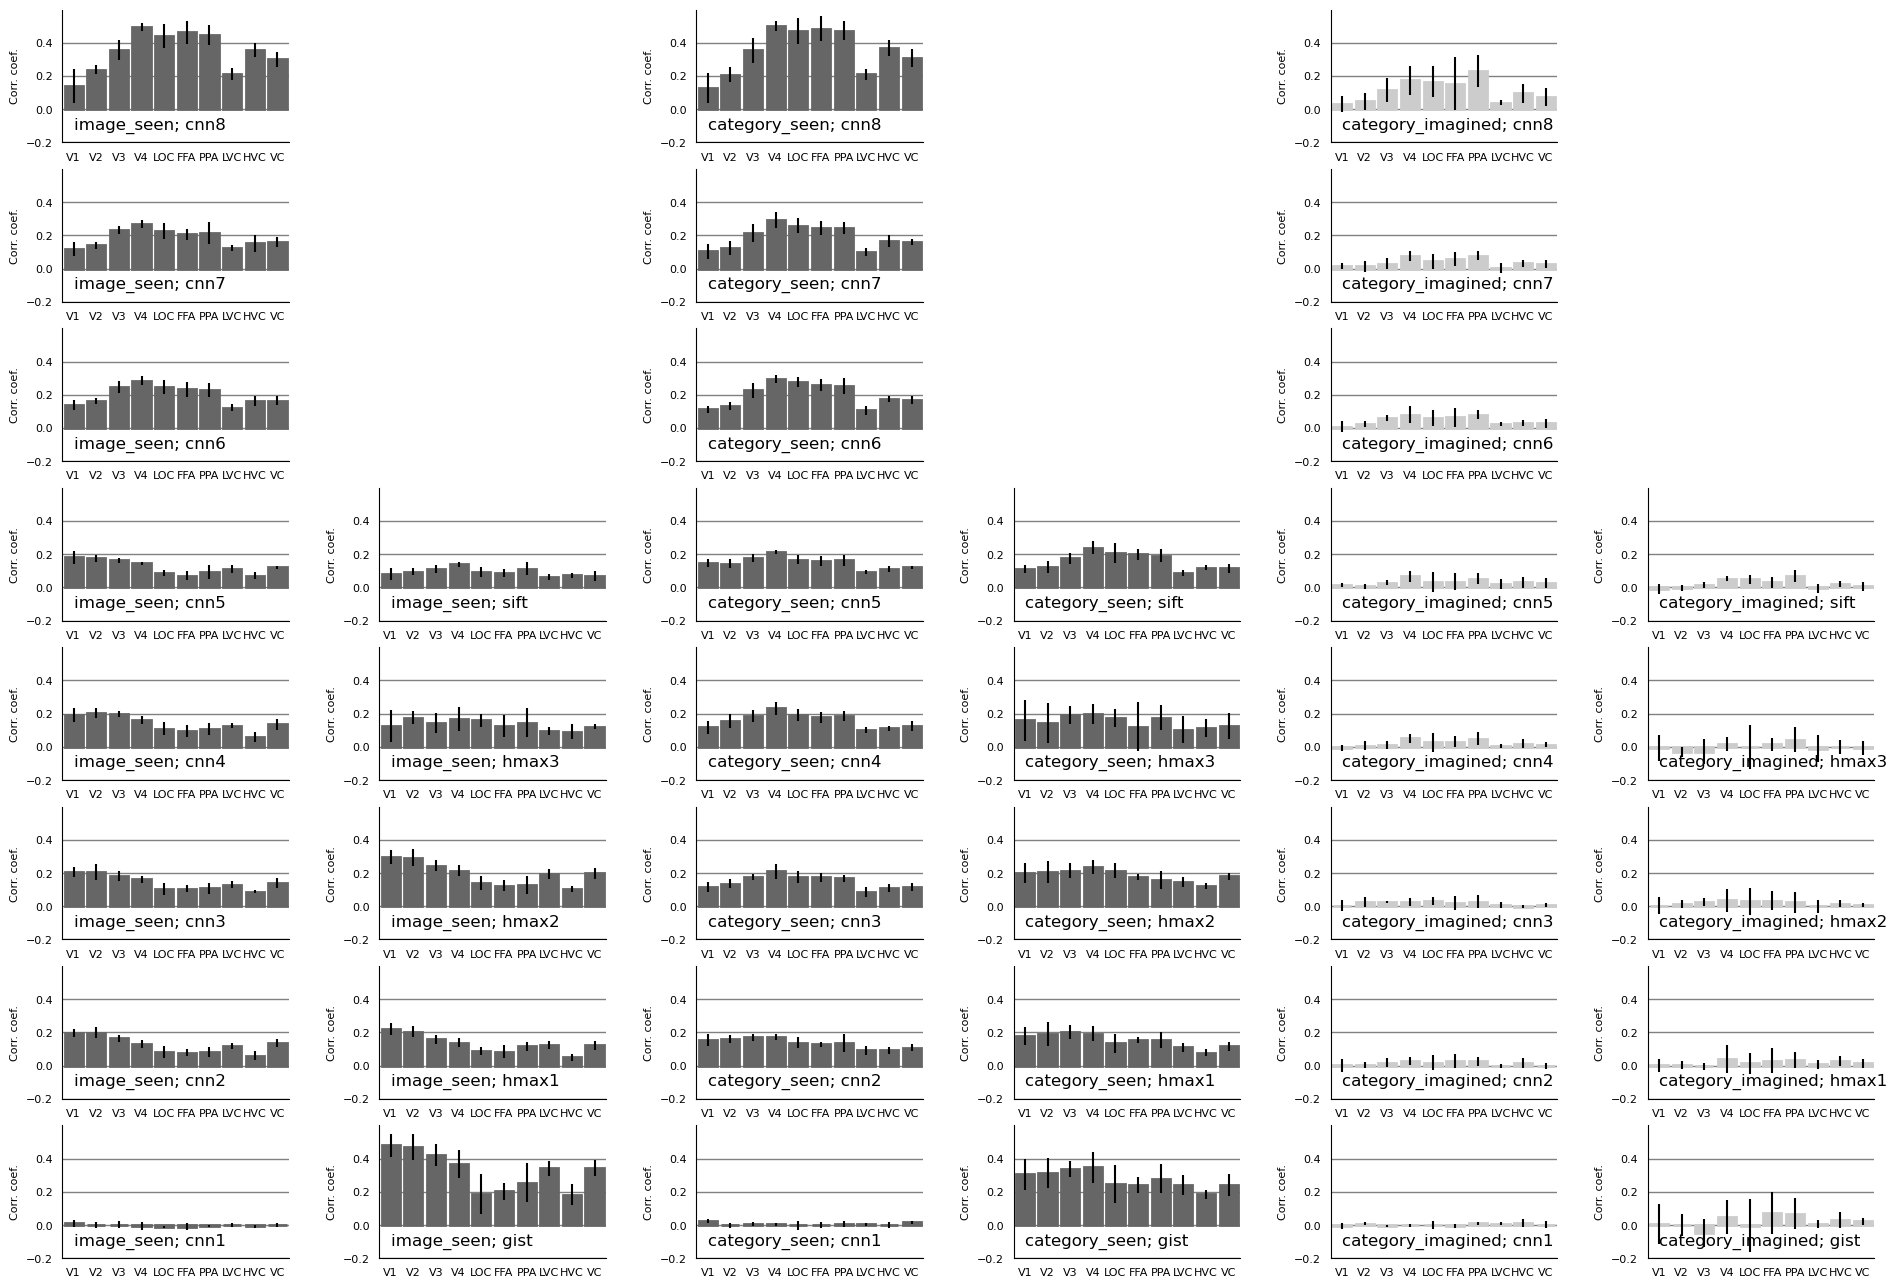

In [19]:
#.......................for Jupyter
import scipy.stats as st
import matplotlib.pyplot as plt 
import bdpy.fig as bfig
#.................................
results_file = config.results_file
output_file_featpred = os.path.join('results', config.analysis_name + '_featureprediction.pdf')
output_file_catident = os.path.join('results', config.analysis_name + '_categoryidentification.pdf')

roi_label = config.roi_labels

# Load results -----------------------------------------------------
with open(results_file, 'rb') as f:
    print('Loading %s' % results_file)
    results = pickle.load(f)

# Figure settings
plt.rcParams['font.size'] = 8

# Plot (feature prediction) ----------------------------------------
fig = plt.figure(figsize=[2 * 11.69, 2 * 8.27], dpi=100)

subplotpos_image = [43, 37, 31, 25, 19, 13, 7, 1, 44, 38, 32, 26, 20]
subplotpos_catpt = [45, 39, 33, 27, 21, 15, 9, 3, 46, 40, 34, 28, 22]
subplotpos_catim = [47, 41, 35, 29, 23, 17, 11, 5, 48, 42, 36, 30, 24]

# Image
plotresults(fig, results, value_key='mean_profile_correlation_image',
            roi_label=roi_label, subplot_index=subplotpos_image,
            caption='image_seen; ', ylabel='Corr. coef.', ylim=[-0.2, 0.6], ytick=[-0.2, 0, 0.2, 0.4])

# Category, seen
plotresults(fig, results, value_key='mean_profile_correlation_cat_percept',
            roi_label=roi_label, subplot_index=subplotpos_catpt,
            caption='category_seen; ', ylabel='Corr. coef.', ylim=[-0.2, 0.6], ytick=[-0.2, 0, 0.2, 0.4])

# Category, imagined
plotresults(fig, results, value_key='mean_profile_correlation_cat_imagery',
            roi_label=roi_label, subplot_index=subplotpos_catim,
            barcolor=[0.8, 0.8, 0.8],
            caption='category_imagined; ', ylabel='Corr. coef.', ylim=[-0.2, 0.6], ytick=[-0.2, 0, 0.2, 0.4])

# Draw path to the script
fpath = os.path.abspath(__file__)
bfig.draw_footnote(fig, fpath)

# Save the figure
plt.savefig(output_file_featpred)
print('Saved %s' % output_file_featpred)

plt.show()

# Plot (category identification) -----------------------------------
fig = plt.figure(figsize=[2 * 11.69, 2 * 8.27], dpi=100)

subplotpos_percept = [44, 38, 32, 26, 20, 14, 8, 2, 45, 39, 33, 27, 21]
subplotpos_imagery = [46, 40, 34, 28, 22, 16, 10, 4, 47, 41, 35, 29, 23]

# Image
plotresults(fig, results, value_key='catident_correct_rate_percept',
            roi_label=roi_label, subplot_index=subplotpos_percept,
            caption='seen; ', ylabel='Accuracy', ylim=[0.4, 1.0], ytick=[0.4, 0.6, 0.8, 1.0], textpos=[0, 0.92])

# Category, seen
plotresults(fig, results, value_key='catident_correct_rate_imagery',
            roi_label=roi_label, subplot_index=subplotpos_imagery,
            barcolor=[0.8, 0.8, 0.8],
            caption='imagined; ', ylabel='Accuracy', ylim=[0.4, 1.0], ytick=[0.4, 0.6, 0.8, 1.0], textpos=[0, 0.92])

# Draw path to the script
#fpath = os.path.abspath(__file__)
fpath = file()
bfig.draw_footnote(fig, fpath)

# Save the figure
plt.savefig(output_file_catident)
print('Saved %s' % output_file_catident)

plt.show()
